<style>
*{
    line-height: 24px;
}
</style>

# Retrieval Notebook

This notebook provides *some* intuition, along with run-able code (so long as the enviorment is set up according to **Usage** in [README.md](../README.md)) regarding how (and to what extect) the use of transformer-based ontology-aware embedding methods (specifically, Hierarchy Transformers REF and Ontology Transformers REF) affect knowledge retrieval performance, focusing on effectiveness rather than efficiency. Effectiveness is taken to mean: 'does your system find good results' REF, where as efficency concerns itself with how fast it finds them. When discussing effectiveness, we consider the specific tasks, as outlined within §3.1.1 of the associated paper (thesis submission). Summarily, we consider:

1. Single Target Knowledge Retrieval: This can be thought of as a form of *entity linking*. Specifically, the linkage should *loosly satisfy (approximate)* the the equivlance relation $e_{id} \equiv C \quad | \quad C \in N_C$, where $e_{id}$ is denoted the identified entity (for an arbitrary string), and $C$ is some concept in $N_C$ (the set of named classes) drawn from an ontology $\mathcal{O}$ (SNOMED CT). Alternatively, a valid *approximation* may also satisfy the subclass *(or subsumption, under inference)* relation $e_{id} \sqsubseteq C$.

2. Multiple Target Knowledge Retrieval: Extends single target knowledge retrieval by specifying that $e_{id} \sqsubseteq C^\star$ should hold, where $C^\star* is the reflective ancestor set of $C$ (essentially, any valid concept/class that holds under subsumption).

In order to evaluate effectivenss, we test agaisnt both **lexical** and **contextual** baselines, where TF--IDF and BM25 are used for lexical baselines and SBERT (MiniLM-L12-v2) is used for a contextual baselines; and we primarily use MRR for single target; whereas mAP and nDCG are both used for multiple target retrieval.

Summarily, we aim to *(..answer the research questions outlined in the thesis; but, ultimately:)* evaluate **whether the Ontology Transformer** framework (which builds on the Hierarchy Transformer) **is better than the** associated **strong contextual baseline** methods **on** the above-mentioned **knowledge retrieval tasks**, **for effective retrieval** (as measured using evaluation **metrics** that **preferentially weight early matches**, and provide some indication of ordering relevance for multi-target retrieval).

The research questions (RQ1, RQ2, RQ4, RQ5) are essentially captured and in-part discussed throughout this notebook. In this notebook we:

1. Provide some mathematical intuition (drwaing on both HiT REF and OnT REF for hyperbolic space and embeddings; then from the 'learning mixed curvature representations' paper for mixed models REF).
2. Describe the framework which supports our experimental evaluation (including data management and the retriever framework).
3. Outline the intuition behind nDCG and include implementations for all evaluation metrics.
4. Briefly discuss embedding and retrieval; and provide the neccesary code snippets for re-use.
5. Provide full implementations used in obtaining our experimental results.
6. Discuss **and test** *(in some detail)* the assumptions that underlay *(and justify)* our choice of ablation studies, i.e. the use of miniature models (the effects of ontology size on HiT/OnT training), and the performance of cross-domain encoders in regards to ANATOMY, specifically.

## TL;DR

This notebook is provided to show the results of the experiments, but also, to provide a *step by step* means by which to work through the code. First imports are provided (which can be largely ignored), then utility and math functions are outlined; encoding/producing embeddings (saving + loading) is demonstrated, retrievers are implemented and experiments are conducted: single-target knowledge retrieval, multiple target knowledge retrieval and assumption testing.

##### Quick Note on $\leftarrow$

Just a quick word on reading $\leftarrow$, typically thought of as assignment; in these notes, it is meant to be read *drawn from*, not dissimilar to, e.g. `elem c [N_C | N_C <- O]`, where `elem :: Eq a => a -> [a] -> Bool`.

### Imports

In [ ]:
from __future__ import annotations

from pathlib import Path
from pydantic import validate_call
from rank_bm25 import BM25Okapi
from multiprocessing import Pool, cpu_count
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from argparse import ArgumentParser, Namespace
from scipy.sparse import coo_matrix

from collections.abc import Generator, MutableMapping, Mapping, Sequence
from typing import Union, NamedTuple, override, Any
from functools import reduce
import math

from typing import override, Callable, Union, NamedTuple
from abc import ABC, abstractmethod
import numpy as np

from sklearn.metrics import auc as sk_auc

import statistics
import copy

import numpy as np
import json
import pickle
import logging
import sys

import torch

from rank_bm25 import BM25Okapi

from tqdm import tqdm
import re # RegEx

from typing import overload

from hierarchy_transformers import HierarchyTransformer
from OnT.OnT import OntologyTransformer

VERBOSE = False

In [66]:
! pip install json2html

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'json2html' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'json2html'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for json2html: filename=json2html-1.3.0-py3-none-any.whl size=7665 sha256=0956989ebf4ec80cbf7e3cbe3a8153add120b3f82045cf143e1e15183e84b888
  Stored in directory: /home/jon/.cache/pip/wheels/91/96/d0/3cfff4cc9a9e307cfc2b8fe4846c56d714b78bbe5f6da211a5
Successfully built json2html


In [67]:
import json2html

In [7]:
import latextable
from latextable import texttable

In [8]:
from typing import Callable, Sequence
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Basic Utilities

Small helper functions used for tokenisation and stripping higher level concept tags (e.g. '$Hear\ Disease\ (Condition) \rightarrow Heart\ Disease$') for leakage prevention.

In [9]:
_regex_parens = re.compile(r"\s*\([^)]*\)") # for parentheses removal (prevents leakage)

def strip_parens(s: str) -> str:
    return _regex_parens.sub("", s)

def load_json(file_path: Path) -> dict[str, str]:
    with file_path.open('r', encoding='utf-8') as fp:
        return json.load(fp)

def save_json(file_path: Path, payload: dict | list, encoding: str = "utf-8", indentation: int = 4) -> None:
    with open(file_path, "w", encoding=encoding) as fp:
        json.dump(payload, fp, indent=indentation)

def load_concepts_to_list(concepts_file_path: Path) -> list[str]:
    return list(load_json(concepts_file_path).values())

def naive_tokenise(seq: str) -> list[str]:
    return seq.lower().split()

# ~800k concepts, assuming 16 cores, 32 threads; 
# 800k / 32 = 25k (note: subprocesses != threads)
def parallel_tokenise(seq_list: list[str], workers: int, chunksize: int = 25000) -> list[list[str]]:
    with Pool(workers) as pool:
        return list(pool.map(naive_tokenise, seq_list, chunksize=chunksize))
    
def produce_candidate_ids_for_embs(embeddings_ds):
    return np.arange(len(embeddings_ds))

In [10]:
# weighted TF-IDF at run-time
def aggregate_posting_scores(query_weights, inverted):
    scores = {}
    for term, weight in query_weights.items():
        if term not in inverted:
            continue
        for doc_id, tfidf_score in inverted[term]:
            scores[doc_id] = scores.get(doc_id, 0.0) + weight * tfidf_score
    return scores

# sort TF-IDF result set
def topk(scores: dict[int, float], k: int = 10):
    return sorted(scores.items(), key=lambda x: x[1], reverse=True)[:k]

def build_tf_idf_index(axiom_list: list[str], tfidf_dest: str, *args, **kwargs):
    vectoriser = TfidfVectorizer(**kwargs)
    doc_term_matrix = vectoriser.fit_transform(axiom_list)
    vocab = vectoriser.get_feature_names_out()
    # prep for storing to disk: create empty postings struct
    inverted_index: dict[str, list[tuple[int, float]]] = {term: [] for term in vocab}
    # see: https://matteding.github.io/2019/04/25/sparse-matrices/
    coo = coo_matrix(doc_term_matrix)
    # populate the inverted index
    for row, col, score in zip(coo.row, coo.col, coo.data):
        inverted_index[str(vocab[col])].append((int(row), float(score)))
    # order: desc
    for postings in inverted_index.values():
        postings.sort(key=lambda x: x[1], reverse=True)
    # save to disk
    with open(tfidf_dest, "wb") as fp:
        pickle.dump(
        {
            "vectorizer": vectoriser,
            "postings": postings, # type: ignore
            "verbalisations": axiom_list
        },
        fp,
        protocol=pickle.HIGHEST_PROTOCOL,
    )
    return vectoriser, inverted_index

<style>
*{
    line-height: 24px;
}
</style>

## Math Functions

*(math_functools)*

We antisipate each retriever by defining a set of 'batch' (linalg/matrix ops) math functions *(in the ideal world, these would be entirely pure functions, but due to time constraints and perhaps not the very best software design decisions/technical debt; we inject the curvature of the embedding space, i.e. the poincare ball into the geodesic distance functions as **models themselves**, rather than the curvature from the model, this doesn't make a huge amount of sence insofar as it muddies seperation of concerns--TODO: fix this if there's time)*. These math functions are effectively callbacks (represent the `score`--$score_X(u, v)$--functions from the paper).

For intuition, each `batch` function with its single-element -- single-element counter-part; and provide the mathematical equations below.

**L2 distance:**

$$ L_2 = \| v - u \|_2 \equiv \sqrt{\sum_{i=1}^d (v_i - u_i)^2} $$

**Inner product:**

$$\sum_{i=1}^{d} u_i \cdot v_i $$

**Cosine Similarity:**

$$ sim(u,v) = \operatorname{cos}(\theta) = \frac{u \cdot v }{\| u \|_2 \| v \|_2} $$

**Geodesic Distance (\w adaptive/sectional curvature $\kappa$):**

$$
d_{\kappa}(u,v) = \frac{1}{\sqrt{\kappa}} 
\cdot 
\operatorname{arcosh} 
\Biggl( 1 + \frac{2\kappa \|u - v\|^{2}}{
  \bigl( 1 - \kappa \|u\|^{2} \bigr) \cdot \bigl( 1 - \kappa \|v\|^{2} \bigr)
}
\Biggr),
\qquad
\|u\|,\|v\|<\frac{1}{\sqrt{\kappa}}
$$

In [11]:
# see src/thesis/utils/math_functools.py

def batch_euclidian_l2_distance(u: np.ndarray, vs: np.ndarray) -> np.ndarray:
    return np.linalg.norm(u - vs, axis=1)

def l2_norm(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=np.float32)
    return np.sqrt(np.sum(x**2))

def batch_l2_norm(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=np.float32)
    return np.asarray(np.sqrt(np.sum(x**2, axis=1)))

def inner_product(p_u: np.ndarray, p_v: np.ndarray) -> np.ndarray:
    u = np.asarray(p_u, dtype=np.float32)
    v = np.asarray(p_v, dtype=np.float32)
    return np.inner(u, v)

def batch_inner_product(p_u: np.ndarray, p_vs: np.ndarray) -> np.ndarray:
    u = np.asarray(p_u, dtype=np.float32).ravel()
    vs = np.asarray(p_vs, dtype=np.float32)
    return vs.dot(u)

def cosine_similarity(u, v, normalised=True):
    u = np.asarray(u, dtype=np.float32)
    v = np.asarray(v, dtype=np.float32)
    return np.inner(u, v) if normalised else np.inner(u, v) / (l2_norm(u) * l2_norm(v))

def batch_cosine_similarity(p_u, p_vs, normalised=True):
    u  = np.asarray(p_u,  dtype=np.float32)
    vs = np.asarray(p_vs, dtype=np.float32)
    return batch_inner_product(u, vs) if normalised else batch_inner_product(u, vs) / (l2_norm(u) * batch_l2_norm(vs))

<style>
*{
    line-height: 24px;
}
</style>

## Hyperbolic Space, Quick Primer

*(Taken from paper, comes up repeatedly under HiT and OnT, see REF and REF)*

A Riemannian manifold $\mathcal{M}$ of dimension $d$ may be regarded as a smooth, curved submanifold within a higher-dimensional Euclidean space $\mathbb{R}^n$, equipped with a Riemannian metric, $(\mathcal{M}, g)$. For any point $x \in \mathcal{M}$, there exists a local neighbourhood in which the metric $g$ approximates the Euclidean metric on $\mathbb{R}^d$. Hyperbolic space $\mathbb{H}^n$ is a Riemannian manifold with a constant sectional curvature $-\kappa$, which can be represented in the Poincaré ball model whose points lie within the open ball, given by:

$$ B_{\kappa}^n = \{\ x \in \mathbb{R}^n : \|x\| < r\ \}, \qquad r=\frac{1}{\sqrt{\kappa}}, $$

where $r$ is the radius of the ball\footnote{The HiT/OnT library-based instantiations of geoopt's \texttt{PoincareBall} set the curvature parameter $c=\frac{1}{d}$ (where $d$ is the embedding dimension of the encoder module), thus $r=\sqrt{d}$. This ensures the encoder's $\operatorname{tanh}$-based activation outputs, which fall within the hypercube $[-1,1]^d$, fit within the ball; see \url{https://github.com/KRR-Oxford/HierarchyTransformers/blob/main/src/hierarchy_transformers/models/hierarchy_transformer/hyperbolic.py}}. The Poincaré metric $g_{\kappa}$ induces the geodesic distance function $d_{\kappa}$ between any two points $x,y \in B^n_{\kappa}$:

$$
d_{\kappa}(x,y) = \frac{1}{\sqrt{\kappa}} 
\cdot 
\operatorname{arcosh} 
\Biggl( 1 + \frac{2\kappa \|x - y\|^{2}}{
  \bigl( 1 - \kappa \|x\|^{2} \bigr) \cdot \bigl( 1 - \kappa \|y\|^{2} \bigr)
}
\Biggr),
\qquad
\|x\|,\|y\|<\frac{1}{\sqrt{\kappa}}
\
$$

As $\|x\|$ and $\|y\|$ approach the boundary of the ball (norm $\to \frac{1}{\sqrt{\kappa}}$), distances diverge even if the Euclidean norm difference $\|x-y\|$ is not itself significant, meaning that points situated near the boundary can represent particular nodes, elements or concepts; and is in contrast to points situated toward the center (which ought to more generic concepts).

In [12]:
def batch_poincare_distance_with_curv_k(u: np.ndarray, vs: np.ndarray, k: np.float64 | np.float32) -> np.float64 | np.float32:
    u_norm_sqd = np.sum(u**2)
    vs_norms_sqd = np.sum(vs**2, axis=1)
    l2_dist_sqd = np.sum((u - vs)**2, axis=1)
    offset = 1e-7 # tiny-offset: guard agaisnt division by zero & floating point arithmatic inaccuracies
    arg = 1 + ((2 * k * l2_dist_sqd) / ((1 - (k * u_norm_sqd + offset)) * (1 - (k * vs_norms_sqd + offset)))) # acosh
    arg = np.maximum(1.0, arg) # bounds check: domain of acosh is bound to [1, \inf)
    acosh_scaling = np.float64(1) / np.float64(np.sqrt(k)) # scaling factor: k
    return (acosh_scaling * np.arccosh(arg, dtype=np.float64)) # 1 / sqrt(k) * acosh(arg)

def batch_poincare_dist_with_adaptive_curv_k(u: np.ndarray, vs:np.ndarray, model: HierarchyTransformer | OntologyTransformer, **kwargs):
    if isinstance(model, HierarchyTransformer):
        k = np.float64(model.get_circum_poincareball(model.embed_dim).c)
    elif isinstance(model, OntologyTransformer):
        hierarchy_model = model.hit_model
        hierarchy_poincare_ball = hierarchy_model.get_circum_poincareball(hierarchy_model.embed_dim)
        k = np.float64(hierarchy_poincare_ball.c)    
    else:
        raise Exception("Hyperbolic distance should only be only calculated in B^n or H^n")
    return np.asarray(batch_poincare_distance_with_curv_k(u, vs, k))

<style>
*{
    line-height: 24px;
}
</style>

## Subsumption Score

*(Note: this writing is much more 'note format'--hopefully, it conveys some intuition).*

As this work is fundamentally based on the Hierarchy Transformer (HiT) and Ontology Transformer (OnT), we note that both are based on mapping the output space of a modified SBERT encoder (where the result of the output embeddings, i.e. `tanh : H_{state} -> output`, is bound to `[-1,1]`--a hypercube) is circumscribed by a poincare ball (think of this as a cube encapsulated within a sphere); and since the space within a poincare ball operates according to hyperbolic geometry (since, it is hyperbolic space; by definition), then we can picture this as a kind of 'warped curved space' constrained to a *(hyper)* sphere, situated within a larger euclidean space.
  
( ▢ )

*(TODO: replace the ASCII diagram with an actual diagram)*

Within the poincare ball we model relationships such that the curvature associated with distance (or, geodesics) between any two points $u,v$ in $B^n$ (this representation) grows increaing larger the further they are situated from the origin (nearer to the circumfrance). Thus, distances that would ordinarily be 'quite far' in $\mathbb{R}$ are much larger in $\mathbb{H}$ for pairs of points situated further from the origin *(grows exponentially as you move towards the circumfrance of the ball, as you're approaching $\infty$)*; so, the idea behind the encoder's use of hyperbolic clustering loss and centripetal loss is to: 1. cluster similar concepts together, but also push more *fine-grained* concepts towards the boundaries; so that if we want to provide a score for how likely some concept C is subsumed by D (and given that they're ordered hierarchically relative to the origin), then we want to find two concepts that are near to one another, but we also we want to offset the depth so that the score function preferentially weights concepts with a hierarchical pre-order within the space. This is essentially what is happening with the subsumption score function, as provided below: 

$$
score(u, v) = - \big(d_\kappa(\boldsymbol{x}_{u}, \boldsymbol{x}_v) + \lambda (\|\boldsymbol{x}_{v}\|_{\kappa} - \| \boldsymbol{x}_{u}\|_{\kappa})\big),
$$

Specifically, the *depth-agnostic* distance term $d_\kappa(\boldsymbol{x}_{u}, \boldsymbol{x}_v)$ scores pairs of points (embeddings) that are close to one another higher, then this is offset by the *'depth bias'* (centripetal weight) $\lambda (\|\boldsymbol{x}_{v}\|_{\kappa} - \| \boldsymbol{x}_{u}\|_{\kappa})$, where any candidate parents are judged to more likely subsume the child if they are situated closer to the origin than the child candidate *(due to the hierarchical pre-order)*.


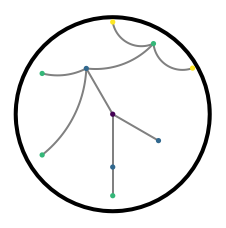 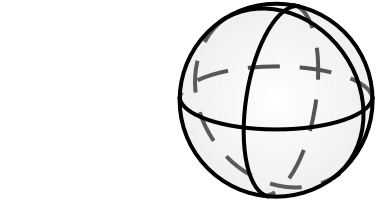

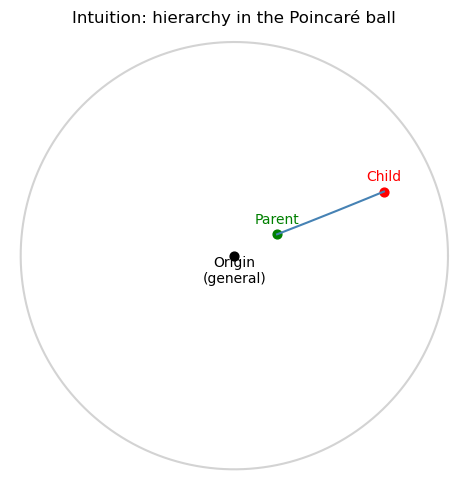

In [13]:
# additional metrics

def identity(x):
    return x

def subsumption_score_hit(hit_transformer: HierarchyTransformer, child_emb: np.ndarray | torch.Tensor, parent_emd: np.ndarray | torch.Tensor, centri_weight: float = 1.0):
    child_emb_t = torch.Tensor(child_emb)
    parent_emb_t = torch.Tensor(parent_emd)
    dists = hit_transformer.manifold.dist(child_emb_t, parent_emb_t)
    child_norms = hit_transformer.manifold.dist0(child_emb_t)
    parent_norms = hit_transformer.manifold.dist0(parent_emb_t)
    return -(dists + centri_weight * (parent_norms - child_norms))

def subsumption_score_ont(ontology_transformer: OntologyTransformer, child_emb: np.ndarray | torch.Tensor, parent_emb: np.ndarray | torch.Tensor, weight_lambda: float = 1.0):
    child_emb_t = torch.Tensor(child_emb)
    parent_emb_t = torch.Tensor(parent_emb)
    return ontology_transformer.score_hierarchy(child_emb_t, parent_emb_t, weight_lambda)

def entity_subsumption(u: np.ndarray, vs: np.ndarray, model: HierarchyTransformer, *, weight: float = 0.35):
    return np.asarray(subsumption_score_hit(model, u, vs, centri_weight=weight))

def concept_subsumption(u: np.ndarray, vs: np.ndarray, model: OntologyTransformer, *, weight: float = 0.35, **kwargs):
    return np.asarray(subsumption_score_ont(model, u, vs, weight_lambda=weight))

<style>
*{
    line-height: 24px;
}
</style>

## Data Mapping & Management

The way in which data is managed takes _*<u>some</u>*_ inspiration from the notion of an **object relational mapping** (ORM). 

We can think of queries as instances of data (objects, with an associated **query string** and **target set**), whose targets relate to one another through subsumption and equivalance (at minimum). Additionally, since we want to use these queries as input to our experiments, we define their shape at the data-level *(see the provided JSON files; no schema, sorry!)*, and then wrap that shape within a model (a class) that can be instanciated with a specific instance of datum. Furthermore, we can equip the model with a set of methods, allowing us to mutate the data after it has been load *(a data model, essentially)*.

**That is, each query:**

* has an associated 'query string' $q_s$ and a target class $C$.
* Is an instance of subsumption query or equivelance query.

Where, a subsumption query has a target set of classes $C^\star$, where any valid antescendant of the original target class is considered a relevant target (with associated *'in-built'* methods for calculating relevance, etc.); and similar is the case with an equivelance query *(though, we don't focus too much on these)*.

*An example (a very basic) model:*

$q := \{ q_s,\ target,\ target_{ancestors},\ query_{mathods} \} \qquad \forall q \in Q$

### Class Diagram

![img](https://kroki.io/mermaid/svg/eNq1VT1z2zAMnetfoc1yYk3devXSa7s1_UonX45HSZBCmyIZknKqa_vfC1IfFhm556Ve7MMD8EDgAS44NeY9o7WmzapkGgrLpEju360S_BQOTb62oLvk1-qVM2UEhGW2I437Rtc3SckKuzdWb5MfAi39Tybsw8MY8uQyEJkfiAalh5AQxCAmaoTwx4hYqmuwVzDcEsIEs4SkIVMfuRmcMFdAlm7mdB7uGQnT7DLIaQ78MlyCso8exgJfwB7wr3fAn1mXPzy17BS32tmIxwn8VBqM6Vs-a8OdFHBlG2LK721u2ka5MUbEVBRgrNQGuTgz06wU1Tj20HpV8zNisAdDeBoYJ650PqjJNeSqw4AFkHNixnedYGj7omsrGFZ8rbeR2kK56H2Ebrf2c19vEw0n0AZ2Hyk3sE28mRStlVW1e_2PKv5T-iEJeWboVxZ1ajsFuzWqaR1Hb5Obm-Mz-huXx7aKw77iktqtT7p345w2zq9JCZRHSV-qzEvrc37A0_KJKuW2fNJZSS2NJOZMpGIcUAL2EcEv-BUuhNMZg1ibWGkJJRpzKfkksKGfizFn5R6MFAOz6hk387ReD27RhjhnI5WWja9xKTrwz0hDVZxjvEZYVHrutyuub_e80fEr-mkKSaymwlRSN9QtcbhBy0FRBJGCd-mFoX0D03I7TusWr2Jw9DDTMThzppAa0OJFM9hQrTnF99Dhz8KFx2R3tIHy3r0fuc5gf5Pe_s6y2XGMkfiGeXyW0DvNXrP6CzOJOVo)

### Data Mapping: Utilities

In [14]:
# data mapping: utils

def make_signature(obj):
  if isinstance(obj, Mapping):
    return tuple((key, make_signature(obj[key])) for key in sorted(obj))
  elif isinstance(obj, Sequence) and not isinstance(obj, (str, bytes, bytearray)):
    return tuple(make_signature(item) for item in obj)
  # else:
  return obj

def unique_unhashable_object_list(obj_xs: list[dict]) -> list[dict]:
    object_signatures = set()
    unique_obj_list = []
    for obj in obj_xs:
      signature = make_signature(sorted(obj.items()))
      if signature not in object_signatures:
        object_signatures.add(signature)
        unique_obj_list.append(obj)
    return unique_obj_list

def obj_max_depth(x: int, obj: Any, key: str = "depth") -> int:
  return x if x > obj[key] else obj[key]

def dcg_exp_relevancy_at_pos(relevancy: int, rank_position: int) -> float:
  if relevancy <= 0:
    return float(0.0)
  numerator = (2**relevancy) - 1
  denominator = math.log2(rank_position + 1)
  return float(numerator / denominator)

def dcg_linear_relevancy_at_pos(relevancy: int, rank_position: int) -> float:
  if relevancy <= 0:
    return float(0.0)
  numerator = relevancy
  denominator = math.log2(rank_position + 1)
  return float(numerator / denominator)

def accumulate(a, b, key='dcg'):
  return a + b[key]

### Data Mapping: Query Models

In [15]:
class Query:
  
  _query_obj_repr: dict
  _query_string: str
  _target: dict[str, Union[str, int]]
  _entity_mention: dict[str, Union[str, int]]

  def __init__(self, query_obj_repr: dict):
    self._query_obj_repr = query_obj_repr
    self._query_string = query_obj_repr['entity_mention']['entity_literal']
    self._target = query_obj_repr['target_entity']
    self._entity_mention = query_obj_repr['entity_mention']

  def get_query_string(self) -> str:
    return self._query_string
  
  def get_target_iri(self) -> str:
    return str(self._target['iri'])
  
  def get_target_label(self) -> str:
    return str(self._target['rdfs:label'])
  
  def get_target_depth(self) -> int:
    return int(self._target['depth'])
  
  def get_target(self) -> dict:
    return self._target

In [16]:
class EquivQuery(Query):
  
  _equiv_class_expression: Union[str, None]

  def __init__(self, query_obj_repr: dict):
    super().__init__(query_obj_repr)

In [17]:
class SubsumptionQuery(Query):
  
  _parents: list
  _ancestors: list

  def __init__(self, query_obj_repr: dict):
    super().__init__(query_obj_repr)
    self._set_parents()
    self._set_ancestors()

  def _set_parents(self):
    if self._query_obj_repr['parent_entities'] and len(self._query_obj_repr['parent_entities']) > 0:
      self._parents = self._query_obj_repr['parent_entities']
    else:
      self._parents = []

  def _set_ancestors(self):
    if self._query_obj_repr['ancestors'] and len(self._query_obj_repr['ancestors']) > 0:
      self._ancestors = self._query_obj_repr['ancestors']
    else:
      self._ancestors = []

  def get_parents(self) -> list:
    return self._parents
  
  def get_ancestors(self) -> list:
    return self._ancestors
  
  def get_all_subsumptive_targets(self) -> list:
    return [self._target, *self._parents, *self._ancestors]
  
  def get_unique_subsumptive_targets(self) -> list:
    return unique_unhashable_object_list(
      self.get_all_subsumptive_targets()
    )

  def get_sorted_subsumptive_targets(self, key="depth", reverse=False, depth_cutoff=3) -> list:
    xs = self.get_all_subsumptive_targets()
    xs.sort(key=lambda x: x[key], reverse=reverse)
    return xs[:depth_cutoff]
  
  def get_unique_sorted_subsumptive_targets(self, key="depth", reverse=False, depth_cutoff=3) -> list:
    return unique_unhashable_object_list(
      self.get_sorted_subsumptive_targets(key=key, reverse=reverse, depth_cutoff=depth_cutoff)
    )
  
  def get_targets_with_dcg(self, type="exp", depth_cutoff=3, **kwargs) -> tuple[float, list[dict]]:
    # get targets (target, parents, ancestors) ordered in ascending via depth
    targets_asc_depth = self.get_unique_sorted_subsumptive_targets(key="depth", depth_cutoff=depth_cutoff)
    # increase depth by 1 (offsetting zero-based index)
    targets_w_offset = [
      {**x, "depth": x["depth"] + 1}
      for x in targets_asc_depth
    ]
    # find the max depth (to calculate relevancy): (max_depth - depth_at_pos_k) + zero_based_offset
    # which we refer to as: relevancy := ascent height + zero_based_offset
    max_target_depth = reduce(
      obj_max_depth, 
      targets_w_offset, 
      0
    )
    # calculate relevance for each target (node/parent/ancestor) 
    targets_with_rel = [
      {**x, "relevance": (max_target_depth - x["depth"]) + 1}
      for x in targets_w_offset
    ]
    # ensure targets are sorted by relevance
    targets_with_rel.sort(key=lambda x: x['relevance'], reverse=True)
    # calculate dcg:
    if type == "linear":
      targets_with_dcg = [
        {**x, "dcg": dcg_linear_relevancy_at_pos(x['relevance'], rank)}
        for rank, x in enumerate(targets_with_rel, start=1)
      ]
    else:
      targets_with_dcg = [
        {**x, "dcg": dcg_exp_relevancy_at_pos(x['relevance'], rank)}
        for rank, x in enumerate(targets_with_rel, start=1)
      ]
    iDCG = reduce(accumulate, targets_with_dcg, 0)
    self._idcg = iDCG
    self._targets_with_dcg = targets_with_dcg
    return iDCG, targets_with_dcg

  def get_ideal_dcg(self, type="exp"):
    if self._idcg:
      return self._idcg
    iDCG, targets = self.get_targets_with_dcg()
    return iDCG

In [18]:
class QueryObjectMapping:

  _loaded: bool
  _data_file_path: Path
  _data: list
  _equiv_queries: list
  _subsumpt_queries: list

  @validate_call
  def __init__(self, json_data_fp: Path):
    self._loaded = False
    self._data_file_path = json_data_fp
    self._load()
    self._map()

  def _load(self) -> None:
    with self._data_file_path.open('r', encoding='utf-8') as fp:
      self._data = json.load(fp)
    self._loaded = True

  @validate_call
  def load_from_path(self, json_data_fp: Path) -> None:
    # overwrite an existing file path
    self._data_file_path = json_data_fp
    self._load()

  # equivalence_retrieval: bool = True, subsumption_retrieval: bool = False
  def _map(self) -> None:
    equiv_queries = []
    subsumpt_queries = []
    for query_obj_repr in self._data:
      # if the query obj within the data contains an equiv class
      if len(query_obj_repr['equivalent_classes']) > 0:
        # we're dealing with an equiv query
        equiv_queries.append(EquivQuery(query_obj_repr))
      else:
        subsumpt_queries.append(SubsumptionQuery(query_obj_repr))
    self._equiv_queries = equiv_queries
    self._subsumpt_queries = subsumpt_queries

  def get_queries(self) -> tuple[list, list]:
    return (self._equiv_queries, self._subsumpt_queries)
  
  def get_subsumpt_queries_with_no_transformations(self):
    tmp_subsumpt_queries = copy.deepcopy(self._subsumpt_queries)
    result_queries = []
    for query in tmp_subsumpt_queries:
      if query._entity_mention['transformed_entity_literal_for_type_alignment'] == "":
        result_queries.append(query)
    return result_queries
  
  def get_subsumpt_queries_with_transformations_only(self):
    tmp_subsumpt_queries = copy.deepcopy(self._subsumpt_queries)
    result_queries = []
    for query in tmp_subsumpt_queries:
      if query._entity_mention['transformed_entity_literal_for_type_alignment'] != "":
        result_queries.append(query)
    return result_queries

In [19]:
class QueryResult(NamedTuple):
  rank: int
  iri: str
  score: float
  verbalisation: str

<style>
*{
    line-height: 24px;
}
</style>

## Retrievers

The notion of retrievers is summerised as below:

    "The Retriever is responsible for searching and retrieving the most relevant documents or facts from an external knowledge base. It acts like a search engine that helps the AI model access up-to-date and factual information."
  source: [https://dev.to/shaheryaryousaf/understanding-the-key-components-of-rag-retriever-and-generator-1a1j](https://dev.to/shaheryaryousaf/understanding-the-key-components-of-rag-retriever-and-generator-1a1j)

The job of our retrievers is to search through all defined concepts $C \in (N_C \leftarrow \mathcal{O})$ (names, verbalisations... **textual representations**) within the **ontology** *(focus is on the TBox)* and find conceptually similar concepts, or concepts whose candidacy **approximates** the subsumption relation $q \sqsubseteq D$ (given by the liklihood provided via the previously defined subsumption score).

We're using embeddings (euclid embeddings for SBERT, hyperbolic embeddings/poincare embeddings for HiT/OnT) to represent classes (concepts) as (as hinted above) we can perform some notion of reasoning (approximation) over the embedding space, and the representations are particularly well-suited to hierarchical data structures. Thus, we use retrievers as a convienent wrapper to drive retrieval of relevant concepts from the embedding store. For lexical retrievers, they either simply store the textual representations/verbalisations in memory, or save an inverted index to disk to re-use later; and of course, the retrievers are also responsible for keeping track of the mapping: $verbalisation \leftrightarrow embedding$.

### Class Diagram

![img](https://kroki.io/mermaid/svg/eNrtVlFv0zAQfma_wo_taJEomoQqXmjHNB5KYS28VFHkJtfUamIX2x0rjP_O2Y3TJDiRYBXaJPqQynfffXfnO_scpVSpS0YTSbOzmEmINBOczEdnBH-R0ZK3ozH5Ydc_S9IRVXADWjK4BYn6Z0bVDzPQNMzolgxJypR2YsQsKQqooVcV5fMwZJzpMOxUQeFqOyQfqV73iCMtRN3cVOYBdL7uQO5DhSueDAn-98j5-eYblYnq5t4WnwzmBtQu1YE3nYmIIfXkFFEes5hqwEBjFjEwCfDtCx5TKenewSBbQhxjAH51ZthR85ljdosZcA08grmkXK2EzABDvmYgqYzW-4p0yrVIRVIWBo5URUJCuOLIO6ZpSpcp_P2u9sgxBc9WJ7iJIJ3LHbet0nERHAN4eHFqHu3OdezXmhujD4JDHZeKiKZl9DGJikVeqt_j6lYLV--Razb3dXxeV19EjyXyKX-qkc9G726eauyjyeDCE_oyG1ygodFON3TLnFyLDXD2HaHHs7RYoJugR2aAzvG6sMvgARdnfStOdX_Or95fXnmSZRyXGmJzdcIdUuEFqhfWgSXVuy1mybjukVUqqA6C4m7TKxavMHrkNIaRkvnizzeM3FfKeYtjTsjccm7cfCkkj3BvJ-wO4qbhtMYosT39M8co3UnxDReHE7yFxCgdiWcWFaNoiYVuZjmoHY9n_BVAlmTUQ3GCkijQB_qO_Q7Jofts4-X959qwZpkUlkbRbHby2o93SoustQNc8cKXg9eNBbSAV4P2AucMLUU-Qi3X_3b4Z-1gXuFv7vv96sPbqqpP8QJU7ZcCWWsjCy-_bFqB5YdEK7A6txvDLE_IJlB1tDShPEekCdp4pn4BLIFCAg)

In [20]:
# Retrievers:

# 1. Take an embeddings .npy file
# 2. Take an embeddings verbalisation file
# 3. Take an embeddings map
# 4. Construct a retriever instance
# 5. Allow for registration of a (local/remote) embedding model
# 6. Allow for registration of a score function

In [21]:
class BaseRetriever(ABC):
    
  _verbalisations: list
  _meta_map: list

  @validate_call
  def __init__(self, verbalisations_fp: Path, meta_map_fp: Path):
    with open(verbalisations_fp, 'r', encoding='utf-8') as fp:
      self._verbalisations = json.load(fp)
    with open(meta_map_fp, 'r', encoding='utf-8') as fp:
       self._meta_map = json.load(fp)

  @abstractmethod
  def retrieve(self, query_string: str, *, top_k: int = 10, **kwargs) -> list[QueryResult]:
    pass

In [22]:
from typing import overload

class BaseModelRetriever(BaseRetriever):
   
  _embeddings: np.ndarray
  _candidate_indicies: np.ndarray
  _model: Union[SentenceTransformer, HierarchyTransformer, OntologyTransformer]
  _score_fn: Callable

  @overload
  def __init__(self, verbalisations_fp: Path, meta_map_fp: Path, embeddings_fp: Path): ...

  @overload
  def __init__(self, verbalisations_fp: Path, meta_map_fp: Path, embeddings_fp: Path, *, score_fn: Callable | None = None): ...
    
  @overload
  def __init__(self, verbalisations_fp: Path, meta_map_fp: Path, embeddings_fp: Path, *, score_fn: Callable | None = None, model_fp: Path | None = None): ...
    
  @overload
  def __init__(self, verbalisations_fp: Path, meta_map_fp: Path, embeddings_fp: Path, *, score_fn: Callable | None = None, model_fp: Path | None = None, model_str: str | None = None): ...

  @validate_call
  def __init__(self, verbalisations_fp: Path, meta_map_fp: Path, embeddings_fp: Path, *, score_fn: Callable | None = None, model_fp: Path | None = None, model_str: str | None = None):
    super().__init__(verbalisations_fp, meta_map_fp)
    self._embeddings = np.load(embeddings_fp, mmap_mode="r")
    self._candidate_indicies = np.arange(len(self._embeddings))
    if score_fn:
      self.register_score_function(score_fn)
    if model_fp:
      try:
        self.register_local_model(model_fp.expanduser().resolve())
      except FileNotFoundError:
        self.register_model(str(model_fp))
    elif (not model_fp and model_str):
      self.register_model(model_str)

  def register_score_function(self, score_fn: Callable):
    self._score_fn = score_fn

  @override
  def retrieve(self, query_string: str, *, top_k: int | None = None, reverse_candidate_scores=False, **kwargs) -> list[QueryResult]:
    """
    TODO: 1. add docstring explaining why **kwargs is accepted and pass through to _score_fn
          2. add explaination of parameters
          3. types (args/return)
    """
    query_embedding = self._embed(query_string)
    scored_embeddings = self._score_fn(query_embedding, self._embeddings, **kwargs)
    if reverse_candidate_scores and top_k is not None:
      top_k_indicies = self._candidate_indicies[np.flip(np.argsort(scored_embeddings))[:top_k]]
    elif not reverse_candidate_scores and top_k is not None:
      top_k_indicies = self._candidate_indicies[np.argsort(scored_embeddings)[:top_k]]
    elif reverse_candidate_scores and top_k is None:
      top_k_indicies = self._candidate_indicies[np.flip(np.argsort(scored_embeddings))]
    elif not reverse_candidate_scores and top_k is None:
      top_k_indicies = self._candidate_indicies[np.argsort(scored_embeddings)]
    else:
      raise KeyError("Valid arguments for reverse_candidate_scores and top_k must be set.")
    results = []
    for rank, candidate_index in enumerate(top_k_indicies):
      candidate_score = scored_embeddings[candidate_index]
      candidate_meta_map = self._meta_map[candidate_index]
      candidate_verbalisation = candidate_meta_map['verbalisation']
      candidate_iri = candidate_meta_map['iri']
      results.append((rank, candidate_iri, candidate_score, candidate_verbalisation))
    return results

  @abstractmethod
  def register_model(self, model: str) -> None:
    pass

  @abstractmethod
  def register_local_model(self, model_fp: Path) -> None:
    pass

  @abstractmethod
  def _embed(self, query_string: str) -> np.ndarray:
    pass


In [23]:
class HiTRetriever(BaseModelRetriever):

  @override
  def register_model(self, model: str) -> None:
    self._model = HierarchyTransformer.from_pretrained(model)

  @override
  def register_local_model(self, model_fp: Path) -> None:
    self._model = HierarchyTransformer.from_pretrained(str(model_fp.expanduser().resolve()))  

  @override
  def _embed(self, query_string: str) -> np.ndarray:
    return (self._model.encode(
      [query_string]
    ).astype("float32"))[0] # type: ignore

In [24]:
class OnTRetriever(BaseModelRetriever):

  @override
  def register_model(self, model: str) -> None:
    self._model = OntologyTransformer.load(model)

  @override
  def register_local_model(self, model_fp: Path) -> None:
    self._model = OntologyTransformer.load(str(model_fp.expanduser().resolve()))

  @override
  def _embed(self, query_string: str) -> np.ndarray:
    return (self._model.encode_concept(
      [query_string]
    ).astype("float32"))[0] # type: ignore

In [25]:
class SBERTRetriever(BaseModelRetriever):

  @override
  def register_model(self, model: str) -> None:
    self._model = SentenceTransformer.load(model)

  @override
  def register_local_model(self, model_fp: Path) -> None:
    self._model = SentenceTransformer.load(str(model_fp.expanduser().resolve()))

  @override
  def _embed(self, query_string: str) -> np.ndarray:
    return (self._model.encode(
      [query_string]
    ).astype("float32"))[0] # type: ignore

In [26]:
class BM25Retriever(BaseRetriever):
    
  _bm25: BM25Okapi

  @validate_call
  def __init__(self, verbalisations_fp: Path, meta_map_fp: Path, k1: float = 1.3, b: float = 0.7):
    super().__init__(verbalisations_fp, meta_map_fp)
    self._tokenised_verbalisations = parallel_tokenise(self._verbalisations, workers=4)
    self._bm25 = BM25Okapi(self._tokenised_verbalisations, k1=k1, b=b)

  @classmethod
  def build_from_index(cls, index_fp: Path | str):
    pass

  def save_index(self, index_fp: Path | str):
    if isinstance(index_fp, Path):
      index_fp = str(index_fp.expanduser().resolve())
    with open(index_fp, "wb") as fp:
      pickle.dump({
        "index": self._bm25,
        "verbalisations": self._verbalisations,
        "meta_map": self._meta_map
      }, fp, protocol=pickle.HIGHEST_PROTOCOL)
    print("Saved BM25 index to disk.")
    
  def load_index(self, index_fp: Path | str):
    if isinstance(index_fp, Path):
      index_fp = str(index_fp.expanduser().resolve())
    with open(index_fp, "rb") as fp:
      bm25_bin = pickle.load(fp)
    self._bm25 = bm25_bin['index']
    self._verbalisations = bm25_bin['verbalisations']
    self._meta_map = bm25_bin['meta_map']

  def retrieve(self, query_string: str, *, top_k: int | None = None, **kwargs) -> list[QueryResult]:
    tokens = naive_tokenise(query_string)
    scores = self._bm25.get_scores(tokens)
    if top_k is not None:
      top_idx = np.argsort(scores)[::-1][:top_k]
    else:
      top_idx = np.argsort(scores)[::-1]
    results = []
    for rank, idx in enumerate(top_idx):
      iri = self._meta_map[idx]['iri']
      verbalisation = self._verbalisations[idx]
      results.append(
        QueryResult(
          rank=rank,
          iri=iri,
          score=float(scores[idx]),
          verbalisation=verbalisation
        )
      )
    return results

In [ ]:
class TFIDFRetriever(BaseRetriever):
  
  # TODO: clean up and implement `save` and `load` methods, similar to BM25.

  _vectorizer: TfidfVectorizer
  _inverted_index: dict[str, list[tuple[int, float]]]
  _tfidf_matrix: "scipy.sparse.csr_matrix"
  _tokenizer: Callable[[str], Sequence[str]] | None

  @validate_call
  def __init__(self, verbalisations_fp: Path, meta_map_fp: Path, *,
    lowercase: bool = True, stop_words: str | None = "english",
    ngram_range: tuple[int, int] = (1, 1),
    tokenizer: Callable[[str], Sequence[str]] | None = None,
    max_features: int | None = None,
  ) -> None:
    super().__init__(verbalisations_fp, meta_map_fp)
    self._vectorizer = TfidfVectorizer(
      stop_words="english",
      use_idf=True,
      smooth_idf=True,
      # norm="l2"
      norm=None
    )
    doc_term_matrix = self._vectorizer.fit_transform(self._verbalisations)
    vocab = self._vectorizer.get_feature_names_out()
    inverted_index: dict[str, list[tuple[int, float]]] = {term: [] for term in vocab}
    coo = coo_matrix(doc_term_matrix)

    for row, col, score in zip(coo.row, coo.col, coo.data):
      inverted_index[str(vocab[col])].append((int(row), float(score)))
    for postings in inverted_index.values():
      postings.sort(key=lambda x: x[1], reverse=True)

    self._inverted_index = inverted_index

  def retrieve(self, query_string: str, *, top_k: int | None = None, **kwargs) -> list[QueryResult]:
    query_vec = self._vectorizer.transform([query_string])
    vocab = self._vectorizer.get_feature_names_out()        
    q_weights = {
      vocab[col]: float(val)
      for col, val in zip(query_vec.indices, query_vec.data) # type: ignore
      if val > 0.0
    }
    tfidf_scores = aggregate_posting_scores(q_weights, self._inverted_index)
    if top_k:
      tfidf_top = topk(tfidf_scores, top_k)
    else:
      tfidf_top = topk(tfidf_scores, len(tfidf_scores))
    results: list[QueryResult] = []
    for rank, (doc_id, score) in enumerate(tfidf_top, 1):
      iri = self._meta_map[doc_id]['iri']
      verbalisation = self._meta_map[doc_id]['verbalisation']
      results.append(
        QueryResult(
          rank=rank,
          iri=iri,
          score=float(score),
          verbalisation=verbalisation,
        )
      )
    return results

<style>
*{
    line-height: 24px;
}
</style>

#### Mixed Models

*(Taken from the paper)*

For a sequence of manifolds $\mathcal{M}_1, \mathcal{M}_2, \ldots , \mathcal{M}_n$, the Cartesian product of each component manifold defines the product manifold, noted $\mathcal{M}_{\times} = \mathcal{M}_1 \times \mathcal{M}_2 \times \ldots \times \mathcal{M}_n$. The shortest path between any pair of points $x,y \in \mathcal{M}_\times$ is given by the shortest path as measured across each component manifold. 

A pair of embedding models is defined:

$$
f_{ont} : \Sigma^\ast \to B^n_{\kappa},
\qquad
f_{ctx} : \Sigma^\ast \to \mathbb{R}^d,
$$

where $f_{ont}$ is an OnT encoder and $f_{ctx}$ is an SBERT encoder. Each operates over its own distinct model space, producing embeddings $\boldsymbol{x}$ for a given query string $q_s$:

$$
f_{ont}(q_s) = \boldsymbol{x}_{q_s}^{ont} \in B^n_{\kappa}, 
\qquad 
f_{ctx}(q_s) = \boldsymbol{x}_{q_s}^{ctx} \in \mathbb{R}^d
$$

As such, the pair:

$$
\boldsymbol{x}_{q_s}^{\times} 
= 
(\boldsymbol{x}_{q_s}^{ont}, \boldsymbol{x}_{q_s}^{ctx}) 
\in
\mathcal{M}_{\times},
$$

is a single point on the heterogeneous product manifold $\mathcal{M}_{\times} = B^n_{\kappa} \times \mathbb{R}^d$. With the natural product metric (block-diagonal), the square-rooted line element splits additively:

$$
d_{\times}\bigl((x_{1},x_{2}),\,(y_{1},y_{2})\bigr)
=
\sqrt{ d_{\kappa}(x_{1},y_{1})^{2} + \|x_{2} - y_{2}\|^{2} }, 
\qquad 
(x,y) \in \mathcal{M}_{\times}
$$

Additionally, this can be applied over an extended product manifold consisting of any number of disjoint embedding spaces, for any number of encoders and distance metrics, so long as they satisfy the set of metric axioms\footnote{Non-negativity, identity, symmetry, triangle inequality REF}:

$$
d_{\times}\bigl(x_i,\,y_i\bigr) 
= 
\bigg[ \sum_{i=1}^n d_i(x_i, y_i)^2 \bigg]^{\frac{1}{2}},
\qquad
\text{with} \enspace x = (x_1, \ldots, x_n),\ y = (y_1,\ldots,y_n) 
\enspace : \enspace 
(x,y) \in \mathcal{M}_{\times}
$$

A point worth mentioning is that the previously discussed use of cosine similarity with SBERT does not apply here, as (i) it acts inversely to distance, and (ii) it not a valid metric (breaks triangle inequality). However, it is convenient that L$_2$ distance applied over normalised SBERT embeddings yields a monotone transformation of cosine similarity, making the set of distance metrics outlined below the most immediate choice for adopted use and interpretation:

$$
d_{hit} = d_{\kappa} \leftarrow f_{HiT}, 
\qquad 
d_{ont} = d_{\kappa} \leftarrow f_{OnT}, 
\qquad
d_{ctx} = \|u - v\|_{2}
$$

While each of these functions increases monotonically with separation, there is a clear caveat, i.e. Euclidean distance is not directly comparable to geodesic distance, motivating the use of a set of free parameters that can be tuned to learn an appropriate distance weighting:

$$
d_{\times,\gamma}(x_i,y_i) = \bigg[ \sum_{i=1}^n \gamma_i \cdot d_i(x_i, y_i)^2 \bigg]^{\frac{1}{2}}, \qquad \gamma_i > 0, \enspace  \sum_{i} \gamma_i = 1
$$

In [28]:
# component-based manifold dist:
def mixed_product_distance(d_hit: np.ndarray, d_ont: np.ndarray, d_sbert: np.ndarray, sigma: tuple[float, float, float] = (1.0, 1.0, 1.0), 
                           to_similarity: bool = True, kernel: str = "exp") -> np.ndarray:
    
    sigma_hit, sigma_ont, sigma_sbert = sigma
    d2 = (sigma_hit * d_hit)**2 + (sigma_ont * d_ont)**2 + (sigma_sbert * d_sbert)**2
    if kernel == "dist":
      return np.sqrt(d2)
    if kernel == "exp":
      return np.exp(-np.sqrt(d2)) # rbf
    if kernel in {"inv", "inverse"}:
        return 1.0 / (1.0 + d2) # inverse‑quad
    raise ValueError("no valid kernel given")


class MixedModelRetriever(BaseRetriever):

    _hit_model: HierarchyTransformer
    _ont_model: OntologyTransformer
    _sbert_model: SentenceTransformer

    _hit_embs:   np.ndarray
    _ont_embs:   np.ndarray
    _sbert_embs: np.ndarray

    _sigma: np.ndarray

    def __init__(self, verbalisations_fp: Path, meta_map_fp: Path, *, hit_model: HierarchyTransformer, hit_embeddings_fp: Path,
        ont_model: OntologyTransformer, ont_embeddings_fp: Path, sbert_model: SentenceTransformer, sbert_embeddings_fp: Path, 
        sigma: tuple[float, float, float] = (1.0, 1.0, 1.0), kernel: str = "exp") -> None:

        super().__init__(verbalisations_fp, meta_map_fp)

        self._hit_model = hit_model
        self._ont_model = ont_model
        self._sbert_model = sbert_model

        self._hit_embs = np.load(hit_embeddings_fp, mmap_mode="r")
        self._ont_embs = np.load(ont_embeddings_fp, mmap_mode="r")
        self._sbert_embs = np.load(sbert_embeddings_fp, mmap_mode="r")

        self._candidate_indices = np.arange(len(self._hit_embs))
        self._sigma  = np.asarray(sigma, dtype=np.float32)
        self._kernel = kernel

    def set_sigma(self, sigma: tuple[float, float, float]) -> None:
        self._sigma = np.asarray(sigma, dtype=np.float32)

    def get_sigma(self) -> tuple[float, float, float]:
        return tuple(float(x) for x in self._sigma) # type: ignore

    def retrieve(self, query_string: str, *, top_k: int | None = None, reverse_candidate_scores: bool = False, **kwargs) -> list[QueryResult]:

        q_hit = self._hit_model.encode([query_string], normalize_embeddings=False)[0]
        q_ont = self._ont_model.encode_concept([query_string])[0]
        q_sbert = self._sbert_model.encode([query_string], normalize_embeddings=True)[0]

        d_hit = batch_poincare_dist_with_adaptive_curv_k(q_hit, self._hit_embs, self._hit_model)
        d_ont = batch_poincare_dist_with_adaptive_curv_k(q_ont, self._ont_embs, self._ont_model)
        d_sbert = batch_euclidian_l2_distance(q_sbert, self._sbert_embs)

        scores = mixed_product_distance(
            d_hit=d_hit,
            d_ont=d_ont,
            d_sbert=d_sbert,
            sigma=tuple(self._sigma),
            to_similarity=True,
            kernel=self._kernel,
        )

        if reverse_candidate_scores and top_k is not None:
            top_idx = np.argsort(scores)[:top_k]
        elif not reverse_candidate_scores and top_k is not None:
            top_idx = np.argsort(-scores)[:top_k]
        elif reverse_candidate_scores and top_k is None:
            top_idx = np.argsort(scores)
        elif not reverse_candidate_scores and top_k is None:
            top_idx = np.argsort(-scores)
        else:
            raise KeyError("Invalid Argument Exception.")

        results: list[QueryResult] = []
        for rank, idx in enumerate(top_idx):
            meta = self._meta_map[idx]
            results.append(
                QueryResult(
                    rank = rank,
                    iri = meta["iri"],
                    score = float(scores[idx]),
                    verbalisation = meta["verbalisation"],
                )
            )
        return results

In [29]:
def custom_mixed_product_distance(d_ont_32: np.ndarray, d_ont_128: np.ndarray, d_sbert: np.ndarray, sigma: tuple[float, float, float] = (1.0, 1.0, 1.0),
                                  to_similarity: bool = True, kernel: str = "exp") -> np.ndarray:
    
    sigma_hit, sigma_ont, sigma_sbert = sigma
    d2 = (sigma_hit * d_ont_32)**2 + (sigma_ont * d_ont_128)**2 + (sigma_sbert * d_sbert)**2
    if kernel == "dist":
      return np.sqrt(d2)
    if kernel == "exp":
      return np.exp(-np.sqrt(d2)) # rbf
    if kernel in {"inv", "inverse"}:
        return 1.0 / (1.0 + d2) # inverse‑quad
    raise ValueError("no valid kernel given")


class CustomMixedModelRetriever(BaseRetriever):

    _ont_model_32: OntologyTransformer
    _ont_model_128: OntologyTransformer
    _sbert_model: SentenceTransformer

    _ont_embs_32:   np.ndarray
    _ont_embs_128:   np.ndarray
    _sbert_embs: np.ndarray

    _sigma: np.ndarray

    def __init__(self, verbalisations_fp: Path, meta_map_fp: Path, *, ont_model_32: OntologyTransformer, ont_32_embeddings_fp: Path,
        ont_model_128: OntologyTransformer, ont_128_embeddings_fp: Path, sbert_model: SentenceTransformer, sbert_embeddings_fp: Path,
        sigma: tuple[float, float, float] = (1.0, 1.0, 1.0), kernel: str = "exp") -> None:

        super().__init__(verbalisations_fp, meta_map_fp)

        self._ont_model_32 = ont_model_32
        self._ont_model_128 = ont_model_128
        self._sbert_model = sbert_model

        self._ont_embs_32 = np.load(ont_32_embeddings_fp, mmap_mode="r")
        self._ont_embs_128 = np.load(ont_128_embeddings_fp, mmap_mode="r")
        self._sbert_embs = np.load(sbert_embeddings_fp, mmap_mode="r")

        assert len(self._ont_embs_32) == len(self._ont_embs_128) == len(self._sbert_embs), \
            "all embedding files must contain the same number of rows"

        self._candidate_indices = np.arange(len(self._ont_embs_32))
        self._sigma  = np.asarray(sigma, dtype=np.float32)
        self._kernel = kernel

    def set_sigma(self, sigma: tuple[float, float, float]) -> None:
        self._sigma = np.asarray(sigma, dtype=np.float32)

    def get_sigma(self) -> tuple[float, float, float]:
        return tuple(float(x) for x in self._sigma) # type: ignore

    def retrieve(self, query_string: str, *, top_k: int | None = None, reverse_candidate_scores: bool = False, **kwargs) -> list[QueryResult]:

        q_ont_32 = self._ont_model_32.encode_concept([query_string])[0]
        q_ont_128 = self._ont_model_128.encode_concept([query_string])[0]
        q_sbert = self._sbert_model.encode([query_string], normalize_embeddings=True)[0]

        d_ont_32 = batch_poincare_dist_with_adaptive_curv_k(q_ont_32, self._ont_embs_32, self._ont_model_32)
        d_ont_128 = batch_poincare_dist_with_adaptive_curv_k(q_ont_128, self._ont_embs_128, self._ont_model_128)
        d_sbert = batch_euclidian_l2_distance(q_sbert, self._sbert_embs)

        scores = custom_mixed_product_distance(
            d_ont_32=d_ont_32,
            d_ont_128=d_ont_128,
            d_sbert=d_sbert,
            sigma=tuple(self._sigma),
            to_similarity=True,
            kernel=self._kernel,
        )

        if reverse_candidate_scores and top_k is not None:
            top_idx = np.argsort(scores)[:top_k]
        elif not reverse_candidate_scores and top_k is not None:
            top_idx = np.argsort(-scores)[:top_k]
        elif reverse_candidate_scores and top_k is None:
            top_idx = np.argsort(scores)
        elif not reverse_candidate_scores and top_k is None:
            top_idx = np.argsort(-scores)
        else:
            raise KeyError("Invalid Argument Exception.")

        results: list[QueryResult] = []
        for rank, idx in enumerate(top_idx):
            meta = self._meta_map[idx]
            results.append(
                QueryResult(
                    rank = rank,
                    iri = meta["iri"],
                    score = float(scores[idx]),
                    verbalisation = meta["verbalisation"],
                )
            )
        return results

<style>
*{
    line-height: 24px;
}
</style>

## Evaluation Metrics

Most evaluation metrics are actually defined within the context of the experiments themselves; i.e. they're not pre-defined as functions prior to implementation. However, some intuition for nDCG is provided below.

Other evaluation metrics include:

Hit rate / h@k, MRR, MR, Median Rank, PR-AUC, mAP and Recall@k.

#### Eval Metrics: Utils

In [30]:
# nDCG NOTES:

# We don't want to directly modify the depth (as that might be confusing)
# So.. we're going to create a new set of subsumptive targets with a relevancy score
# where the relevancy := ascent_height + 1 \forall t \in T
# where the ascent_height := max(depth) - depth_at_t
# -> relevancy := (max(depth) - depth_at_t) + 1 \forall t \in T
#
# Example (POLYHIERARCHICAL ONTOLOGY):
#
# Say, you've got a query_string with a target entity, two parent entities and seven ancestors 
# (exclusive of SNOMED CT CONCEPT & owl:Thing):
# 
#                              ---------------------------------------------------------------------------------
#                  ENTITY_TYPE | DEPTH | ASCENT_HEIGHT | ASCENT_HEIGHT + 1 (REL) | 2^{r} - 1 |  = val  |  DCG  |
#                              |-------|---------------|-------------------------|-----------|---------|-------|
#      X      <- TARGET_ENTITY |   0   |       4       |            5            |  2^5 - 1  |    31   |  31.0 |  
#     / \                      |       |               |                         |           |         |       |
#    X   X          <- PARENTS |   1   |       3       |            4            |  2^4 - 1  |    15   |  9.46 |
#   /   / \                    |       |               |                         |           |         |       |
#  X   X   X      <- ANCESTORS |   2   |       2       |            3            |  2^3 - 1  |    7    |  7.50 |
#  |   |    \                  |       |               |                         |           |         |       |
#  |   X     X    <- ANCESTORS |   3   |       1       |            2            |  2^2 - 1  |    3    |  3.57 |
#  |   |    / \                |       |               |                         |           |         |       |
#  |   |   X   X  <- ANCESTORS |   4   |       0       |            1            |  2^1 - 1  |    1    |  1.61 |
#  |   |   |   |               ---------------------------------------------------------------------------------
#  -------------------------                     
#  | TOP SNOMED CT CONCEPT |
#  -------------------------
#  |       owl:Thing       |
#  -------------------------------------------------------------------------------------------------------
#  |              IDEAL ORDERING                   |                  EXAMPLE RESULTS                    |
#  -------------------------------------------------------------------------------------------------------
#  |  RANK      ENTITY NAME          REL    DCG    |  RANK      ENTITY               REL     DCG         |
#  -------------------------------------------------------------------------------------------------------
#  |  1         TARGET_ENTITY        5      31.0   |  1         ANCESTOR_@_3_1|2     2       3.00        |
#  |  2         PARENT_1|2           4      9.46   |  2         ANCESTOR_@_2_1|2|3   3       4.42        |
#  |  3         PARENT_2|2           4      7.50   |  3         TARGET_ENTITY        5       15.5        |
#  |  4         ANCESTOR_@_2_1|2|3   3      3.01   |  4         PARENT_1|2           4       6.46        |
#  |  5         ANCESTOR_@_2_1|2|3   3      2.71   |  5         ANCESTOR_@_2_1|2|3   3       2.71        |
#  |  6         ANCESTOR_@_2_1|2|3   3      2.49   |  6         ANCESTOR_@_2_1|2|3   3       2.49        |
#  |  7         ANCESTOR_@_3_1|2     2      1.00   |  7         ANCESTOR_@_3_1|2     2       1.00        |
#  |  8         ANCESTOR_@_3_1|2     2      0.95   |  8         NOT-RELEVANT-RESULT  0       0.00        |
#  |  9         ANCESTOR_@_4_1|2     1      0.30   |  9         ANCESTOR_@_4_1|2     1       0.30        |
#  |  10        ANCESTOR_@_4_1|2     1      0.29   |  10        NOT-RELEVANT-RESULT  0       0.00        |
# --------------------------------------------------------------------------------------------------------
#  |     iDCG = \sum_i^{\|T\|}t_{dcg} = 58.72      |  DCG@10 = \sum_i^{\|Q_{results}\|}q_dcg = 35.88     |
# --------------------------------------------------------------------------------------------------------
#
#     nDCG@10 =  DCG@10        35.88
#               --------   =   -----   =  0.611
#                iDCG@10       58.72
#
#
#  * depth is measured from the target.
#  * Quick Recap: we're taking an OOV phrase/string (from a set of entity mentions on a QA dataset)
#    -> assigning a target SNOMED entity to that entity mention, s.t. SNOMED entity ~= entity mention
#    -> for the entity mention, we traverse the ontology from the target, up the hierarchy, until we reach the top
#    -> as we traverse the structure, we record the depth, rdfs:label, pref:label alt:labels and IRI of each node
#    -> that allows us to construct a graph (that kind of looks like a tree, as its a fragment of an ontology, which is
#       largely a taxonomy, but it is polyhierarchical, so it ends up being a graph)
#    -> as we get further away from the target, the concepts get more general/broad, so assume/consider the relevancy
#       decreases monotonically as a function of the depth (we implement two relevancy scores for DCG:
#           
#           (1) Relevancy \w exponential decay:  \frac{2^{rel} - 1}{log_2(rank+1)}
#           (2) Relevancy \w linear decay: \frac{rel}{ln(rank+1)}
#
#    -> We opt to use exponential decay, as it more suitably approximates distance in hyperbolic space, though, it is noted
#       that the result is normalised anyway...

In [31]:
from functools import reduce
from typing import Any
import math

def add(a, b, key='dcg'):
  return a + b[key]

def obj_max_depth(x: int, obj: Any, key: str = "depth") -> int:
  return x if x > obj[key] else obj[key]

def dcg_exp_relevancy_at_pos(relevancy: int, rank_position: int) -> float:
  if relevancy <= 0:
    return float(0.0)
  numerator = (2**relevancy) - 1
  denominator = math.log2(rank_position + 1)
  return float(numerator / denominator)

def compute_ndcg_at_k(results: list[tuple[int, str, float, str]], targets_with_dcg_exp: list[dict], k: int = 20) -> float:
  relevance_map = {target['iri']: target['relevance'] for target in targets_with_dcg_exp}
  dcg = 0.0
  for rank, (idx, iri, score, label) in enumerate(results[:k], start=1):
    rel = relevance_map.get(iri, 0)
    dcg += dcg_exp_relevancy_at_pos(rel, rank)
  ideal_dcg = sum(target['dcg'] for target in targets_with_dcg_exp[:k])
  if ideal_dcg == 0:
    return 0.0
  
  return dcg / ideal_dcg

#### Eval Metrics: PR-AUC

In [32]:
import numpy as np
from typing import Iterable

def average_precision_binary(rels: Iterable[int], total_relevant: int | None = None) -> float:
    rels = [1 if r > 0 else 0 for r in rels]
    if total_relevant is None:
        # AP over the full ranking (or AP@K using seen rels as denominator)
        total_relevant = sum(rels)
    if total_relevant == 0:
        return 0.0
    hits = 0
    cum_prec = 0.0
    for k, r in enumerate(rels, start=1):
        if r:
            hits += 1
            cum_prec += hits / k
    return cum_prec / total_relevant


def pr_points_from_binary(
    rels: Iterable[int], total_relevant: int | None = None
) -> tuple[np.ndarray, np.ndarray]:
    rels = np.asarray([1 if r > 0 else 0 for r in rels], dtype=int)
    if total_relevant is None:
        total_relevant = int(rels.sum())  # fallback
    if total_relevant == 0:
        return np.array([]), np.array([])
    hits_cum = np.cumsum(rels)
    hit_mask = rels == 1
    ranks = np.nonzero(hit_mask)[0] + 1   # 1-based ranks of hits
    precisions = hits_cum[hit_mask] / ranks.astype(float)
    recalls    = hits_cum[hit_mask] / float(total_relevant)
    return recalls, precisions


def interpolate_precision(recall: np.ndarray, precision: np.ndarray, recall_grid: np.ndarray) -> np.ndarray:
  if recall.size == 0:
    return np.zeros_like(recall_grid, dtype=float)
  # sort recall, ensuring monotonicity
  order = np.argsort(recall)
  r = recall[order] # recall in asc (smallest -> largest)
  p = precision[order] # precision @ i : \forall i \in r(ecall)
  # non-increasing precision (cumulative maxima) from right to left
  p_right_max = p.copy()
  # i <- arg (position) \in prec, reversed in desc
  for i in range(len(p_right_max) - 2, -1, -1):
    if p_right_max[i] < p_right_max[i + 1]:
        p_right_max[i] = p_right_max[i + 1]
  # ^ yields (recall, max(precision)) @ k : \forall k \in \{r_0, r_1, \cdot r_n\} \leftarrow \text{recall}
  # i.e. p, r : p -> max(p), r -> r \forall r \in R (r*)
  interp = np.zeros_like(recall_grid, dtype=float)
  for i, rg in enumerate(recall_grid):
      # find first index where recall >= rg
      idx = np.searchsorted(r, rg, side="left")
      if idx < len(p_right_max):
          interp[i] = p_right_max[idx]
      else:
          interp[i] = 0.0
  return interp


def macro_pr_curve(
    all_query_rels: list[tuple[Iterable[int], int]], recall_points: int = 101
) -> tuple[np.ndarray, np.ndarray]:
    recall_grid = np.linspace(0.0, 1.0, recall_points)
    acc = np.zeros_like(recall_grid, dtype=float)
    Q = len(all_query_rels)
    if Q == 0:
        return recall_grid, acc
    for rels, total_relevant in all_query_rels:
        r, p = pr_points_from_binary(rels, total_relevant=total_relevant)
        acc += interpolate_precision(r, p, recall_grid)
    return recall_grid, acc / Q

<style>
*{
    line-height: 24px;
}
</style>

## Embedding \& Retrieval 

#### Embedding

1. Process the entity lexicon (or $\mathcal{EL}$-normalised concept strings) and extract a verbalisation list.
2. Encode each of the verbalisations to each models native embedding space.
3. Save the embeddings to disk, along with a map between $emb \leftrightarrow verb$.

#### Retrieval

1. Load the embeddings + their mappings.
2. Accept a query string $q_s$
3. Compute a score fn $score_X(q, V)$ where $X = \{ TFIDF, BM25, SBERT, HiT, OnT \}$, $q=q_s$ (in this case), $V$ are the embs on disk.
4. `argsort` the embs according to their scores
5. Return the sorted list.

In [33]:
# prep for embeding:

print("Preparing data for indexing/encoding...")

data_dir = "../data"
embeddings_dir = "../embeddings"

if not (Path(data_dir).exists()):
  print("[WARNING] No data directory exists. The notebook will fail. Review the README.md, or the docs dir.")

# if an embeddings dir has not yet been created, create one    
Path(embeddings_dir).expanduser().resolve().mkdir(parents=True, exist_ok=True)

 # generated during SNOMED CT processing
entity_lexicon_fp = Path(f"{data_dir}/preprocessed_entity_lexicon.json")

# list of the verbalisations (label text, or deeponto verbs)
verbalisation_list_fp = Path(f"{embeddings_dir}/verbalisations.json")
# each index of the entity_map points to a tuple: (index, label, verbalisation, iri)
entity_map_fp = Path(f"{embeddings_dir}/entity_map.json")
# compiles a list of the above mappings (handy when it comes to argsort)
entity_mappings_list_fp = Path(f"{embeddings_dir}/entity_mappings.json")

entity_lexicon = load_json(entity_lexicon_fp)
iris = entity_lexicon.keys()

entity_map = {}
entity_verbalisation_list = []
list_of_entity_mappings = []

for entity_idx, entity_iri in enumerate(tqdm(iris)):
    entity_map[str(entity_idx)] = {
        "mapping_id": str(entity_idx),
        "label": entity_lexicon[entity_iri].get('name'), # type: ignore
        "verbalisation": strip_parens(str(entity_lexicon[entity_iri].get('name'))).lower(), # type: ignore
        "iri": entity_iri
    }
    entity_verbalisation_list.append(strip_parens(str(entity_lexicon[entity_iri].get('name'))).lower()) # type: ignore
    list_of_entity_mappings.append(entity_map[str(entity_idx)])

save_json(verbalisation_list_fp, entity_verbalisation_list)
save_json(entity_map_fp, entity_map)
save_json(entity_mappings_list_fp, list_of_entity_mappings)

print("Complete!")

Preparing data for indexing/encoding...


100%|██████████| 375724/375724 [00:00<00:00, 506424.11it/s]


Complete!


<style>
*{
    line-height: 24px;
}
</style>

## Embedding: Encoders

1. SBERT
2. HiT (tuned to the latest release of SNOMED~CT, thus described as 'FULL')
3. OnT (tuned to the latest release of SNOMED~CT, with various model ablations, testing various batch sizes **and** tests agaisnt existing pre-trained encoders; on other ontologies, i.e. ANATOMY, GALEN, GO).

### Download Links (Models):

SNOMED-Tuned encoders:

* [https://drive.google.com/uc?id=1cQOqFVOHqBKkSirepzF7ga6mRYPP-LnT](https://drive.google.com/uc?id=1cQOqFVOHqBKkSirepzF7ga6mRYPP-LnT)

Run with gdown: `gdown https://drive.google.com/uc?id=1cQOqFVOHqBKkSirepzF7ga6mRYPP-LnT`

Original pre-trained (ANATOMY, GALEN, GO) encoders, from the OnT paper:

* [https://drive.google.com/uc\?id\=1t9xWcLHoEE55F0bOPMCw5jltWBxHc2vR](https://drive.google.com/uc\?id\=1t9xWcLHoEE55F0bOPMCw5jltWBxHc2vR)

Run with gdown: `gdown https://drive.google.com/uc\?id\=1t9xWcLHoEE55F0bOPMCw5jltWBxHc2vR`

In [34]:
# SBERT

sbert_plm_hf_string = "all-MiniLM-L12-v2"
sbert_plm_encoder = SentenceTransformer.load(sbert_plm_hf_string)

# HiT SNOMED 25 (Full)

hit_snomed_25_model_fp = '../models/snomed_models/HiT-mixed-SNOMED-25/final'
hit_snomed_25_encoder = HierarchyTransformer.from_pretrained(hit_snomed_25_model_fp)

# OnT GALEN

ont_galen_23_pred_model_fp = "../models/models/prediction/OnTr-all-MiniLM-L12-v2-GALEN"
ont_galen_23_pred_encoder = OntologyTransformer.load(ont_galen_23_pred_model_fp)

# ANATOMY

ont_anatomy_23_pred_model_fp = "../models/models/prediction/OnTr-all-MiniLM-L12-v2-ANATOMY"
ont_anatomy_23_pred_encoder = OntologyTransformer.load(ont_anatomy_23_pred_model_fp)

# Gene Ontology (GO)

ont_gene_ontology_23_pred_model_fp = "../models/models/prediction/OnTr-all-MiniLM-L12-v2-GO"
ont_gene_ontology_23_pred_encoder = OntologyTransformer.load(ont_gene_ontology_23_pred_model_fp)

# SNOMED CT 2025 (Full)

ontr_snomed_25_uni_model_fp = '../models/snomed_models/OnTr-snomed25-uni'
ontr_snomed_25_uni_encoder = OntologyTransformer.load(ontr_snomed_25_uni_model_fp)

# SNOMED CT 2025 (M-64)

ontr_snomed_minified_model_fp = '../models/snomed_models/OnTr-minified-64'
ontr_snomed_encoder = OntologyTransformer.load(ontr_snomed_minified_model_fp)

# SNOMED CT 2025 (M-128)

ontr_snomed_minified_128_model_fp = '../models/snomed_models/OnTr-m-128'
ontr_snomed_m_128_encoder = OntologyTransformer.load(ontr_snomed_minified_128_model_fp)

# SNOMED CT 2025 (M-32)

ontr_snomed_minified_32_model_fp = '../models/snomed_models/OnTr-m-32'
ontr_snomed_m_32_encoder = OntologyTransformer.load(ontr_snomed_minified_32_model_fp)

You are trying to use a model that was created with Sentence Transformers version 5.0.0, but you're currently using version 4.1.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.


### Creating Embeddings

In [35]:
embeddings_dir = "../embeddings"

save_json(Path(f"{embeddings_dir}/verbalisations.json"), entity_verbalisation_list)
save_json(Path(f"{embeddings_dir}/entity_mappings.json"), list_of_entity_mappings)

In [36]:
# set to flase if you have not already ran this notebook before

embs_already_exist = False

In [37]:
if not embs_already_exist:

  sbert_plm_embeddings = sbert_plm_encoder.encode(
      entity_verbalisation_list,
      batch_size=128,
      show_progress_bar=True,
      normalize_embeddings=True
  ).astype("float32")

  np.save(f"{embeddings_dir}/sbert-plm-embeddings.npy", sbert_plm_embeddings)

Batches:   0%|          | 0/2936 [00:00<?, ?it/s]

In [38]:
if not embs_already_exist:

  hit_snomed_25_embeddings = hit_snomed_25_encoder.encode(
      entity_verbalisation_list,
      batch_size=128,
      show_progress_bar=True
  ).astype("float32")

  np.save(f"{embeddings_dir}/hit-snomed-25-embeddings.npy", hit_snomed_25_embeddings)

Batches:   0%|          | 0/2936 [00:00<?, ?it/s]

In [39]:
if not embs_already_exist:

  ont_galen_23_pred_embeddings = ont_galen_23_pred_encoder.encode_concept(
      entity_verbalisation_list,
      batch_size=128,
      show_progress_bar=True
  ).astype("float32")

  np.save(f"{embeddings_dir}/ont-galen-23-pred-embeddings.npy", ont_galen_23_pred_embeddings)

Batches:   0%|          | 0/2936 [00:00<?, ?it/s]

In [40]:
if not embs_already_exist:

  ont_anatomy_23_pred_embeddings = ont_anatomy_23_pred_encoder.encode_concept(
      entity_verbalisation_list,
      batch_size=128,
      show_progress_bar=True
  ).astype("float32")

  np.save(f"{embeddings_dir}/ont-anatomy-23-pred-embeddings.npy", ont_anatomy_23_pred_embeddings)

Batches:   0%|          | 0/2936 [00:00<?, ?it/s]

In [41]:
if not embs_already_exist:

  ont_gene_ontology_23_pred_embeddings = ont_gene_ontology_23_pred_encoder.encode_concept(
      entity_verbalisation_list,
      batch_size=128,
      show_progress_bar=True
  ).astype("float32")

  np.save(f"{embeddings_dir}/ont-go-23-pred-embeddings.npy", ont_gene_ontology_23_pred_embeddings)

Batches:   0%|          | 0/2936 [00:00<?, ?it/s]

In [42]:
if not embs_already_exist:

  ont_snomed_25_embeddings = ontr_snomed_25_uni_encoder.encode_concept(
      entity_verbalisation_list,
      batch_size=128,
      show_progress_bar=True
  ).astype("float32")

  np.save(f"{embeddings_dir}/ont-snomed-25-embeddings.npy", ont_snomed_25_embeddings)

Batches:   0%|          | 0/2936 [00:00<?, ?it/s]

In [43]:
if not embs_already_exist:

  ont_snomed_minified_embeddings = ontr_snomed_encoder.encode_concept(
      entity_verbalisation_list,
      batch_size=128,
      show_progress_bar=True
  ).astype("float32")

  np.save(f"{embeddings_dir}/ont-snomed-minified-embeddings.npy", ont_snomed_minified_embeddings)

Batches:   0%|          | 0/2936 [00:00<?, ?it/s]

In [44]:
if not embs_already_exist:

  ont_snomed_minified_128_embeddings = ontr_snomed_m_128_encoder.encode_concept(
      entity_verbalisation_list,
      batch_size=128,
      show_progress_bar=True
  ).astype("float32")

  np.save(f"{embeddings_dir}/ont-snomed-minified-128-embeddings.npy", ont_snomed_minified_128_embeddings)

Batches:   0%|          | 0/2936 [00:00<?, ?it/s]

In [45]:
if not embs_already_exist:
    
  ont_snomed_minified_32_embeddings = ontr_snomed_m_32_encoder.encode_concept(
      entity_verbalisation_list,
      batch_size=128,
      show_progress_bar=True
  ).astype("float32")

  np.save(f"{embeddings_dir}/ont-snomed-minified-32-embeddings.npy", ont_snomed_minified_32_embeddings)

Batches:   0%|          | 0/2936 [00:00<?, ?it/s]

### Loading Embeddings

In [46]:
sbert_plm_embs = np.load(f"{embeddings_dir}/sbert-plm-embeddings.npy", mmap_mode="r")
hit_snomed_25_embs = np.load(f"{embeddings_dir}/hit-snomed-25-embeddings.npy", mmap_mode="r")
ont_galen_23_pred_embs = np.load(f"{embeddings_dir}/ont-galen-23-pred-embeddings.npy", mmap_mode="r")
ont_anatomy_23_pred_embs = np.load(f"{embeddings_dir}/ont-anatomy-23-pred-embeddings.npy", mmap_mode="r")
ont_gene_ontology_23_pred_embs = np.load(f"{embeddings_dir}/ont-go-23-pred-embeddings.npy", mmap_mode="r")
ont_snomed_25_embs = np.load(f"{embeddings_dir}/ont-snomed-25-embeddings.npy", mmap_mode="r")
ont_minified_embs = np.load(f"{embeddings_dir}/ont-snomed-minified-embeddings.npy", mmap_mode="r")
ont_minified_128_embs = np.load(f"{embeddings_dir}/ont-snomed-minified-128-embeddings.npy", mmap_mode="r")
ont_minified_32_embs = np.load(f"{embeddings_dir}/ont-snomed-minified-32-embeddings.npy", mmap_mode="r")

In [47]:
embeddings_dir = "../embeddings"

common_map = Path(f"{embeddings_dir}/entity_mappings.json")
common_verbalisations = Path(f"{embeddings_dir}/verbalisations.json")

### Retrievers

#### Lexical Baselines

In [48]:
## Lexical Baseline Retrievers (TF-IDF, BM25):

tfidf_ret = TFIDFRetriever(common_verbalisations, common_map)
bm25_ret = BM25Retriever(common_verbalisations, common_map, k1=1.3, b=0.7)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

#### Contextual Baseline

In [49]:
# Contexual Baseline Retriever (SBERT):

sbert_ret_plm_w_cosine_sim = SBERTRetriever(
  embeddings_fp=Path(f"{embeddings_dir}/sbert-plm-embeddings.npy"),
  meta_map_fp=common_map,
  verbalisations_fp=common_verbalisations,
  model_str="all-MiniLM-L12-v2",
  score_fn=batch_cosine_similarity
)

sbert_ret_plm_w_euclid_dist = SBERTRetriever(
  embeddings_fp=Path(f"{embeddings_dir}/sbert-plm-embeddings.npy"),
  meta_map_fp=common_map,
  verbalisations_fp=common_verbalisations,
  model_str="all-MiniLM-L12-v2",
  score_fn=batch_euclidian_l2_distance
)

#### Hierarchy Transformer Retriever (HiT, SNOMED, FULL)

In [50]:
# Hierarchy Transformer-based Retriever (HiT, SNOMED 25, FULL)

hit_SNOMED25_model_path = Path(hit_snomed_25_model_fp)

hit_ret_snomed_25_w_hyp_dist = HiTRetriever(
  embeddings_fp=Path(f"{embeddings_dir}/hit-snomed-25-embeddings.npy"),
  meta_map_fp=common_map,
  verbalisations_fp=common_verbalisations,
  model_fp=hit_SNOMED25_model_path,
  score_fn=batch_poincare_dist_with_adaptive_curv_k
)

hit_ret_snomed_25_w_ent_sub = HiTRetriever(
  embeddings_fp=Path(f"{embeddings_dir}/hit-snomed-25-embeddings.npy"),
  meta_map_fp=common_map,
  verbalisations_fp=common_verbalisations,
  model_fp=hit_SNOMED25_model_path,
  score_fn=entity_subsumption
)

#### OnT Encoders (ANATOMY, GALEN, GO)

In [51]:
ont_galen_pred_model_path = Path(ont_galen_23_pred_model_fp)

ont_ret_galen_pred_w_hyp_dist = OnTRetriever(
  embeddings_fp=Path(f"{embeddings_dir}/ont-galen-23-pred-embeddings.npy"),
  meta_map_fp=common_map,
  verbalisations_fp=common_verbalisations,
  model_fp=ont_galen_pred_model_path,
  score_fn=batch_poincare_dist_with_adaptive_curv_k
)

ont_ret_galen_pred_w_con_sub = OnTRetriever(
  embeddings_fp=Path(f"{embeddings_dir}/ont-galen-23-pred-embeddings.npy"),
  meta_map_fp=common_map,
  verbalisations_fp=common_verbalisations,
  model_fp=ont_galen_pred_model_path,
  score_fn=concept_subsumption
)

In [52]:
ont_anatonmy_pred_model_path = Path(ont_anatomy_23_pred_model_fp)

ont_ret_anatomy_pred_w_hyp_dist = OnTRetriever(
  embeddings_fp=Path(f"{embeddings_dir}/ont-anatomy-23-pred-embeddings.npy"),
  meta_map_fp=common_map,
  verbalisations_fp=common_verbalisations,
  model_fp=ont_anatonmy_pred_model_path,
  score_fn=batch_poincare_dist_with_adaptive_curv_k
)

ont_ret_anatomy_pred_w_con_sub = OnTRetriever(
  embeddings_fp=Path(f"{embeddings_dir}/ont-anatomy-23-pred-embeddings.npy"),
  meta_map_fp=common_map,
  verbalisations_fp=common_verbalisations,
  model_fp=ont_anatonmy_pred_model_path,
  score_fn=concept_subsumption
)

In [53]:
ont_go_pred_model_path = Path(ont_gene_ontology_23_pred_model_fp)

ont_ret_go_pred_w_hyp_dist = OnTRetriever(
    embeddings_fp=Path(f"{embeddings_dir}/ont-go-23-pred-embeddings.npy"),
    meta_map_fp=common_map,
    verbalisations_fp=common_verbalisations,
    model_fp=ont_go_pred_model_path,
    score_fn=batch_poincare_dist_with_adaptive_curv_k
)

ont_ret_go_pred_w_con_sub = OnTRetriever(
    embeddings_fp=Path(f"{embeddings_dir}/ont-go-23-pred-embeddings.npy"),
    meta_map_fp=common_map,
    verbalisations_fp=common_verbalisations,
    model_fp=ont_go_pred_model_path,
    score_fn=concept_subsumption
)

#### OnT SNOMED-CT Tuned Models

In [54]:
ont_snomed_25_updated_model_path = Path(ontr_snomed_25_uni_model_fp)

ont_ret_snomed_25_updtd_w_hyp_dist = OnTRetriever(
    embeddings_fp=Path(f"{embeddings_dir}/ont-snomed-25-embeddings.npy"),
    meta_map_fp=common_map,
    verbalisations_fp=common_verbalisations,
    model_fp=ont_snomed_25_updated_model_path,
    score_fn=batch_poincare_dist_with_adaptive_curv_k
)

ont_ret_snomed_25_updtd_w_con_sub = OnTRetriever(
    embeddings_fp=Path(f"{embeddings_dir}/ont-snomed-25-embeddings.npy"),
    meta_map_fp=common_map,
    verbalisations_fp=common_verbalisations,
    model_fp=ont_snomed_25_updated_model_path,
    score_fn=concept_subsumption
)

In [55]:
ontr_snomed_minified_model_fp = Path(ontr_snomed_minified_model_fp)

ontr_ret_snomed_minified_w_hyp_dist = OnTRetriever(
    embeddings_fp=Path(f"{embeddings_dir}/ont-snomed-minified-embeddings.npy"),
    meta_map_fp=common_map,
    verbalisations_fp=common_verbalisations,
    model_fp=ontr_snomed_minified_model_fp,
    score_fn=batch_poincare_dist_with_adaptive_curv_k
)

ontr_ret_snomed_minified_w_con_sub = OnTRetriever(
    embeddings_fp=Path(f"{embeddings_dir}/ont-snomed-minified-embeddings.npy"),
    meta_map_fp=common_map,
    verbalisations_fp=common_verbalisations,
    model_fp=ontr_snomed_minified_model_fp,
    score_fn=concept_subsumption
)

In [56]:
ontr_snomed_minified_128_model_fp = Path(ontr_snomed_minified_128_model_fp)

ontr_ret_snomed_minified_128_w_hyp_dist = OnTRetriever(
    embeddings_fp=Path(f"{embeddings_dir}/ont-snomed-minified-128-embeddings.npy"),
    meta_map_fp=common_map,
    verbalisations_fp=common_verbalisations,
    model_fp=ontr_snomed_minified_128_model_fp,
    score_fn=batch_poincare_dist_with_adaptive_curv_k
)

ontr_ret_snomed_minified_128_w_con_sub = OnTRetriever(
    embeddings_fp=Path(f"{embeddings_dir}/ont-snomed-minified-128-embeddings.npy"),
    meta_map_fp=common_map,
    verbalisations_fp=common_verbalisations,
    model_fp=ontr_snomed_minified_128_model_fp,
    score_fn=concept_subsumption
)

In [57]:
ontr_snomed_minified_32_model_fp = Path('../models/snomed_models/OnTr-m-32')

ontr_ret_snomed_minified_32_w_hyp_dist = OnTRetriever(
    embeddings_fp=Path(f"{embeddings_dir}/ont-snomed-minified-32-embeddings.npy"),
    meta_map_fp=common_map,
    verbalisations_fp=common_verbalisations,
    model_fp=ontr_snomed_minified_32_model_fp,
    score_fn=batch_poincare_dist_with_adaptive_curv_k
)

ontr_ret_snomed_minified_32_w_con_sub = OnTRetriever(
    embeddings_fp=Path(f"{embeddings_dir}/ont-snomed-minified-32-embeddings.npy"),
    meta_map_fp=common_map,
    verbalisations_fp=common_verbalisations,
    model_fp=ontr_snomed_minified_32_model_fp,
    score_fn=concept_subsumption
)

In [58]:
## product manifold retriever

hit_emb_fp   = Path("../embeddings/hit-snomed-25-embeddings.npy")
ont_emb_fp   = Path("../embeddings/ont-snomed-25-embeddings.npy")
sbert_emb_fp = Path("../embeddings/sbert-plm-embeddings.npy")

product_hit_model = HierarchyTransformer.from_pretrained('../models/snomed_models/HiT-mixed-SNOMED-25/final')
product_ont_model = OntologyTransformer.load('../models/snomed_models/OnTr-snomed25-uni')
product_sbert_model = SentenceTransformer("all-MiniLM-L12-v2")

mixed_ret = MixedModelRetriever(
    verbalisations_fp = common_verbalisations,
    meta_map_fp = common_map,
    hit_model = product_hit_model,
    hit_embeddings_fp = hit_emb_fp,
    ont_model = product_ont_model,
    ont_embeddings_fp = ont_emb_fp,
    sbert_model = product_sbert_model,
    sbert_embeddings_fp = sbert_emb_fp,
    sigma = (1.0, 1.0, 1.0),
    kernel = "exp",
)

In [59]:
## Tripple Mini OnT-Mini + SBERT Product Manifold

ont_m_32_emb_fp    = Path(f"{embeddings_dir}/ont-snomed-minified-32-embeddings.npy")
ont_m_128_emb_fp   = Path(f"{embeddings_dir}/ont-snomed-minified-128-embeddings.npy")
sbert_emb_fp       = Path(f"{embeddings_dir}/sbert-plm-embeddings.npy")

product_ont_model_32  = OntologyTransformer.load('../models/snomed_models/OnTr-m-32')
product_ont_model_128 = OntologyTransformer.load('../models/snomed_models/OnTr-m-128')
product_sbert_model   = SentenceTransformer("all-MiniLM-L12-v2")

mixed_ret_mini = CustomMixedModelRetriever(
    verbalisations_fp = common_verbalisations,
    meta_map_fp = common_map,
    ont_model_32 = product_ont_model_32,
    ont_32_embeddings_fp = ont_m_32_emb_fp,
    ont_model_128 = product_ont_model_128,
    ont_128_embeddings_fp = ont_m_128_emb_fp,
    sbert_model = product_sbert_model,
    sbert_embeddings_fp = sbert_emb_fp,
    sigma = (1.0, 1.0, 0.35),
    kernel = "exp",
)

# Experiments

### Configuration & Data

In [60]:
# load query objects via ORM-style QueryObjectMapping:
data_query_mapping = QueryObjectMapping(Path("../data/eval_dataset_50_ORIGINAL.json"))
equiv_queries, subsumpt_queries = data_query_mapping.get_queries()

# specify the 'cutoff_depth' (i.e. 'd' parameter)
global_cutoff_depth = 5
# global_cutoff_depth = 100 # acts as inf (there are no relations that are > 100 depth)

# copy the original data (as we re-use later)
oov_single_target_queries = copy.deepcopy(subsumpt_queries)
for q in oov_single_target_queries:
    q._ancestors = []
    q._parents = []

oov_match_all = copy.deepcopy(subsumpt_queries)

In [61]:
# set up the 'models dict' ready for experimental runs (single target):

models_dict_single_target = {
  # BASELINES
  "BoW TFIDF": tfidf_ret,
  "BoW BM25": bm25_ret,
  # BASELINE CONTEXTUAL EMBEDDINGS
  "SBERT cos-sim": sbert_ret_plm_w_cosine_sim,
  # HiT (Full)
  "HiT SNO-25(F)": hit_ret_snomed_25_w_hyp_dist,
  # OnT Transfer Models
  "OnTr GALEN(P)": ont_ret_galen_pred_w_hyp_dist,
  "OnTr ANATOMY(P)": ont_ret_anatomy_pred_w_hyp_dist,
  "OnTr GO(P)": ont_ret_go_pred_w_hyp_dist,
  # OnT SNOMED Models (Full, batch_size=64, Mini, batch_size=[32,64,128])
  "OnTr SNO-25(F-64)": ont_ret_snomed_25_updtd_w_hyp_dist,  
  "OnTr SNO-25(M-32)": ontr_ret_snomed_minified_32_w_hyp_dist,  
  "OnTr SNO-25(M-64)": ontr_ret_snomed_minified_w_hyp_dist,
  "OnTr SNO-25(M-128)": ontr_ret_snomed_minified_128_w_hyp_dist,
  # Mixed Model Space (Product Manifold):
  "Mixed D_m(F)": mixed_ret,      # HiT(F) x OnT(F) x SBERT
  "Mixed D_m(M)": mixed_ret_mini  # OnT(M-32) x OnT(M-128) x SBERT <- SBERT down-weighted (1.0, 1.0, 0.35)
} 

# TODO: 
# 1. test assumption 
# 2. test a mixed model, e.g. OnT ANATOMY x SBERT x OnT-SNOCT-32 x OnT-SNOCT-128 + L2R (backprop downstram err)
# 3. you might get pretty good performance by combining domain specific ontology
#    (e.g. gene ontology \w genomic QA or ANATOMY \w body structure QA from snomed, etc) <-- testable!
#    ^ helps to illustrate the transferability of ontology embeddings for RAG
#      and with mixed model spaces, you should be able to technically combine some of the strength of contextual embs
#      with ontology embeddings (perhaps!)
#        Presently, the approach yields an average across the performance metrics, which makes sense; but there may
#        be a better way of approaching this...

In [62]:
# OOV QUERIES (SINGLE TARGET) [50]

# PREP TABLE START #
import latextable
from latextable import texttable
experiment_one_table = texttable.Texttable()
experiment_one_table.set_deco(texttable.Texttable.HEADER)
experiment_one_table.set_precision(2)
experiment_one_table.set_cols_dtype(['t', 't', 'f', 'f', 'f', 'f', 'f', 'f', 'f'])
experiment_one_table.set_cols_align(["l", "l", "c", "c", "c", "c", "c", "c", "c"])
experiment_one_table.header(["Model", "Variant", "MRR", "H@1", "H@3", "H@5", "Med", "MR", "R@100"])
# END-PREP TABLE #

ks      = [1, 3, 5, 100, len(entity_verbalisation_list)]
MAX_K   = max(ks)

all_results = {}

for model_name, model in models_dict_single_target.items():
    
    # init accumulators
    results = {
      "MRR": 0.0, # Mean Reciprical Rank
      **{f"H@{k}": 0.0 for k in ks}, # Hits@k
      **{f"P@{k}": 0.0 for k in ks}, # Precision@k
      **{f"R@{k}": 0.0 for k in ks}, # Recall@k
      **{f"F1@{k}": 0.0 for k in ks}, # F1@k
      "MR": 0.0 # Mean Rank
    }
    # PR-AUC, Median Rank & Coverage are calculated during the test procedure
    hit_count = 0 # for coverage
    all_ranks = [] # for median rank

    for q_idx, query in enumerate(oov_single_target_queries):
        
        qstr = query.get_query_string()
        gold_iri = query.get_target_iri()

        ranked_results = [] # empty lists (are unlikely to exist) but are treated as full misses
        
        # TODO: replace with match (?) - i.e. switch
        if isinstance(model, HiTRetriever):
          if model._score_fn == entity_subsumption:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=True, model=model._model, weight=0.0)
          elif model._score_fn == batch_poincare_dist_with_adaptive_curv_k: 
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=False, model=model._model)
        #
        elif isinstance(model, OnTRetriever):
          if model._score_fn == concept_subsumption:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=True, model=model._model, weight=0.0)
          elif model._score_fn == batch_poincare_dist_with_adaptive_curv_k: 
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=False, model=model._model)
        #
        elif isinstance(model, SBERTRetriever):
          if model._score_fn == batch_cosine_similarity:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=True)
          else:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=False)
        #
        elif isinstance(model, BM25Retriever):
          ranked_results = model.retrieve(qstr, top_k=None)
        #
        elif isinstance(model, TFIDFRetriever):
          ranked_results = model.retrieve(qstr, top_k=None)
        #
        elif isinstance(model, MixedModelRetriever):
           ranked_results = model.retrieve(qstr, top_k=None)
        #
        elif isinstance(model, CustomMixedModelRetriever):
           ranked_results = model.retrieve(qstr, top_k=MAX_K)
        #
        else:
           raise ValueError("No appropriate retriever has been set.")

        retrieved_iris = [iri for (_, iri, _, _) in ranked_results] # type: ignore

        # MRR & MeanRank
        rank_pos = None
        for rank_idx, iri in enumerate(retrieved_iris, start=1):
            if iri == gold_iri:
                rank_pos = rank_idx
                results["MRR"] += 1.0 / rank_idx
                results["MR"] += rank_idx
                break
        
        # for calculating coverage
        if rank_pos is not None:
           hit_count += 1

        # include a penalty to appropriately offset the MR
        # rather than artifically inflating the performance
        # by simply dropping queries that do not contain 
        if rank_pos is None:
            results["MR"] += MAX_K + 1 # penalty: rank := MAX_K + 1

        for k in ks:
            hit = 1 if (rank_pos is not None and rank_pos <= k) else 0
            results[f"H@{k}"] += hit # Hits@K
            p_at_k = hit / k # Precision@K
            results[f"P@{k}"] += p_at_k
            r_at_k = 1 if (rank_pos is not None and rank_pos <= k) else 0
            results[f"R@{k}"] += r_at_k
            if (p_at_k + r_at_k) > 0:
               results[f"F1@{k}"] += 2 * (p_at_k * r_at_k) / (p_at_k + r_at_k)

        final_rank = rank_pos if rank_pos is not None else MAX_K + 1
        all_ranks.append(final_rank)

    # normalise over queries & compute coverage
    N = len(oov_single_target_queries)
    normalized = {metric: value / N for metric, value in results.items()}
    normalized['Cov'] = (hit_count / N) # calculate the coverage of this model
    normalized['Med'] = statistics.median(all_ranks) # median rank
    # area under precision-recall curve (trapezodial rule)
    recall_at_k_xs    = [normalized[f"R@{k}"] for k in ks]
    # check for monotonic recall
    if any(r2 < r1 for r1, r2 in zip(recall_at_k_xs, recall_at_k_xs[1:])):
        raise ValueError(f"Recall must be non-decreasing for PR-AUC")
    precision_at_k_xs = [normalized[f"P@{k}"] for k in ks]
    normalized["AUC"] = float(sk_auc(recall_at_k_xs, precision_at_k_xs))

    print(f"Model: {model_name}")
    print(f"  MRR:    {normalized['MRR']:.2f}")
    for k in [1, 3, 5]:
        print(f"  H@{k}:    {normalized[f'H@{k}']:.2f}")
    print(f"  Med:    {normalized['Med']:.1f}")
    print(f"  MR:     {normalized['MR']:.1f}")
    print(f"  R@100:  {normalized['R@100']}")
    print("-"*60)
    
    model_metric_string = model_name.split()
    experiment_one_table.add_row([model_metric_string[0], model_metric_string[1], 
                                  normalized['MRR'], 
                                  normalized['H@1'], normalized['H@3'], normalized['H@5'], 
                                  normalized['Med'], normalized['MR'], normalized['R@100']])

    all_results[model_name] = normalized

output_file = '../data/oov_entity_mentions_single_target_ANN_50_queries.json'
with open(output_file, 'w') as f:
    json.dump(all_results, f, indent=2)

print(f"All results saved to {output_file}")

print(f"Printing table: \n\n")

print(experiment_one_table.draw())

print("\n\n Printing LaTeX: \n\n")

print(latextable.draw_latex(
    table=experiment_one_table, 
    caption="Single target retrieval performance of OOV entity mentions measured across multiple models (50 Queries)", 
    use_booktabs=True, position="H", caption_above=True, caption_short="Single target performance of OOV mentions", 
    label="tab:single-target-oov"
  )
)

Model: BoW TFIDF
  MRR:    0.26
  H@1:    0.16
  H@3:    0.30
  H@5:    0.34
  Med:    18.5
  MR:     90308.1
  R@100:  0.62
------------------------------------------------------------
Model: BoW BM25
  MRR:    0.30
  H@1:    0.20
  H@3:    0.36
  H@5:    0.44
  Med:    11.5
  MR:     44793.7
  R@100:  0.6
------------------------------------------------------------
Model: SBERT cos-sim
  MRR:    0.52
  H@1:    0.36
  H@3:    0.66
  H@5:    0.70
  Med:    2.0
  MR:     27.3
  R@100:  0.92
------------------------------------------------------------
Model: HiT SNO-25(F)
  MRR:    0.39
  H@1:    0.28
  H@3:    0.46
  H@5:    0.50
  Med:    5.5
  MR:     170.7
  R@100:  0.78
------------------------------------------------------------
Model: OnTr GALEN(P)
  MRR:    0.53
  H@1:    0.32
  H@3:    0.70
  H@5:    0.80
  Med:    2.0
  MR:     11.2
  R@100:  0.96
------------------------------------------------------------
Model: OnTr ANATOMY(P)
  MRR:    0.63
  H@1:    0.50
  H@3:    0.70
  H

### Results *(Single Target)*

**ASCII Results:**

```
Model      Variant      MRR    H@1    H@3    H@5     Med       MR      R@100
============================================================================
BoW     TFIDF           0.26   0.16   0.30   0.34   18.50   90308.10   0.62 
BoW     BM25            0.30   0.20   0.36   0.44   11.50   44793.74   0.60 
SBERT   cos-sim         0.52   0.36   0.66   0.70   2.00     27.28     0.92 
HiT     SNO-25(F)       0.39   0.28   0.46   0.50   5.50     170.72    0.78 
OnTr    GALEN(P)        0.53   0.32   0.70   0.80   2.00     11.24     0.96 
OnTr    ANATOMY(P)      0.63   0.50   0.70   0.80   1.50     12.66     0.98 
OnTr    GO(P)           0.46   0.30   0.52   0.62   3.00     22.42     0.96 
OnTr    SNO-25(F-64)    0.54   0.40   0.64   0.70   2.00     169.04    0.92 
OnTr    SNO-25(M-32)    0.60   0.46   0.66   0.82   2.00     10.16     0.96 
OnTr    SNO-25(M-64)    0.61   0.48   0.68   0.80   2.00     12.28     0.96 
OnTr    SNO-25(M-128)   0.63   0.52   0.72   0.78   1.00     18.44     0.96 
Mixed   D_m(F)          0.47   0.34   0.56   0.58   2.50     63.16     0.86 
Mixed   D_m(M)          0.63   0.52   0.66   0.80   1.00     12.60     0.96 
```

**LaTeX:**

```latex
\begin{table}[H]
	\caption[Single target performance of OOV mentions]{Single target retrieval performance of OOV entity mentions measured across multiple models (50 Queries)}
	\begin{center}
		\begin{tabular}{llccccccc}
			\toprule
			Model & Variant & MRR & H@1 & H@3 & H@5 & Med & MR & R@100 \\
			\midrule
			BoW & TFIDF & 0.26 & 0.16 & 0.30 & 0.34 & 18.50 & 90308.10 & 0.62 \\
			BoW & BM25 & 0.30 & 0.20 & 0.36 & 0.44 & 11.50 & 44793.74 & 0.60 \\
			SBERT & cos-sim & 0.52 & 0.36 & 0.66 & 0.70 & 2.00 & 27.28 & 0.92 \\
			HiT & SNO-25(F) & 0.39 & 0.28 & 0.46 & 0.50 & 5.50 & 170.72 & 0.78 \\
			OnTr & GALEN(P) & 0.53 & 0.32 & 0.70 & 0.80 & 2.00 & 11.24 & 0.96 \\
			OnTr & ANATOMY(P) & 0.63 & 0.50 & 0.70 & 0.80 & 1.50 & 12.66 & 0.98 \\
			OnTr & GO(P) & 0.46 & 0.30 & 0.52 & 0.62 & 3.00 & 22.42 & 0.96 \\
			OnTr & SNO-25(F-64) & 0.54 & 0.40 & 0.64 & 0.70 & 2.00 & 169.04 & 0.92 \\
			OnTr & SNO-25(M-32) & 0.60 & 0.46 & 0.66 & 0.82 & 2.00 & 10.16 & 0.96 \\
			OnTr & SNO-25(M-64) & 0.61 & 0.48 & 0.68 & 0.80 & 2.00 & 12.28 & 0.96 \\
			OnTr & SNO-25(M-128) & 0.63 & 0.52 & 0.72 & 0.78 & 1.00 & 18.44 & 0.96 \\
			Mixed & D_m(F) & 0.47 & 0.34 & 0.56 & 0.58 & 2.50 & 63.16 & 0.86 \\
			Mixed & D_m(M) & 0.63 & 0.52 & 0.66 & 0.80 & 1.00 & 12.60 & 0.96 \\
			\bottomrule
		\end{tabular}
	\end{center}
	\label{tab:single-target-oov}
\end{table}
```

## Multi-target Experiments

In [63]:
models_dict_multi_target = {
  # baselines
  "BoW Lexical TFIDF": tfidf_ret,
  "BoW Lexical BM25": bm25_ret,
  # baseline contextual
  "SBERT SNOMED25 cos-sim": sbert_ret_plm_w_cosine_sim,
  "SBERT SNOMED25 d_l2": sbert_ret_plm_w_euclid_dist,
  # HiT models
  "HiT SNOMED25(F) d_k": hit_ret_snomed_25_w_hyp_dist,
  "HiT SNOMED25(F) s_e": hit_ret_snomed_25_w_ent_sub,
  # OnT transferability (prediction)
  "OnTr GALEN(P) d_k": ont_ret_galen_pred_w_hyp_dist,
  "OnTr GALEN(P) s_c": ont_ret_galen_pred_w_con_sub,
  "OnTr ANATOMY(P) d_k": ont_ret_anatomy_pred_w_hyp_dist,
  "OnTr ANATOMY(P) s_c": ont_ret_anatomy_pred_w_con_sub,
  "OnTr GO(P) d_k": ont_ret_go_pred_w_hyp_dist,
  "OnTr GO(P) s_c": ont_ret_go_pred_w_con_sub,
  # OnT SNOMED models
  "OnTr SNO-25(F-64) d_k": ont_ret_snomed_25_updtd_w_hyp_dist,
  "OnTr SNO-25(F-64) s_c": ont_ret_snomed_25_updtd_w_con_sub,
  "OnTr SNO-25(M-32) d_k": ontr_ret_snomed_minified_32_w_hyp_dist,
  "OnTr SNO-25(M-32) s_c": ontr_ret_snomed_minified_32_w_con_sub,
  "OnTr SNO-25(M-64) d_k": ontr_ret_snomed_minified_w_hyp_dist,
  "OnTr SNO-25(M-64) s_c": ontr_ret_snomed_minified_w_con_sub,
  "OnTr SNO-25(M-128) d_k": ontr_ret_snomed_minified_128_w_hyp_dist,
  "OnTr SNO-25(M-128) s_c": ontr_ret_snomed_minified_128_w_con_sub,
  # Mixed Model Space (as before)
  "Mixed SNO-25(F-HOS) d_m": mixed_ret,
  "Mixed SNO-25(M-32-128) d_m": mixed_ret_mini
}

In [64]:
# OOV (TARGET + ANCESTORS) [weighted subsumption retrieval, \lambda = 0.35] [50]

# PREP TABLE START #
experiment_three_table = texttable.Texttable()
experiment_three_table.set_deco(texttable.Texttable.HEADER)
experiment_three_table.set_precision(2)
experiment_three_table.set_cols_dtype(['t', 't', 't', 'f', 'f', 'f', 'f', 'f'])
experiment_three_table.set_cols_align(["l", "l", "l", "c", "c", "c", "c", "c"])
experiment_three_table.header(["Model", "Variant", "Metric", "mAP", "MRR*", "nDCG@10", "PR-AUC", "R@100"])
# END-PREP TABLE #

ks      = [1, 3, 5, 10, 100, len(entity_verbalisation_list)]
MAX_K   = max(ks)

all_results = {}
macro_avg_PR_AUC_data = {}

for model_name, model in models_dict_multi_target.items():
    
    # init accumulators
    results = {
      "MRR": 0.0, # Mean Reciprical Rank
      "MAP": 0.0, # Mean Average Precision
      **{f"Hits@{k}": 0.0 for k in ks},
      **{f"P@{k}": 0.0 for k in ks}, # Precision@k
      **{f"R@{k}": 0.0 for k in ks}, # Recall@k
      **{f"F1@{k}": 0.0 for k in ks}, # F1@k
      **{f"nDCG@{k}": 0.0 for k in ks}, # normalised Discounted Cumlative Gain @ k
      "MR": 0.0, # Mean Rank
      "aRP": 0.0  # R-Precision
    }
    # AUC-PR, Median Rank & Coverage are calculated during the test procedure
    hit_count = 0 # for coverage
    total_possible_hits = 0 # for coverage := hit_count / total_possible_hits .. essentially: recall@k, when k = MAX_K
    all_ranks = [] # for median rank
    # @depricationWarning : AUC-PR, previous implementation was rough approximation
    per_query_rels_for_PR = []

    for q_idx, query in enumerate(oov_match_all):
        
        qstr = query.get_query_string()
        gold_targets = query.get_unique_sorted_subsumptive_targets(key="depth", reverse=False, depth_cutoff=global_cutoff_depth) # [*parents, *ancestors]
        g_target_iris = set([x["iri"] for x in gold_targets])
        num_targets = len(g_target_iris)
        total_possible_hits += num_targets
        average_precision = 0.0
        hit_count_this_query = 0
        hit_count_lt_or_eq_num_targets = 0

        ranked_results: list[QueryResult] = [] # empty lists (are unlikely to exist) but are treated as full misses
        
        # TODO: replace with match (?) - i.e. switch
        if isinstance(model, HiTRetriever):
          if model._score_fn == entity_subsumption:
            ranked_results = model.retrieve(qstr, top_k=MAX_K, reverse_candidate_scores=True, model=model._model, weight=0.35)
          elif model._score_fn == batch_poincare_dist_with_adaptive_curv_k: 
            ranked_results = model.retrieve(qstr, top_k=MAX_K, reverse_candidate_scores=False, model=model._model)
        #
        elif isinstance(model, OnTRetriever):
          if model._score_fn == concept_subsumption:
            ranked_results = model.retrieve(qstr, top_k=MAX_K, reverse_candidate_scores=True, model=model._model, weight=0.35)
          elif model._score_fn == batch_poincare_dist_with_adaptive_curv_k: 
            ranked_results = model.retrieve(qstr, top_k=MAX_K, reverse_candidate_scores=False, model=model._model)
        #
        elif isinstance(model, SBERTRetriever):
          if model._score_fn == batch_cosine_similarity:
            ranked_results = model.retrieve(qstr, top_k=MAX_K, reverse_candidate_scores=True)
          else:
            ranked_results = model.retrieve(qstr, top_k=MAX_K, reverse_candidate_scores=False)
        #
        elif isinstance(model, BM25Retriever):
          ranked_results = model.retrieve(qstr, top_k=MAX_K)
        #
        elif isinstance(model, TFIDFRetriever):
          ranked_results = model.retrieve(qstr, top_k=MAX_K)
        #
        elif isinstance(model, MixedModelRetriever):
          ranked_results = model.retrieve(qstr, top_k=MAX_K)
        #
        elif isinstance(model, CustomMixedModelRetriever):
          ranked_results = model.retrieve(qstr, top_k=MAX_K)
        #
        else:
           raise ValueError("No appropriate retriever has been set.")

        retrieved_iris = [iri for (_, iri, _, _) in ranked_results] # type: ignore

        # (macro) PR-AUC
        rel_binary = []
        for rank_idx, iri in enumerate(retrieved_iris, start=1):
            if iri in g_target_iris:
              rel_binary.append(1)
            else:
              rel_binary.append(0)
        per_query_rels_for_PR.append((rel_binary, num_targets))

        # MRR & Mean Rank (on the first hit)
        rank_pos = None
        for rank_idx, iri in enumerate(retrieved_iris, start=1):
            if iri in g_target_iris:
                rank_pos = rank_idx
                results["MRR"] += 1.0 / rank_idx
                results["MR"] += rank_idx
                break
        
        # Average Precision (this query), for use in calculating mAP
        for rank_idx, iri in enumerate(retrieved_iris, start=1):
           if iri in g_target_iris:
              hit_count += 1
              hit_count_this_query += 1
              average_precision += hit_count_this_query / rank_idx
        average_precision /= num_targets
        results["MAP"] += average_precision

        # R-Precision (this query)
        for rank_idx, iri in enumerate(retrieved_iris, start=1):
           if iri in g_target_iris:
              hit_count_lt_or_eq_num_targets += 1
           if rank_idx == num_targets: # then we need to calculate the precision @ this index
              results["aRP"] += hit_count_lt_or_eq_num_targets / num_targets
              break

        # include a penalty to appropriately offset the MR
        # rather than artifically inflating the performance
        # by simply dropping queries that do not contain 
        # (unlikely in this case)
        if rank_pos is None:
            results["MR"] += MAX_K + 1 # penalty: rank := MAX_K + 1

        for k in ks:
            hit = 1 if (rank_pos is not None and rank_pos <= k) else 0
            results[f"Hits@{k}"] += hit
            top_k_results = set(retrieved_iris[:k])
            total_hits_at_k = len(g_target_iris.intersection(top_k_results))
            p_at_k = total_hits_at_k / k # Precision@K
            results[f"P@{k}"] += p_at_k
            r_at_k = total_hits_at_k / num_targets
            results[f"R@{k}"] += r_at_k
            if (p_at_k + r_at_k) > 0:
               results[f"F1@{k}"] += 2 * (p_at_k * r_at_k) / (p_at_k + r_at_k)
            iDCG, targets_with_dcg = query.get_targets_with_dcg(type="exp", depth_cutoff=global_cutoff_depth)
            results[f"nDCG@{k}"] += compute_ndcg_at_k(ranked_results, targets_with_dcg, k) # type: ignore

        final_rank = rank_pos if rank_pos is not None else MAX_K + 1
        all_ranks.append(final_rank)

    # (macro) PR-AUC
    R_grid, P_macro = macro_pr_curve(per_query_rels_for_PR, recall_points=101)
    macro_pr_auc = float(np.trapz(P_macro, R_grid))

    # normalise over queries & compute coverage
    N = len(oov_match_all)
    normalized = {metric: value / N for metric, value in results.items()}
    normalized['Cov'] = (hit_count / total_possible_hits) # calculate the coverage of this model
    normalized['Med'] = statistics.median(all_ranks) # median rank
    # area under precision-recall curve (trapezodial rule)
    recall_at_k_xs    = [normalized[f"R@{k}"] for k in ks]
    # check for monotonic recall
    if any(r2 < r1 for r1, r2 in zip(recall_at_k_xs, recall_at_k_xs[1:])):
        raise ValueError(f"Recall must be non-decreasing for PR-AUC")
    precision_at_k_xs = [normalized[f"P@{k}"] for k in ks]
    normalized["AUC"] = float(sk_auc(recall_at_k_xs, precision_at_k_xs))
    normalized["MacroPR_AUC"] = macro_pr_auc

    print(f"Model: {model_name}")
    print(f" mAP: \t  {normalized['MAP']:.2f}") # Mean Average Precision
    print(f" MRR*:   {normalized['MRR']:.2f}") # MRR at first hit ranks
    print(f" nDCG@10: {normalized['nDCG@10']:.2f}") # nDCG@10
    print(f" PR-AUC:  {normalized['AUC']:.2f}") # area under precision-recall curve
    print(f" mPR-AUC: {normalized['MacroPR_AUC']:.2f}") # PR-AUC (macro averaged)
    print(f" R@100:   {normalized['R@100']:.2f}") # Recall@100
    print("-"*60)

    all_results[model_name] = normalized

    model_metric_string = model_name.split()

    experiment_three_table.add_row([
      model_metric_string[0],
      model_metric_string[1],
      model_metric_string[2],
      normalized['MAP'], 
      normalized['MRR'], 
      normalized['nDCG@10'], 
      normalized['MacroPR_AUC'], # normalized['AUC'],
      normalized['R@100']
    ])

    macro_avg_PR_AUC_data[model_name] = {
      "recall": R_grid.tolist(),
      "precision": P_macro.tolist()
    }

output_file = '../data/oov_entity_mentions_multi_relevant_targets_weight_w035_50_queries.json'
with open(output_file, 'w') as f:
    json.dump(all_results, f, indent=2)

print(f"All results saved to {output_file}")

output_macro_pr_auc_file = '../data/oov_entity_mentions_multi_target_WEIGHTED_w035_50_q__PR_AUC_POINTS_4_PLOT.json'
with open(output_macro_pr_auc_file, 'w') as f:
    json.dump(macro_avg_PR_AUC_data, f, indent=2)

print(f"Macro PR AUC plot data dumped to {output_macro_pr_auc_file}")

print(f"Printing table: \n\n")

print(experiment_three_table.draw())

print("\n\n Printing LaTeX: \n\n")

print(latextable.draw_latex(
    table=experiment_three_table, 
    caption="Performance of fetching multiple relevant entities using OOV mentions with lambda=0.35 (50 Queries)",
    use_booktabs=True, position="H", caption_above=True, caption_short="Multi target performance of OOV mentions, lambda=0.35",
    label="tab:multi-target-oov-weighted"
  )
)

Model: BoW Lexical TFIDF
 mAP: 	  0.09
 MRR*:   0.28
 nDCG@10: 0.23
 PR-AUC:  0.02
 mPR-AUC: 0.09
 R@100:   0.27
------------------------------------------------------------
Model: BoW Lexical BM25
 mAP: 	  0.10
 MRR*:   0.31
 nDCG@10: 0.26
 PR-AUC:  0.02
 mPR-AUC: 0.11
 R@100:   0.26
------------------------------------------------------------
Model: SBERT SNOMED25 cos-sim
 mAP: 	  0.19
 MRR*:   0.55
 nDCG@10: 0.45
 PR-AUC:  0.06
 mPR-AUC: 0.19
 R@100:   0.41
------------------------------------------------------------
Model: SBERT SNOMED25 d_l2
 mAP: 	  0.19
 MRR*:   0.55
 nDCG@10: 0.45
 PR-AUC:  0.06
 mPR-AUC: 0.19
 R@100:   0.41
------------------------------------------------------------
Model: HiT SNOMED25(F) d_k
 mAP: 	  0.17
 MRR*:   0.42
 nDCG@10: 0.34
 PR-AUC:  0.05
 mPR-AUC: 0.17
 R@100:   0.56
------------------------------------------------------------


/tmp/ipykernel_1737569/614224191.py:8: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1750199048837/work/torch/csrc/utils/tensor_numpy.cpp:203.)
  parent_emb_t = torch.Tensor(parent_emd)


Model: HiT SNOMED25(F) s_e
 mAP: 	  0.25
 MRR*:   0.48
 nDCG@10: 0.35
 PR-AUC:  0.08
 mPR-AUC: 0.26
 R@100:   0.59
------------------------------------------------------------
Model: OnTr GALEN(P) d_k
 mAP: 	  0.21
 MRR*:   0.56
 nDCG@10: 0.46
 PR-AUC:  0.07
 mPR-AUC: 0.21
 R@100:   0.48
------------------------------------------------------------
Model: OnTr GALEN(P) s_c
 mAP: 	  0.21
 MRR*:   0.54
 nDCG@10: 0.46
 PR-AUC:  0.07
 mPR-AUC: 0.21
 R@100:   0.48
------------------------------------------------------------
Model: OnTr ANATOMY(P) d_k
 mAP: 	  0.24
 MRR*:   0.67
 nDCG@10: 0.53
 PR-AUC:  0.06
 mPR-AUC: 0.24
 R@100:   0.47
------------------------------------------------------------
Model: OnTr ANATOMY(P) s_c
 mAP: 	  0.24
 MRR*:   0.65
 nDCG@10: 0.51
 PR-AUC:  0.06
 mPR-AUC: 0.24
 R@100:   0.48
------------------------------------------------------------
Model: OnTr GO(P) d_k
 mAP: 	  0.19
 MRR*:   0.53
 nDCG@10: 0.41
 PR-AUC:  0.05
 mPR-AUC: 0.19
 R@100:   0.47
--------------

## Results *(Multi-Target)*

```
Model       Variant        Metric    mAP    MRR*   nDCG@10   PR-AUC   R@100
===========================================================================
BoW     Lexical            TFIDF     0.09   0.28    0.23      0.09    0.27 
BoW     Lexical            BM25      0.10   0.31    0.26      0.11    0.26 
SBERT   SNOMED25           cos-sim   0.19   0.55    0.45      0.19    0.41 
SBERT   SNOMED25           d_l2      0.19   0.55    0.45      0.19    0.41 
HiT     SNOMED25(F)        d_k       0.17   0.42    0.34      0.17    0.56 
HiT     SNOMED25(F)        s_e       0.25   0.48    0.35      0.26    0.59 
OnTr    GALEN(P)           d_k       0.21   0.56    0.46      0.21    0.48 
OnTr    GALEN(P)           s_c       0.21   0.54    0.46      0.21    0.48 
OnTr    ANATOMY(P)         d_k       0.24   0.67    0.53      0.24    0.47 
OnTr    ANATOMY(P)         s_c       0.24   0.65    0.51      0.24    0.48 
OnTr    GO(P)              d_k       0.19   0.53    0.41      0.19    0.47 
OnTr    GO(P)              s_c       0.19   0.52    0.41      0.20    0.46 
OnTr    SNO-25(F-64)       d_k       0.18   0.56    0.44      0.18    0.38 
OnTr    SNO-25(F-64)       s_c       0.16   0.52    0.42      0.16    0.36 
OnTr    SNO-25(M-32)       d_k       0.21   0.62    0.49      0.22    0.50 
OnTr    SNO-25(M-32)       s_c       0.23   0.58    0.45      0.23    0.57 
OnTr    SNO-25(M-64)       d_k       0.22   0.63    0.50      0.22    0.51 
OnTr    SNO-25(M-64)       s_c       0.22   0.54    0.44      0.22    0.58 
OnTr    SNO-25(M-128)      d_k       0.21   0.64    0.51      0.22    0.49 
OnTr    SNO-25(M-128)      s_c       0.22   0.56    0.46      0.22    0.56 
Mixed   SNO-25(F-HOS)      d_m       0.19   0.50    0.40      0.19    0.53 
Mixed   SNO-25(M-32-128)   d_m       0.22   0.65    0.51      0.22    0.50 
```

```latex
\begin{table}[H]
	\caption[Multi target performance of OOV mentions, lambda=0.35]{Performance of fetching multiple relevant entities using OOV mentions with lambda=0.35 (50 Queries)}
	\begin{center}
		\begin{tabular}{lllccccc}
			\toprule
			Model & Variant & Metric & mAP & MRR* & nDCG@10 & PR-AUC & R@100 \\
			\midrule
			BoW & Lexical & TFIDF & 0.09 & 0.28 & 0.23 & 0.09 & 0.27 \\
			BoW & Lexical & BM25 & 0.10 & 0.31 & 0.26 & 0.11 & 0.26 \\
			SBERT & SNOMED25 & cos-sim & 0.19 & 0.55 & 0.45 & 0.19 & 0.41 \\
			SBERT & SNOMED25 & d_l2 & 0.19 & 0.55 & 0.45 & 0.19 & 0.41 \\
			HiT & SNOMED25(F) & d_k & 0.17 & 0.42 & 0.34 & 0.17 & 0.56 \\
			HiT & SNOMED25(F) & s_e & 0.25 & 0.48 & 0.35 & 0.26 & 0.59 \\
			OnTr & GALEN(P) & d_k & 0.21 & 0.56 & 0.46 & 0.21 & 0.48 \\
			OnTr & GALEN(P) & s_c & 0.21 & 0.54 & 0.46 & 0.21 & 0.48 \\
			OnTr & ANATOMY(P) & d_k & 0.24 & 0.67 & 0.53 & 0.24 & 0.47 \\
			OnTr & ANATOMY(P) & s_c & 0.24 & 0.65 & 0.51 & 0.24 & 0.48 \\
			OnTr & GO(P) & d_k & 0.19 & 0.53 & 0.41 & 0.19 & 0.47 \\
			OnTr & GO(P) & s_c & 0.19 & 0.52 & 0.41 & 0.20 & 0.46 \\
			OnTr & SNO-25(F-64) & d_k & 0.18 & 0.56 & 0.44 & 0.18 & 0.38 \\
			OnTr & SNO-25(F-64) & s_c & 0.16 & 0.52 & 0.42 & 0.16 & 0.36 \\
			OnTr & SNO-25(M-32) & d_k & 0.21 & 0.62 & 0.49 & 0.22 & 0.50 \\
			OnTr & SNO-25(M-32) & s_c & 0.23 & 0.58 & 0.45 & 0.23 & 0.57 \\
			OnTr & SNO-25(M-64) & d_k & 0.22 & 0.63 & 0.50 & 0.22 & 0.51 \\
			OnTr & SNO-25(M-64) & s_c & 0.22 & 0.54 & 0.44 & 0.22 & 0.58 \\
			OnTr & SNO-25(M-128) & d_k & 0.21 & 0.64 & 0.51 & 0.22 & 0.49 \\
			OnTr & SNO-25(M-128) & s_c & 0.22 & 0.56 & 0.46 & 0.22 & 0.56 \\
			Mixed & SNO-25(F-HOS) & d_m & 0.19 & 0.50 & 0.40 & 0.19 & 0.53 \\
			Mixed & SNO-25(M-32-128) & d_m & 0.22 & 0.65 & 0.51 & 0.22 & 0.50 \\
			\bottomrule
		\end{tabular}
	\end{center}
	\label{tab:multi-target-oov-weighted}
\end{table}
```

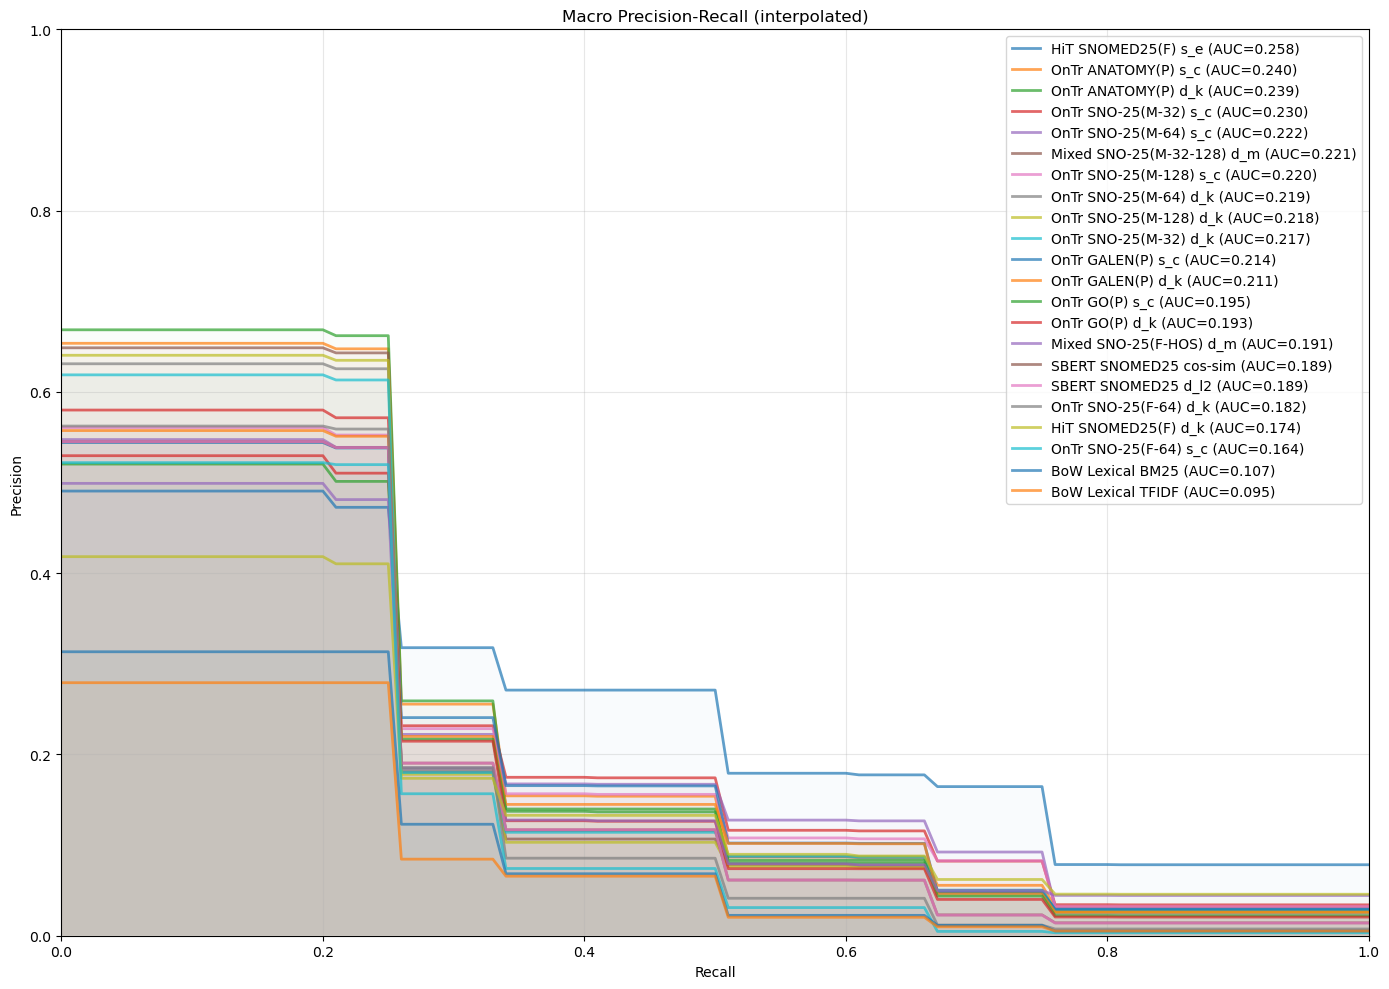

In [65]:
import json
import numpy as np
import matplotlib.pyplot as plt

JSON_PATH = "../data/oov_entity_mentions_multi_target_WEIGHTED_w035_50_q__PR_AUC_POINTS_4_PLOT.json"

with open(JSON_PATH, "r") as f:
  pr_data = json.load(f)

curves = []
for name, d in pr_data.items():
  r = np.asarray(d["recall"], dtype=float)
  p = np.asarray(d["precision"], dtype=float)
  r = np.clip(r, 0.0, 1.0)
  p = np.clip(p, 0.0, 1.0)
  auc = float(np.trapz(p, r))
  curves.append((name, r, p, auc))

curves.sort(key=lambda x: x[3], reverse=True)

fig, ax = plt.subplots(figsize=(14, 10))
for name, r, p, auc in curves:
    ax.plot(r, p, linewidth=2, label=f"{name} (AUC={auc:.3f})", alpha=0.7)
    ax.fill_between(r, p, alpha=0.025)

ax.set_title("Macro Precision-Recall (interpolated)")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)
ax.legend(loc="upper right", frameon=True)
fig.tight_layout()
fig.savefig("./pr_major_W35.png", dpi=300)

plt.show()

fig.savefig("./macro_pr_ALL_W35.png", dpi=300)

Note: These experimental runs were conducted using the data generated during an automated deployment, with NHS_API_KEY not set; as such, the above results refelct the publicly available SNOMED.owl ontology (obtained via Zenodo), rather than the most recent release.

**IMPORTANT TODO: Remember to re-run the notebook with the pinned SNOMED CT version, so that results perfectly reflect those presented within the paper.**

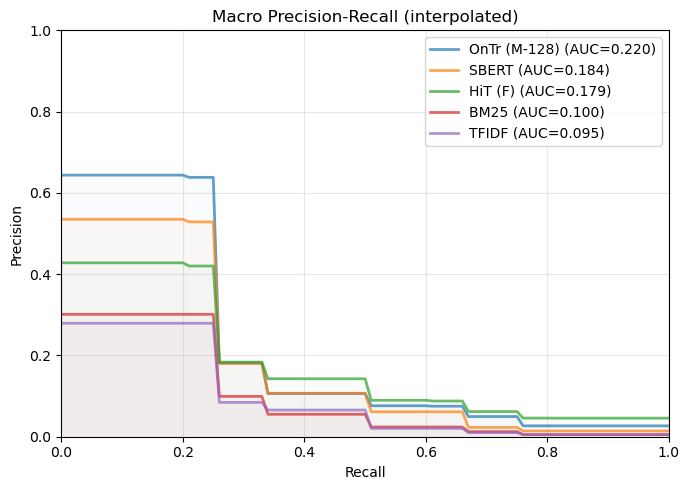

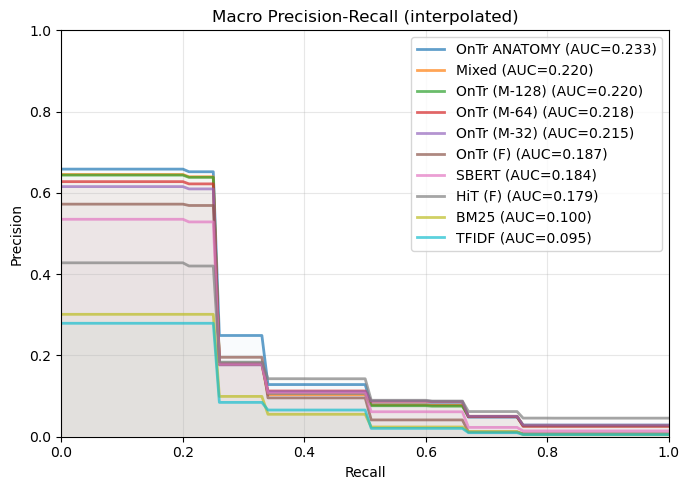

^ Previously obtained figures.

<style>
*{
    line-height: 24px;
}
</style>

# Assumption Testing & Miniature Models (IMPORTANT)

We note that it seems somewhat odd to have a cross-signature domain encoder (ANATOMY) performing seemingly better than domain-tuned variants of OnT. However, if we review the training logs for OnT (provided under /logs/wandb-ont), e.g.

### Training OnT on SNOMED Full, often denoted SNOMED (F), or SNOMED 25 (F):

```
NFO:sentence_transformers.SentenceTransformer:Save model to experiments/OnTr-all-MiniLM-L12-v2-OnT-preprocessed-OnT-file/checkpoint-39504
INFO:sentence_transformers.trainer:Loading best model from experiments/OnTr-all-MiniLM-L12-v2-OnT-preprocessed-OnT-file/checkpoint-39504 (score: 0.16613658234356707).
ERROR:sentence_transformers.trainer:Could not load the best model from experiments/OnTr-all-MiniLM-L12-v2-OnT-preprocessed-OnT-file/checkpoint-39504. Error: HierarchyTransformer.__init__() got an unexpected keyword argument 'trust_remote_code'
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39504/39504 [4:20:19<00:00,  2.53it/s]
{'train_runtime': 15620.3846, 'train_samples_per_second': 80.926, 'train_steps_per_second': 2.529, 'train_loss': 1.1663825307939157, 'epoch': 1.0}
INFO:sentence_transformers.SentenceTransformer:Save model to experiments/OnTr-all-MiniLM-L12-v2-OnT-preprocessed-OnT-file/tmp
0.9
Batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23648/23648 [02:09<00:00, 182.38it/s]
Batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8026/8026 [00:40<00:00, 198.79it/s]
Evaluating nf1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8026/8026 [07:48<00:00, 17.14it/s]
computing metrics.......
H1: 23, H10: 50589, H100: 77036
MRR: 0.12965090277337557, MR: 9979.056314883608
INFO:src.hierarchy_transformers.evaluation.ont_eval:Eval results nf1: {'axiom_kind': 'nf1', 'centri_weight': 0.9, 'H@1': np.float64(0.00017912354072724157), 'H@10': np.float64(0.39398612181958365), 'H@100': np.float64(0.5999548297158166), 'MRR': np.float64(0.12965090277337557), 'MR': np.float64(9979.056314883608), 'median': np.float64(26.0), 'AUC': np.float64(0.9868167379127286)}
Batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3322/3322 [00:17<00:00, 195.27it/s]
Evaluating nf2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3322/3322 [03:13<00:00, 17.15it/s]
computing metrics.......
H1: 16658, H10: 30270, H100: 45213
MRR: 0.3922188667384446, MR: 531.5124080450039
INFO:src.hierarchy_transformers.evaluation.ont_eval:Eval results nf2: {'axiom_kind': 'nf2', 'centri_weight': 0.9, 'H@1': np.float64(0.31340896690560854), 'H@10': np.float64(0.5695095106394988), 'H@100': np.float64(0.8506519162386409), 'MRR': np.float64(0.3922188667384446), 'MR': np.float64(531.5124080450039), 'median': np.float64(7.0), 'AUC': np.float64(0.9993066940007342)}
Batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3661/3661 [00:18<00:00, 197.76it/s]
Evaluating nf3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3661/3661 [04:25<00:00, 13.79it/s]
computing metrics.......
H1: 15437, H10: 23651, H100: 40409
MRR: 0.30439014279676757, MR: 2104.7287970630923
INFO:src.hierarchy_transformers.evaluation.ont_eval:Eval results nf3: {'axiom_kind': 'nf3', 'centri_weight': 0.9, 'H@1': np.float64(0.26358746691710067), 'H@10': np.float64(0.40384188508494834), 'H@100': np.float64(0.6899854862119013), 'MRR': np.float64(0.30439014279676757), 'MR': np.float64(2104.7287970630923), 'median': np.float64(21.0), 'AUC': np.float64(0.9972253586143708)}
Batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1090/1090 [00:05<00:00, 195.70it/s]
Evaluating nf4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1090/1090 [01:03<00:00, 17.17it/s]
computing metrics.......
H1: 15573, H10: 16556, H100: 17291
MRR: 0.9120636230241657, MR: 7.483615494978479
```

### Interpretation and Development of Assumptions

It might be noted that, while the model is learning/re-training, its performance at mapping NF2-NF4 (see the H1 scores) is still much to be desired. There is quite a bit of room for improvement with respect to prediction tasks when compared to the results presented within the original OnT paper. We might note that the H1 score for NF1 is aligned with the expected performance, though this does not seem to be the case for the remaining scores. Several factors could be influencing the model, including (but not limited to) the number of epochs (set to one), the batch size/learning rate, representative class balance (and the sheer size of the ontology -- SNOMED~CT is extremely large, with >= 300k stated axioms, and >= 700k verbalisations when EL-normalised).

In fact, SNOMED~CT is significantly larger and more complex than ANATOMY (uberon), Gene Ontology (GO) and GALEN; and so, our working theory, understanding or **assumption** is that adopting a smaller ontology with a potentially more balanced set of representative normal forms (NF1 $\rightarrow$ NF4) may help to improve the training process. Additionally, we **assume** that the conceptual domain overlap between SNOMED CT and Uberon/ANATOMY is significant. This would explain the performance delta between the two.

Following from our assumptions above, we perform multiple tests which include training miniature models (with varying batch size) and comparing performance between cross-domain queries; i.e. anatomical queries, taken to be the set of axioms that relate to body structure and morphalogical abnormality.

**Our aims, in this instance, are to:**

1. Test whether we can effectively leverage a subset of the original data (a smaller ontology) during model training, such that any experimental results obtained during downstream retrieval can aid in supporting our assumption about ontology size.
2. Test the performance of ANATOMY (along with domain-tuned models) on subsets of the original evaluation data to test whether ANATOMY does, in fact, perform better on anatomical queries; and to what degree this difference is apparent.
3. Aim to Capture enough of the SNOMED CT ontology during during miniature model training such that the performance can generalise **well-enough** to the retrieval tasks on our evaluation data. 

**We accomplish this by:**

1. <u>Training miniature models</u> (with batch sizes: 32, 64, 128) on a subset of SNOMED~CT (with only 36,420 subclass axioms and 13,680 equivalent classes) containing the following concept branches:

* Body Structure
* Clinical Finding
* Event
* Procedure

Then we review the models performance on the validation set *(generated using ELNormalise)*.

2. <u>Dividing our evaluation queries into ANATOMY-related and ANATOMY-unrelated subsets</u>, and then re-running the original experiments agaianst each constituent subset, allowing us to identify whether (and to what degree) our assumption about domain-overlap hold.

**We find that:**

In fact, **yes, the ontology size appears to effect model performance.** Specifically, much larger and more complex ontologies are more challanging for the model to learn effective mappings; and that, **there does appear to be domain overlap between SNOMED CT and ANATOMY**, helping to support both of our assumptions in this case.

Experimental implementations and results are provided below.

### Assumption Testing

#### Experiment: Testing ANATOMY Encoder with Procedure Data

*(4 queries contained within the subset)*

**Example Question:** Is combined therapy more effective than growth hormone or hyperbaric oxygen alone in the healing of left ischemic and non-ischemic colonic anastomoses?

**Entity Mention:** hyperbaric oxygen

**Has Target:** Hyperbaric oxygen therapy (procedure) http://snomed.info/id/18678000

**Reuslts:**

```
Model      Variant      MRR    H@1    H@3    H@5    Med      MR     R@100
=========================================================================
BoW     TFIDF           0.37   0.25   0.25   0.50   5.00    6.25    1.00 
BoW     BM25            0.50   0.25   0.75   0.75   2.00   16.50    1.00 
SBERT   cos-sim         0.66   0.50   0.75   0.75   1.50    2.75    1.00 
HiT     SNO-23(F)       0.46   0.25   0.75   0.75   2.50   81.50    0.75 
HiT     SNO-25(F)       0.75   0.75   0.75   0.75   1.00   197.75   0.75 
OnTr    GALEN(P)        0.65   0.50   0.75   0.75   1.50    4.00    1.00 
OnTr    ANATOMY(P)      0.65   0.50   0.75   0.75   1.50    3.50    1.00 
OnTr    GO(P)           0.44   0.25   0.50   0.75   3.00   101.75   0.75 
OnTr    SNO-25(F-64)    0.79   0.75   0.75   0.75   1.00    2.25    1.00 
OnTr    SNO-25(M-32)    0.65   0.50   0.75   1.00   2.00    2.25    1.00 
OnTr    SNO-25(M-64)    0.63   0.50   0.75   1.00   2.00    2.50    1.00 
OnTr    SNO-25(M-128)   0.65   0.50   0.75   0.75   1.50    3.25    1.00 
Mixed   D_m(F)          0.75   0.75   0.75   0.75   1.00   48.50    0.75 
Mixed   D_m(M)          0.63   0.50   0.75   1.00   2.00    2.50    1.00 
```

Relative performance of ANATOMY is worse compared to SNOMED (domain-tuned) for procedure data.

##### Procedure Subset Data

In [90]:
# see: https://stackoverflow.com/questions/61403510/create-tabular-format-records-from-the-json-in-jupyter-notebook
import json
from json2html import *
from IPython.display import HTML
data = load_json(Path("../data/subset_procedure_original.json"))
HTML(json2html.convert(json = data))

# Note: repeat this code-block and change the subset dataset to inspect the various subsets in ../data/subset_*.json.

##### Procedure Subset Experimental Run

In [77]:
data_query_mapping_for_subset_procedure = QueryObjectMapping(Path("../data//subset_procedure_original.json"))
equiv_queries, subsumpt_queries = data_query_mapping_for_subset_procedure.get_queries()

oov_single_target_queries = copy.deepcopy(subsumpt_queries)
for q in oov_single_target_queries:
    q._ancestors = []
    q._parents = []

# OOV QUERIES (SINGLE TARGET) [4]

# PREP TABLE START #
import latextable
from latextable import texttable
experiment_one_table = texttable.Texttable()
experiment_one_table.set_deco(texttable.Texttable.HEADER)
experiment_one_table.set_precision(2)
experiment_one_table.set_cols_dtype(['t', 't', 'f', 'f', 'f', 'f', 'f', 'f', 'f'])
experiment_one_table.set_cols_align(["l", "l", "c", "c", "c", "c", "c", "c", "c"])
experiment_one_table.header(["Model", "Variant", "MRR", "H@1", "H@3", "H@5", "Med", "MR", "R@100"])
# END-PREP TABLE #

ks      = [1, 3, 5, 100, len(entity_verbalisation_list)]
MAX_K   = max(ks)

all_results = {}

for model_name, model in models_dict_single_target.items():
    
    # init accumulators
    results = {
      "MRR": 0.0, # Mean Reciprical Rank
      **{f"H@{k}": 0.0 for k in ks}, # Hits@k
      **{f"P@{k}": 0.0 for k in ks}, # Precision@k
      **{f"R@{k}": 0.0 for k in ks}, # Recall@k
      **{f"F1@{k}": 0.0 for k in ks}, # F1@k
      "MR": 0.0 # Mean Rank
    }
    # PR-AUC, Median Rank & Coverage are calculated during the test procedure
    hit_count = 0 # for coverage
    all_ranks = [] # for median rank

    for q_idx, query in enumerate(oov_single_target_queries):
        
        qstr = query.get_query_string()
        gold_iri = query.get_target_iri()

        ranked_results = [] # empty lists (are unlikely to exist) but are treated as full misses
        
        # TODO: replace with match (?) - i.e. switch
        if isinstance(model, HiTRetriever):
          if model._score_fn == entity_subsumption:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=True, model=model._model, weight=0.0)
          elif model._score_fn == batch_poincare_dist_with_adaptive_curv_k: 
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=False, model=model._model)
        #
        elif isinstance(model, OnTRetriever):
          if model._score_fn == concept_subsumption:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=True, model=model._model, weight=0.0)
          elif model._score_fn == batch_poincare_dist_with_adaptive_curv_k: 
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=False, model=model._model)
        #
        elif isinstance(model, SBERTRetriever):
          if model._score_fn == batch_cosine_similarity:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=True)
          else:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=False)
        #
        elif isinstance(model, BM25Retriever):
          ranked_results = model.retrieve(qstr, top_k=None)
        #
        elif isinstance(model, TFIDFRetriever):
          ranked_results = model.retrieve(qstr, top_k=None)
        #
        elif isinstance(model, MixedModelRetriever):
           ranked_results = model.retrieve(qstr, top_k=None)
        #
        elif isinstance(model, CustomMixedModelRetriever):
           ranked_results = model.retrieve(qstr, top_k=MAX_K)
        #
        else:
           raise ValueError("No appropriate retriever has been set.")

        retrieved_iris = [iri for (_, iri, _, _) in ranked_results] # type: ignore

        # MRR & MeanRank
        rank_pos = None
        for rank_idx, iri in enumerate(retrieved_iris, start=1):
            if iri == gold_iri:
                rank_pos = rank_idx
                results["MRR"] += 1.0 / rank_idx
                results["MR"] += rank_idx
                break
        
        # for calculating coverage
        if rank_pos is not None:
           hit_count += 1

        # include a penalty to appropriately offset the MR
        # rather than artifically inflating the performance
        # by simply dropping queries that do not contain 
        if rank_pos is None:
            results["MR"] += MAX_K + 1 # penalty: rank := MAX_K + 1

        for k in ks:
            hit = 1 if (rank_pos is not None and rank_pos <= k) else 0
            results[f"H@{k}"] += hit # Hits@K
            p_at_k = hit / k # Precision@K
            results[f"P@{k}"] += p_at_k
            r_at_k = 1 if (rank_pos is not None and rank_pos <= k) else 0
            results[f"R@{k}"] += r_at_k
            if (p_at_k + r_at_k) > 0:
               results[f"F1@{k}"] += 2 * (p_at_k * r_at_k) / (p_at_k + r_at_k)

        final_rank = rank_pos if rank_pos is not None else MAX_K + 1
        all_ranks.append(final_rank)

    # normalise over queries & compute coverage
    N = len(oov_single_target_queries)
    normalized = {metric: value / N for metric, value in results.items()}
    normalized['Cov'] = (hit_count / N) # calculate the coverage of this model
    normalized['Med'] = statistics.median(all_ranks) # median rank
    # area under precision-recall curve (trapezodial rule)
    recall_at_k_xs    = [normalized[f"R@{k}"] for k in ks]
    # check for monotonic recall
    if any(r2 < r1 for r1, r2 in zip(recall_at_k_xs, recall_at_k_xs[1:])):
        raise ValueError(f"Recall must be non-decreasing for PR-AUC")
    precision_at_k_xs = [normalized[f"P@{k}"] for k in ks]
    normalized["AUC"] = float(sk_auc(recall_at_k_xs, precision_at_k_xs))

    print(f"Model: {model_name}")
    print(f"  MRR:    {normalized['MRR']:.2f}")
    for k in [1, 3, 5]:
        print(f"  H@{k}:    {normalized[f'H@{k}']:.2f}")
    print(f"  Med:    {normalized['Med']:.1f}")
    print(f"  MR:     {normalized['MR']:.1f}")
    print(f"  R@100:  {normalized['R@100']}")
    print("-"*60)
    
    model_metric_string = model_name.split()
    experiment_one_table.add_row([model_metric_string[0], model_metric_string[1], 
                                  normalized['MRR'], 
                                  normalized['H@1'], normalized['H@3'], normalized['H@5'], 
                                  normalized['Med'], normalized['MR'], normalized['R@100']])

    all_results[model_name] = normalized

output_file = '../data/ANATOMY_ASSUMPTION_oov_entity_mentions_single_target_procedure_data_4_queries.json'
with open(output_file, 'w') as f:
    json.dump(all_results, f, indent=2)

print(f"All results saved to {output_file}")

print(f"Printing table: \n\n")

print(experiment_one_table.draw())

print("\n\n Printing LaTeX: \n\n")

print(latextable.draw_latex(
    table=experiment_one_table, 
    caption="Testing the ANATOMY assumption by assessing retrieval performance of OOV entity mentions measured on the procedure subset (4 Queries)", 
    use_booktabs=True, position="H", caption_above=True, caption_short="Single target performance of OOV mentions", 
    label="tab:single-target-oov"
  )
)

Model: BoW TFIDF
  MRR:    0.37
  H@1:    0.25
  H@3:    0.25
  H@5:    0.50
  Med:    5.0
  MR:     6.2
  R@100:  1.0
------------------------------------------------------------
Model: BoW BM25
  MRR:    0.59
  H@1:    0.50
  H@3:    0.75
  H@5:    0.75
  Med:    2.0
  MR:     33.8
  R@100:  0.75
------------------------------------------------------------
Model: SBERT cos-sim
  MRR:    0.79
  H@1:    0.75
  H@3:    0.75
  H@5:    0.75
  Med:    1.0
  MR:     2.5
  R@100:  1.0
------------------------------------------------------------
Model: HiT SNO-25(F)
  MRR:    0.63
  H@1:    0.50
  H@3:    0.75
  H@5:    0.75
  Med:    1.5
  MR:     197.2
  R@100:  0.75
------------------------------------------------------------
Model: OnTr GALEN(P)
  MRR:    0.65
  H@1:    0.50
  H@3:    0.75
  H@5:    0.75
  Med:    1.5
  MR:     4.0
  R@100:  1.0
------------------------------------------------------------
Model: OnTr ANATOMY(P)
  MRR:    0.78
  H@1:    0.75
  H@3:    0.75
  H@5:    0.75
 

### Experiment: Testing ANATOMY Assumption with Substance Subset

**NOTE: SNOMED Mini has not been exposed (trained on) substance data either.**

*(12 queries)*

**Example:**

**Question:** "A 6-year-old boy is brought to the emergency department by his mother for worsening wheezing and shortness of breath over the past day. He has not had a fever, cough, vomiting, or diarrhea. He has asthma and eczema. He uses a glucocorticoid inhaler and an albuterol inhaler but has missed his medications for the past week while on vacation. He appears uncomfortable. His temperature is 36°C (96.8°F), pulse is 120/min, respirations are 40/min, and blood pressure is 100/80. Expiratory and inspiratory wheezing is heard throughout both lung fields. There are moderate intercostal and subcostal retractions and a decreased inspiratory to expiratory ratio. Nebulized albuterol and ipratropium treatments and intravenous methylprednisolone are given in the emergency department for a presumed asthma exacerbation. One hour later, the child is limp and lethargic. Magnesium sulfate is administered. His temperature is 36°C (96.8°F), pulse is 150/min, respirations are 22/min, and blood pressure is 100/70. No wheezing is heard on repeat pulmonary examination. Which of the following is the most appropriate next step in management?
      
**Entity Mention:** intravenous methylprednisolone

**Has Target:** "Methylprednisolone (substance) (http://snomed.info/id/116593003)

**Results:**

```
Model      Variant      MRR    H@1    H@3    H@5     Med        MR       R@100
==============================================================================
BoW     TFIDF           0.25   0.17   0.33   0.33   878.00   125139.00   0.50 
BoW     BM25            0.50   0.50   0.50   0.50   141.00   86773.50    0.50 
SBERT   cos-sim         0.65   0.50   0.67   0.83    1.50      2.83      1.00 
HiT     SNO-23(F)       0.32   0.17   0.33   0.50    6.00      21.83     1.00 
HiT     SNO-25(F)       0.39   0.17   0.50   0.67    3.00      13.00     1.00 
OnTr    GALEN(P)        0.53   0.33   0.67   0.83    2.50      3.00      1.00 
OnTr    ANATOMY(P)      0.61   0.50   0.67   0.67    2.00      3.17      1.00 
OnTr    GO(P)           0.57   0.50   0.50   0.67    2.50      5.83      1.00 
OnTr    SNO-25(F-64)    0.65   0.50   0.67   0.83    1.50      2.83      1.00 
OnTr    SNO-25(M-32)    0.57   0.33   0.83   1.00    2.50      2.33      1.00 
OnTr    SNO-25(M-64)    0.60   0.33   0.83   1.00    2.00      2.17      1.00 
OnTr    SNO-25(M-128)   0.60   0.33   0.83   1.00    2.00      2.17      1.00 
Mixed   D_m(F)          0.53   0.33   0.67   0.67    2.00      8.00      1.00 
Mixed   D_m(M)          0.57   0.33   0.83   1.00    2.50      2.33      1.00
```

##### Substance Subset Data

In [79]:
# UNCOMMENT TO SEE THE UNDERLYING DATA

# import json
# from json2html import *
# from IPython.display import HTML
# data = load_json(Path("../data/subset_substance_original.json"))
# HTML(json2html.convert(json = data))

##### Substance Subset Experimental Run

In [80]:
data_query_mapping_for_subset_substance = QueryObjectMapping(Path("../data/subset_substance_original.json"))
equiv_queries, subsumpt_queries = data_query_mapping_for_subset_substance.get_queries()

oov_single_target_queries = copy.deepcopy(subsumpt_queries)
for q in oov_single_target_queries:
    q._ancestors = []
    q._parents = []

# OOV QUERIES (SINGLE TARGET) [12]

# PREP TABLE START #
import latextable
from latextable import texttable
experiment_one_table = texttable.Texttable()
experiment_one_table.set_deco(texttable.Texttable.HEADER)
experiment_one_table.set_precision(2)
experiment_one_table.set_cols_dtype(['t', 't', 'f', 'f', 'f', 'f', 'f', 'f', 'f'])
experiment_one_table.set_cols_align(["l", "l", "c", "c", "c", "c", "c", "c", "c"])
experiment_one_table.header(["Model", "Variant", "MRR", "H@1", "H@3", "H@5", "Med", "MR", "R@100"])
# END-PREP TABLE #

ks      = [1, 3, 5, 100, len(entity_verbalisation_list)]
MAX_K   = max(ks)

all_results = {}

for model_name, model in models_dict_single_target.items():
    
    # init accumulators
    results = {
      "MRR": 0.0, # Mean Reciprical Rank
      **{f"H@{k}": 0.0 for k in ks}, # Hits@k
      **{f"P@{k}": 0.0 for k in ks}, # Precision@k
      **{f"R@{k}": 0.0 for k in ks}, # Recall@k
      **{f"F1@{k}": 0.0 for k in ks}, # F1@k
      "MR": 0.0 # Mean Rank
    }
    # PR-AUC, Median Rank & Coverage are calculated during the test procedure
    hit_count = 0 # for coverage
    all_ranks = [] # for median rank

    for q_idx, query in enumerate(oov_single_target_queries):
        
        qstr = query.get_query_string()
        gold_iri = query.get_target_iri()

        ranked_results = [] # empty lists (are unlikely to exist) but are treated as full misses
        
        # TODO: replace with match (?) - i.e. switch
        if isinstance(model, HiTRetriever):
          if model._score_fn == entity_subsumption:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=True, model=model._model, weight=0.0)
          elif model._score_fn == batch_poincare_dist_with_adaptive_curv_k: 
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=False, model=model._model)
        #
        elif isinstance(model, OnTRetriever):
          if model._score_fn == concept_subsumption:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=True, model=model._model, weight=0.0)
          elif model._score_fn == batch_poincare_dist_with_adaptive_curv_k: 
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=False, model=model._model)
        #
        elif isinstance(model, SBERTRetriever):
          if model._score_fn == batch_cosine_similarity:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=True)
          else:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=False)
        #
        elif isinstance(model, BM25Retriever):
          ranked_results = model.retrieve(qstr, top_k=None)
        #
        elif isinstance(model, TFIDFRetriever):
          ranked_results = model.retrieve(qstr, top_k=None)
        #
        elif isinstance(model, MixedModelRetriever):
           ranked_results = model.retrieve(qstr, top_k=None)
        #
        elif isinstance(model, CustomMixedModelRetriever):
           ranked_results = model.retrieve(qstr, top_k=MAX_K)
        #
        else:
           raise ValueError("No appropriate retriever has been set.")

        retrieved_iris = [iri for (_, iri, _, _) in ranked_results] # type: ignore

        # MRR & MeanRank
        rank_pos = None
        for rank_idx, iri in enumerate(retrieved_iris, start=1):
            if iri == gold_iri:
                rank_pos = rank_idx
                results["MRR"] += 1.0 / rank_idx
                results["MR"] += rank_idx
                break
        
        # for calculating coverage
        if rank_pos is not None:
           hit_count += 1

        # include a penalty to appropriately offset the MR
        # rather than artifically inflating the performance
        # by simply dropping queries that do not contain 
        if rank_pos is None:
            results["MR"] += MAX_K + 1 # penalty: rank := MAX_K + 1

        for k in ks:
            hit = 1 if (rank_pos is not None and rank_pos <= k) else 0
            results[f"H@{k}"] += hit # Hits@K
            p_at_k = hit / k # Precision@K
            results[f"P@{k}"] += p_at_k
            r_at_k = 1 if (rank_pos is not None and rank_pos <= k) else 0
            results[f"R@{k}"] += r_at_k
            if (p_at_k + r_at_k) > 0:
               results[f"F1@{k}"] += 2 * (p_at_k * r_at_k) / (p_at_k + r_at_k)

        final_rank = rank_pos if rank_pos is not None else MAX_K + 1
        all_ranks.append(final_rank)

    # normalise over queries & compute coverage
    N = len(oov_single_target_queries)
    normalized = {metric: value / N for metric, value in results.items()}
    normalized['Cov'] = (hit_count / N) # calculate the coverage of this model
    normalized['Med'] = statistics.median(all_ranks) # median rank
    # area under precision-recall curve (trapezodial rule)
    recall_at_k_xs    = [normalized[f"R@{k}"] for k in ks]
    # check for monotonic recall
    if any(r2 < r1 for r1, r2 in zip(recall_at_k_xs, recall_at_k_xs[1:])):
        raise ValueError(f"Recall must be non-decreasing for PR-AUC")
    precision_at_k_xs = [normalized[f"P@{k}"] for k in ks]
    normalized["AUC"] = float(sk_auc(recall_at_k_xs, precision_at_k_xs))

    print(f"Model: {model_name}")
    print(f"  MRR:    {normalized['MRR']:.2f}")
    for k in [1, 3, 5]:
        print(f"  H@{k}:    {normalized[f'H@{k}']:.2f}")
    print(f"  Med:    {normalized['Med']:.1f}")
    print(f"  MR:     {normalized['MR']:.1f}")
    print(f"  R@100:  {normalized['R@100']}")
    print("-"*60)
    
    model_metric_string = model_name.split()
    experiment_one_table.add_row([model_metric_string[0], model_metric_string[1], 
                                  normalized['MRR'], 
                                  normalized['H@1'], normalized['H@3'], normalized['H@5'], 
                                  normalized['Med'], normalized['MR'], normalized['R@100']])

    all_results[model_name] = normalized

output_file = '../data/ANATOMY_ASSUMPTION_oov_entity_mentions_single_target_substance_data_12_queries.json'
with open(output_file, 'w') as f:
    json.dump(all_results, f, indent=2)

print(f"All results saved to {output_file}")

print(f"Printing table: \n\n")

print(experiment_one_table.draw())

print("\n\n Printing LaTeX: \n\n")

print(latextable.draw_latex(
    table=experiment_one_table, 
    caption="Testing the ANATOMY assumption by assessing retrieval performance of OOV entity mentions measured on the substance subset (12 Queries)", 
    use_booktabs=True, position="H", caption_above=True, caption_short="Single target performance of OOV mentions", 
    label="tab:single-target-oov"
  )
)

Model: BoW TFIDF
  MRR:    0.25
  H@1:    0.17
  H@3:    0.33
  H@5:    0.33
  Med:    879.0
  MR:     125535.3
  R@100:  0.5
------------------------------------------------------------
Model: BoW BM25
  MRR:    0.50
  H@1:    0.50
  H@3:    0.50
  H@5:    0.50
  Med:    144.5
  MR:     86984.8
  R@100:  0.5
------------------------------------------------------------
Model: SBERT cos-sim
  MRR:    0.65
  H@1:    0.50
  H@3:    0.67
  H@5:    0.83
  Med:    1.5
  MR:     2.8
  R@100:  1.0
------------------------------------------------------------
Model: HiT SNO-25(F)
  MRR:    0.39
  H@1:    0.17
  H@3:    0.50
  H@5:    0.67
  Med:    3.0
  MR:     13.0
  R@100:  1.0
------------------------------------------------------------
Model: OnTr GALEN(P)
  MRR:    0.53
  H@1:    0.33
  H@3:    0.67
  H@5:    0.83
  Med:    2.5
  MR:     3.0
  R@100:  1.0
------------------------------------------------------------
Model: OnTr ANATOMY(P)
  MRR:    0.61
  H@1:    0.50
  H@3:    0.67
  H@5: 

### Testing ANATOMY Assumption with Disorder data

*(6 queries)*

**Example Question:** "A 62-year-old man presents with bright red blood in his stool which occurred 2 times this week. He denies fever, weight loss, pain, pruritus or urinary symptoms. Past medical history is significant for gastroesophageal reflux disease, and recent appendicitis, status post laparoscopic appendectomy complicated by delirium tremens. His vitals are a temperature of 37.0°C (98.6°F), blood pressure of 130/80 mm Hg, pulse of 78/min, and respiratory rate of 12/min. Physical examination reveals a distended abdomen with shifting dullness on percussion. In addition, multiple purple spider web-like lesions are present on the chest and arms, which blanch when pressure is applied. Fecal occult blood test is negative. On anoscopy, a non-tender, dilated vascular protrusion is noted superior to the pectinate line. Which of the following is most likely true about this patient’s current symptoms?",

**Entity Mention:** gastroesophageal reflux

**Has Target:** Gastroesophageal reflux disease (disorder)

**Results:**

```
Model      Variant      MRR    H@1    H@3    H@5     Med        MR      R@100
=============================================================================
BoW     TFIDF           0.21   0.17   0.25   0.25   188.00   93884.67   0.42 
BoW     BM25            0.16   0.08   0.17   0.25   89.50    54539.17   0.50 
SBERT   cos-sim         0.54   0.42   0.67   0.67    2.50     12.67     0.92 
HiT     SNO-23(F)       0.52   0.50   0.50   0.50    5.50     86.33     0.75 
HiT     SNO-25(F)       0.39   0.33   0.42   0.42   25.50     284.00    0.75 
OnTr    GALEN(P)        0.42   0.25   0.50   0.67    3.50     18.58     0.92 
OnTr    ANATOMY(P)      0.62   0.50   0.58   0.83    1.50      4.58     1.00 
OnTr    GO(P)           0.32   0.17   0.33   0.50    5.50     11.92     1.00 
OnTr    SNO-25(F-64)    0.53   0.42   0.67   0.67    2.50     32.92     0.92 
OnTr    SNO-25(M-32)    0.79   0.67   0.92   0.92    1.00      9.50     1.00 
OnTr    SNO-25(M-64)    0.83   0.75   0.92   0.92    1.00     12.00     0.92 
OnTr    SNO-25(M-128)   0.88   0.83   0.92   0.92    1.00     16.58     0.92 
Mixed   D_m(F)          0.41   0.33   0.42   0.50    7.00     133.83    0.75 
Mixed   D_m(M)          0.92   0.92   0.92   0.92    1.00     12.33     0.92 
```

##### Disorder Data

In [81]:
# UNCOMMENT TO SEE THE UNDERLYING DATA

# import json
# from json2html import *
# from IPython.display import HTML
# data = load_json(Path("../data/subset_disorder_original.json"))
# HTML(json2html.convert(json = data))

##### Experimental Run (Disorder Data)

In [82]:
data_query_mapping_for_subset_disorder = QueryObjectMapping(Path("../data/subset_disorder_original.json"))
equiv_queries, subsumpt_queries = data_query_mapping_for_subset_disorder.get_queries()

oov_single_target_queries = copy.deepcopy(subsumpt_queries)
for q in oov_single_target_queries:
    q._ancestors = []
    q._parents = []

# OOV QUERIES (SINGLE TARGET) [6]

# PREP TABLE START #
import latextable
from latextable import texttable
experiment_one_table = texttable.Texttable()
experiment_one_table.set_deco(texttable.Texttable.HEADER)
experiment_one_table.set_precision(2)
experiment_one_table.set_cols_dtype(['t', 't', 'f', 'f', 'f', 'f', 'f', 'f', 'f'])
experiment_one_table.set_cols_align(["l", "l", "c", "c", "c", "c", "c", "c", "c"])
experiment_one_table.header(["Model", "Variant", "MRR", "H@1", "H@3", "H@5", "Med", "MR", "R@100"])
# END-PREP TABLE #

ks      = [1, 3, 5, 100, len(entity_verbalisation_list)]
MAX_K   = max(ks)

all_results = {}

for model_name, model in models_dict_single_target.items():
    
    # init accumulators
    results = {
      "MRR": 0.0, # Mean Reciprical Rank
      **{f"H@{k}": 0.0 for k in ks}, # Hits@k
      **{f"P@{k}": 0.0 for k in ks}, # Precision@k
      **{f"R@{k}": 0.0 for k in ks}, # Recall@k
      **{f"F1@{k}": 0.0 for k in ks}, # F1@k
      "MR": 0.0 # Mean Rank
    }
    # PR-AUC, Median Rank & Coverage are calculated during the test procedure
    hit_count = 0 # for coverage
    all_ranks = [] # for median rank

    for q_idx, query in enumerate(oov_single_target_queries):
        
        qstr = query.get_query_string()
        gold_iri = query.get_target_iri()

        ranked_results = [] # empty lists (are unlikely to exist) but are treated as full misses
        
        # TODO: replace with match (?) - i.e. switch
        if isinstance(model, HiTRetriever):
          if model._score_fn == entity_subsumption:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=True, model=model._model, weight=0.0)
          elif model._score_fn == batch_poincare_dist_with_adaptive_curv_k: 
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=False, model=model._model)
        #
        elif isinstance(model, OnTRetriever):
          if model._score_fn == concept_subsumption:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=True, model=model._model, weight=0.0)
          elif model._score_fn == batch_poincare_dist_with_adaptive_curv_k: 
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=False, model=model._model)
        #
        elif isinstance(model, SBERTRetriever):
          if model._score_fn == batch_cosine_similarity:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=True)
          else:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=False)
        #
        elif isinstance(model, BM25Retriever):
          ranked_results = model.retrieve(qstr, top_k=None)
        #
        elif isinstance(model, TFIDFRetriever):
          ranked_results = model.retrieve(qstr, top_k=None)
        #
        elif isinstance(model, MixedModelRetriever):
           ranked_results = model.retrieve(qstr, top_k=None)
        #
        elif isinstance(model, CustomMixedModelRetriever):
           ranked_results = model.retrieve(qstr, top_k=MAX_K)
        #
        else:
           raise ValueError("No appropriate retriever has been set.")

        retrieved_iris = [iri for (_, iri, _, _) in ranked_results] # type: ignore

        # MRR & MeanRank
        rank_pos = None
        for rank_idx, iri in enumerate(retrieved_iris, start=1):
            if iri == gold_iri:
                rank_pos = rank_idx
                results["MRR"] += 1.0 / rank_idx
                results["MR"] += rank_idx
                break
        
        # for calculating coverage
        if rank_pos is not None:
           hit_count += 1

        # include a penalty to appropriately offset the MR
        # rather than artifically inflating the performance
        # by simply dropping queries that do not contain 
        if rank_pos is None:
            results["MR"] += MAX_K + 1 # penalty: rank := MAX_K + 1

        for k in ks:
            hit = 1 if (rank_pos is not None and rank_pos <= k) else 0
            results[f"H@{k}"] += hit # Hits@K
            p_at_k = hit / k # Precision@K
            results[f"P@{k}"] += p_at_k
            r_at_k = 1 if (rank_pos is not None and rank_pos <= k) else 0
            results[f"R@{k}"] += r_at_k
            if (p_at_k + r_at_k) > 0:
               results[f"F1@{k}"] += 2 * (p_at_k * r_at_k) / (p_at_k + r_at_k)

        final_rank = rank_pos if rank_pos is not None else MAX_K + 1
        all_ranks.append(final_rank)

    # normalise over queries & compute coverage
    N = len(oov_single_target_queries)
    normalized = {metric: value / N for metric, value in results.items()}
    normalized['Cov'] = (hit_count / N) # calculate the coverage of this model
    normalized['Med'] = statistics.median(all_ranks) # median rank
    # area under precision-recall curve (trapezodial rule)
    recall_at_k_xs    = [normalized[f"R@{k}"] for k in ks]
    # check for monotonic recall
    if any(r2 < r1 for r1, r2 in zip(recall_at_k_xs, recall_at_k_xs[1:])):
        raise ValueError(f"Recall must be non-decreasing for PR-AUC")
    precision_at_k_xs = [normalized[f"P@{k}"] for k in ks]
    normalized["AUC"] = float(sk_auc(recall_at_k_xs, precision_at_k_xs))

    print(f"Model: {model_name}")
    print(f"  MRR:    {normalized['MRR']:.2f}")
    for k in [1, 3, 5]:
        print(f"  H@{k}:    {normalized[f'H@{k}']:.2f}")
    print(f"  Med:    {normalized['Med']:.1f}")
    print(f"  MR:     {normalized['MR']:.1f}")
    print(f"  R@100:  {normalized['R@100']}")
    print("-"*60)
    
    model_metric_string = model_name.split()
    experiment_one_table.add_row([model_metric_string[0], model_metric_string[1], 
                                  normalized['MRR'], 
                                  normalized['H@1'], normalized['H@3'], normalized['H@5'], 
                                  normalized['Med'], normalized['MR'], normalized['R@100']])

    all_results[model_name] = normalized

output_file = '../data/ANATOMY_ASSUMPTION_oov_entity_mentions_single_target_disorder_data_6_queries.json'
with open(output_file, 'w') as f:
    json.dump(all_results, f, indent=2)

print(f"All results saved to {output_file}")

print(f"Printing table: \n\n")

print(experiment_one_table.draw())

print("\n\n Printing LaTeX: \n\n")

print(latextable.draw_latex(
    table=experiment_one_table, 
    caption="Testing the ANATOMY assumption by assessing retrieval performance of OOV entity mentions measured on the disorder subset (6 Queries)", 
    use_booktabs=True, position="H", caption_above=True, caption_short="Single target performance of OOV mentions", 
    label="tab:single-target-oov"
  )
)

Model: BoW TFIDF
  MRR:    0.21
  H@1:    0.17
  H@3:    0.25
  H@5:    0.25
  Med:    188.5
  MR:     94187.8
  R@100:  0.4166666666666667
------------------------------------------------------------
Model: BoW BM25
  MRR:    0.16
  H@1:    0.08
  H@3:    0.17
  H@5:    0.25
  Med:    117.5
  MR:     54826.0
  R@100:  0.5
------------------------------------------------------------
Model: SBERT cos-sim
  MRR:    0.54
  H@1:    0.42
  H@3:    0.67
  H@5:    0.67
  Med:    2.5
  MR:     12.7
  R@100:  0.9166666666666666
------------------------------------------------------------
Model: HiT SNO-25(F)
  MRR:    0.39
  H@1:    0.33
  H@3:    0.42
  H@5:    0.42
  Med:    25.5
  MR:     282.8
  R@100:  0.75
------------------------------------------------------------
Model: OnTr GALEN(P)
  MRR:    0.42
  H@1:    0.25
  H@3:    0.50
  H@5:    0.67
  Med:    3.5
  MR:     18.6
  R@100:  0.9166666666666666
------------------------------------------------------------
Model: OnTr ANATOMY(P)
  M

### Testing ANATOMY Assumption with Device Examples (Physical Device)

Only 2 queries, not well enough represented to derive any meaningful interpretation.

In [83]:
data_query_mapping_for_subset_devices = QueryObjectMapping(Path("../data/subset_devices_original.json"))
equiv_queries, subsumpt_queries = data_query_mapping_for_subset_devices.get_queries()

oov_single_target_queries = copy.deepcopy(subsumpt_queries)
for q in oov_single_target_queries:
    q._ancestors = []
    q._parents = []

# OOV QUERIES (SINGLE TARGET) [2]

# PREP TABLE START #
import latextable
from latextable import texttable
experiment_one_table = texttable.Texttable()
experiment_one_table.set_deco(texttable.Texttable.HEADER)
experiment_one_table.set_precision(2)
experiment_one_table.set_cols_dtype(['t', 't', 'f', 'f', 'f', 'f', 'f', 'f', 'f'])
experiment_one_table.set_cols_align(["l", "l", "c", "c", "c", "c", "c", "c", "c"])
experiment_one_table.header(["Model", "Variant", "MRR", "H@1", "H@3", "H@5", "Med", "MR", "R@100"])
# END-PREP TABLE #

ks      = [1, 3, 5, 100, len(entity_verbalisation_list)]
MAX_K   = max(ks)

all_results = {}

for model_name, model in models_dict_single_target.items():
    
    # init accumulators
    results = {
      "MRR": 0.0, # Mean Reciprical Rank
      **{f"H@{k}": 0.0 for k in ks}, # Hits@k
      **{f"P@{k}": 0.0 for k in ks}, # Precision@k
      **{f"R@{k}": 0.0 for k in ks}, # Recall@k
      **{f"F1@{k}": 0.0 for k in ks}, # F1@k
      "MR": 0.0 # Mean Rank
    }
    # PR-AUC, Median Rank & Coverage are calculated during the test procedure
    hit_count = 0 # for coverage
    all_ranks = [] # for median rank

    for q_idx, query in enumerate(oov_single_target_queries):
        
        qstr = query.get_query_string()
        gold_iri = query.get_target_iri()

        ranked_results = [] # empty lists (are unlikely to exist) but are treated as full misses
        
        # TODO: replace with match (?) - i.e. switch
        if isinstance(model, HiTRetriever):
          if model._score_fn == entity_subsumption:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=True, model=model._model, weight=0.0)
          elif model._score_fn == batch_poincare_dist_with_adaptive_curv_k: 
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=False, model=model._model)
        #
        elif isinstance(model, OnTRetriever):
          if model._score_fn == concept_subsumption:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=True, model=model._model, weight=0.0)
          elif model._score_fn == batch_poincare_dist_with_adaptive_curv_k: 
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=False, model=model._model)
        #
        elif isinstance(model, SBERTRetriever):
          if model._score_fn == batch_cosine_similarity:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=True)
          else:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=False)
        #
        elif isinstance(model, BM25Retriever):
          ranked_results = model.retrieve(qstr, top_k=None)
        #
        elif isinstance(model, TFIDFRetriever):
          ranked_results = model.retrieve(qstr, top_k=None)
        #
        elif isinstance(model, MixedModelRetriever):
           ranked_results = model.retrieve(qstr, top_k=None)
        #
        elif isinstance(model, CustomMixedModelRetriever):
           ranked_results = model.retrieve(qstr, top_k=MAX_K)
        #
        else:
           raise ValueError("No appropriate retriever has been set.")

        retrieved_iris = [iri for (_, iri, _, _) in ranked_results] # type: ignore

        # MRR & MeanRank
        rank_pos = None
        for rank_idx, iri in enumerate(retrieved_iris, start=1):
            if iri == gold_iri:
                rank_pos = rank_idx
                results["MRR"] += 1.0 / rank_idx
                results["MR"] += rank_idx
                break
        
        # for calculating coverage
        if rank_pos is not None:
           hit_count += 1

        # include a penalty to appropriately offset the MR
        # rather than artifically inflating the performance
        # by simply dropping queries that do not contain 
        if rank_pos is None:
            results["MR"] += MAX_K + 1 # penalty: rank := MAX_K + 1

        for k in ks:
            hit = 1 if (rank_pos is not None and rank_pos <= k) else 0
            results[f"H@{k}"] += hit # Hits@K
            p_at_k = hit / k # Precision@K
            results[f"P@{k}"] += p_at_k
            r_at_k = 1 if (rank_pos is not None and rank_pos <= k) else 0
            results[f"R@{k}"] += r_at_k
            if (p_at_k + r_at_k) > 0:
               results[f"F1@{k}"] += 2 * (p_at_k * r_at_k) / (p_at_k + r_at_k)

        final_rank = rank_pos if rank_pos is not None else MAX_K + 1
        all_ranks.append(final_rank)

    # normalise over queries & compute coverage
    N = len(oov_single_target_queries)
    normalized = {metric: value / N for metric, value in results.items()}
    normalized['Cov'] = (hit_count / N) # calculate the coverage of this model
    normalized['Med'] = statistics.median(all_ranks) # median rank
    # area under precision-recall curve (trapezodial rule)
    recall_at_k_xs    = [normalized[f"R@{k}"] for k in ks]
    # check for monotonic recall
    if any(r2 < r1 for r1, r2 in zip(recall_at_k_xs, recall_at_k_xs[1:])):
        raise ValueError(f"Recall must be non-decreasing for PR-AUC")
    precision_at_k_xs = [normalized[f"P@{k}"] for k in ks]
    normalized["AUC"] = float(sk_auc(recall_at_k_xs, precision_at_k_xs))

    print(f"Model: {model_name}")
    print(f"  MRR:    {normalized['MRR']:.2f}")
    for k in [1, 3, 5]:
        print(f"  H@{k}:    {normalized[f'H@{k}']:.2f}")
    print(f"  Med:    {normalized['Med']:.1f}")
    print(f"  MR:     {normalized['MR']:.1f}")
    print(f"  R@100:  {normalized['R@100']}")
    print("-"*60)
    
    model_metric_string = model_name.split()
    experiment_one_table.add_row([model_metric_string[0], model_metric_string[1], 
                                  normalized['MRR'], 
                                  normalized['H@1'], normalized['H@3'], normalized['H@5'], 
                                  normalized['Med'], normalized['MR'], normalized['R@100']])

    all_results[model_name] = normalized

output_file = '../data//ANATOMY_ASSUMPTION_oov_entity_mentions_single_target_device_data_2_queries.json'
with open(output_file, 'w') as f:
    json.dump(all_results, f, indent=2)

print(f"All results saved to {output_file}")

print(f"Printing table: \n\n")

print(experiment_one_table.draw())

print("\n\n Printing LaTeX: \n\n")

print(latextable.draw_latex(
    table=experiment_one_table, 
    caption="Testing the ANATOMY assumption by assessing retrieval performance of OOV entity mentions measured on the device subset (2 Queries)", 
    use_booktabs=True, position="H", caption_above=True, caption_short="Single target performance of OOV mentions", 
    label="tab:single-target-oov"
  )
)

Model: BoW TFIDF
  MRR:    0.25
  H@1:    0.00
  H@3:    0.50
  H@5:    0.50
  Med:    187863.5
  MR:     187863.5
  R@100:  0.5
------------------------------------------------------------
Model: BoW BM25
  MRR:    0.00
  H@1:    0.00
  H@3:    0.00
  H@5:    0.00
  Med:    64728.5
  MR:     64728.5
  R@100:  0.0
------------------------------------------------------------
Model: SBERT cos-sim
  MRR:    0.22
  H@1:    0.00
  H@3:    0.50
  H@5:    0.50
  Med:    6.0
  MR:     6.0
  R@100:  1.0
------------------------------------------------------------
Model: HiT SNO-25(F)
  MRR:    0.75
  H@1:    0.50
  H@3:    1.00
  H@5:    1.00
  Med:    1.5
  MR:     1.5
  R@100:  1.0
------------------------------------------------------------
Model: OnTr GALEN(P)
  MRR:    0.38
  H@1:    0.00
  H@3:    0.50
  H@5:    1.00
  Med:    3.0
  MR:     3.0
  R@100:  1.0
------------------------------------------------------------
Model: OnTr ANATOMY(P)
  MRR:    0.50
  H@1:    0.00
  H@3:    1.00
  H

# Testing ANATOMY Assumption on NON-ANATOMICAL Queries:

*Testing ANATOMY Assumption with Combined Device, Substance, Disorder & Procedure Data*

**Note: SNOMED Mini has only been trained on Procedure, Disorder Data & Body Structure Data, it has not seen Substance or Device Data**

*(24 queries)*

```
Model      Variant      MRR    H@1    H@3    H@5     Med       MR      R@100
============================================================================
BoW     TFIDF           0.25   0.17   0.29   0.33   40.00   94134.08   0.54 
BoW     BM25            0.30   0.25   0.33   0.38   93.00   54558.88   0.50 
SBERT   cos-sim         0.58   0.46   0.67   0.71   2.00      7.96     0.96 
HiT     SNO-25(F)       0.46   0.33   0.54   0.58   2.00     177.67    0.83 
OnTr    GALEN(P)        0.48   0.29   0.58   0.75   2.50     10.96     0.96 
OnTr    ANATOMY(P)      0.63   0.50   0.67   0.79   1.50      3.79     1.00 
OnTr    GO(P)           0.42   0.29   0.42   0.58   4.50     24.67     0.96 
OnTr    SNO-25(F-64)    0.56   0.42   0.62   0.71   2.00     18.04     0.96 
OnTr    SNO-25(M-32)    0.68   0.50   0.83   0.92   1.50      6.12     0.96 
OnTr    SNO-25(M-64)    0.70   0.54   0.83   0.92   1.00      7.71     0.96 
OnTr    SNO-25(M-128)   0.72   0.58   0.88   0.92   1.00      9.71     0.96 
Mixed   D_m(F)          0.54   0.42   0.62   0.62   2.00     67.04     0.92 
Mixed   D_m(M)          0.74   0.62   0.83   0.96   1.00      7.46     0.96 
```

In [84]:
data_query_mapping_for_combined_negative_examples = QueryObjectMapping(Path("../data/subset_disorder_substance_procedure_devices_combined.json"))
equiv_queries, subsumpt_queries = data_query_mapping_for_combined_negative_examples.get_queries()

oov_single_target_queries = copy.deepcopy(subsumpt_queries)
for q in oov_single_target_queries:
    q._ancestors = []
    q._parents = []

# OOV QUERIES (SINGLE TARGET) [2]

# PREP TABLE START #
import latextable
from latextable import texttable
experiment_one_table = texttable.Texttable()
experiment_one_table.set_deco(texttable.Texttable.HEADER)
experiment_one_table.set_precision(2)
experiment_one_table.set_cols_dtype(['t', 't', 'f', 'f', 'f', 'f', 'f', 'f', 'f'])
experiment_one_table.set_cols_align(["l", "l", "c", "c", "c", "c", "c", "c", "c"])
experiment_one_table.header(["Model", "Variant", "MRR", "H@1", "H@3", "H@5", "Med", "MR", "R@100"])
# END-PREP TABLE #

ks      = [1, 3, 5, 100, len(entity_verbalisation_list)]
MAX_K   = max(ks)

all_results = {}

for model_name, model in models_dict_single_target.items():
    
    # init accumulators
    results = {
      "MRR": 0.0, # Mean Reciprical Rank
      **{f"H@{k}": 0.0 for k in ks}, # Hits@k
      **{f"P@{k}": 0.0 for k in ks}, # Precision@k
      **{f"R@{k}": 0.0 for k in ks}, # Recall@k
      **{f"F1@{k}": 0.0 for k in ks}, # F1@k
      "MR": 0.0 # Mean Rank
    }
    # PR-AUC, Median Rank & Coverage are calculated during the test procedure
    hit_count = 0 # for coverage
    all_ranks = [] # for median rank

    for q_idx, query in enumerate(oov_single_target_queries):
        
        qstr = query.get_query_string()
        gold_iri = query.get_target_iri()

        ranked_results = [] # empty lists (are unlikely to exist) but are treated as full misses
        
        # TODO: replace with match (?) - i.e. switch
        if isinstance(model, HiTRetriever):
          if model._score_fn == entity_subsumption:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=True, model=model._model, weight=0.0)
          elif model._score_fn == batch_poincare_dist_with_adaptive_curv_k: 
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=False, model=model._model)
        #
        elif isinstance(model, OnTRetriever):
          if model._score_fn == concept_subsumption:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=True, model=model._model, weight=0.0)
          elif model._score_fn == batch_poincare_dist_with_adaptive_curv_k: 
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=False, model=model._model)
        #
        elif isinstance(model, SBERTRetriever):
          if model._score_fn == batch_cosine_similarity:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=True)
          else:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=False)
        #
        elif isinstance(model, BM25Retriever):
          ranked_results = model.retrieve(qstr, top_k=None)
        #
        elif isinstance(model, TFIDFRetriever):
          ranked_results = model.retrieve(qstr, top_k=None)
        #
        elif isinstance(model, MixedModelRetriever):
           ranked_results = model.retrieve(qstr, top_k=None)
        #
        elif isinstance(model, CustomMixedModelRetriever):
           ranked_results = model.retrieve(qstr, top_k=MAX_K)
        #
        else:
           raise ValueError("No appropriate retriever has been set.")

        retrieved_iris = [iri for (_, iri, _, _) in ranked_results] # type: ignore

        # MRR & MeanRank
        rank_pos = None
        for rank_idx, iri in enumerate(retrieved_iris, start=1):
            if iri == gold_iri:
                rank_pos = rank_idx
                results["MRR"] += 1.0 / rank_idx
                results["MR"] += rank_idx
                break
        
        # for calculating coverage
        if rank_pos is not None:
           hit_count += 1

        # include a penalty to appropriately offset the MR
        # rather than artifically inflating the performance
        # by simply dropping queries that do not contain 
        if rank_pos is None:
            results["MR"] += MAX_K + 1 # penalty: rank := MAX_K + 1

        for k in ks:
            hit = 1 if (rank_pos is not None and rank_pos <= k) else 0
            results[f"H@{k}"] += hit # Hits@K
            p_at_k = hit / k # Precision@K
            results[f"P@{k}"] += p_at_k
            r_at_k = 1 if (rank_pos is not None and rank_pos <= k) else 0
            results[f"R@{k}"] += r_at_k
            if (p_at_k + r_at_k) > 0:
               results[f"F1@{k}"] += 2 * (p_at_k * r_at_k) / (p_at_k + r_at_k)

        final_rank = rank_pos if rank_pos is not None else MAX_K + 1
        all_ranks.append(final_rank)

    # normalise over queries & compute coverage
    N = len(oov_single_target_queries)
    normalized = {metric: value / N for metric, value in results.items()}
    normalized['Cov'] = (hit_count / N) # calculate the coverage of this model
    normalized['Med'] = statistics.median(all_ranks) # median rank
    # area under precision-recall curve (trapezodial rule)
    recall_at_k_xs    = [normalized[f"R@{k}"] for k in ks]
    # check for monotonic recall
    if any(r2 < r1 for r1, r2 in zip(recall_at_k_xs, recall_at_k_xs[1:])):
        raise ValueError(f"Recall must be non-decreasing for PR-AUC")
    precision_at_k_xs = [normalized[f"P@{k}"] for k in ks]
    normalized["AUC"] = float(sk_auc(recall_at_k_xs, precision_at_k_xs))

    print(f"Model: {model_name}")
    print(f"  MRR:    {normalized['MRR']:.2f}")
    for k in [1, 3, 5]:
        print(f"  H@{k}:    {normalized[f'H@{k}']:.2f}")
    print(f"  Med:    {normalized['Med']:.1f}")
    print(f"  MR:     {normalized['MR']:.1f}")
    print(f"  R@100:  {normalized['R@100']}")
    print("-"*60)
    
    model_metric_string = model_name.split()
    experiment_one_table.add_row([model_metric_string[0], model_metric_string[1], 
                                  normalized['MRR'], 
                                  normalized['H@1'], normalized['H@3'], normalized['H@5'], 
                                  normalized['Med'], normalized['MR'], normalized['R@100']])

    all_results[model_name] = normalized

output_file = '../data/ANATOMY_ASSUMPTION_oov_entity_mentions_single_target_device_data_2_queries.json'
with open(output_file, 'w') as f:
    json.dump(all_results, f, indent=2)

print(f"All results saved to {output_file}")

print(f"Printing table: \n\n")

print(experiment_one_table.draw())

print("\n\n Printing LaTeX: \n\n")

print(latextable.draw_latex(
    table=experiment_one_table, 
    caption="Testing the ANATOMY assumption by assessing retrieval performance of OOV entity mentions measured on combined negative examples (24 Queries)", 
    use_booktabs=True, position="H", caption_above=True, caption_short="Single target performance of OOV mentions", 
    label="tab:single-target-oov"
  )
)

Model: BoW TFIDF
  MRR:    0.25
  H@1:    0.17
  H@3:    0.29
  H@5:    0.33
  Med:    40.0
  MR:     94134.1
  R@100:  0.5416666666666666
------------------------------------------------------------
Model: BoW BM25
  MRR:    0.30
  H@1:    0.25
  H@3:    0.33
  H@5:    0.38
  Med:    93.0
  MR:     54558.9
  R@100:  0.5
------------------------------------------------------------
Model: SBERT cos-sim
  MRR:    0.58
  H@1:    0.46
  H@3:    0.67
  H@5:    0.71
  Med:    2.0
  MR:     8.0
  R@100:  0.9583333333333334
------------------------------------------------------------
Model: HiT SNO-25(F)
  MRR:    0.46
  H@1:    0.33
  H@3:    0.54
  H@5:    0.58
  Med:    2.0
  MR:     177.7
  R@100:  0.8333333333333334
------------------------------------------------------------
Model: OnTr GALEN(P)
  MRR:    0.48
  H@1:    0.29
  H@3:    0.58
  H@5:    0.75
  Med:    2.5
  MR:     11.0
  R@100:  0.9583333333333334
------------------------------------------------------------
Model: OnTr ANAT

# Testing ANATOMY Assumption with Anatomical Examples (Body Stucture + Morphicogical Abnormality)

*(26 queries)*

**Example Question:** In nerve cells, microtubule-associated proteins (MAPs), most notably MAP2 and MAP tau, act to stabilize microtubules. In a mouse model, a mutant is developed that vastly reduced function across all families of MAPs, leading to increased microtubule degradation. Which cellular activity would likely be most affected?

**Entity Mention:** microtubles

**Target Entity:** Cytoplasmic microtubule (cell structure)

**Results:**

```
Model      Variant      MRR    H@1    H@3    H@5     Med       MR      R@100
============================================================================
BoW     TFIDF           0.27   0.15   0.31   0.35   11.00   86501.96   0.69 
BoW     BM25            0.29   0.12   0.42   0.46   6.00    35847.35   0.69 
SBERT   cos-sim         0.46   0.27   0.65   0.69   2.50     45.04     0.88 
HiT     SNO-23(F)       0.29   0.23   0.31   0.35   24.50    454.62    0.69 
HiT     SNO-25(F)       0.33   0.23   0.38   0.42   8.00     165.12    0.73 
OnTr    GALEN(P)        0.57   0.35   0.81   0.85   2.00     11.50     0.96 
OnTr    ANATOMY(P)      0.62   0.50   0.73   0.81   1.50     20.88     0.96 
OnTr    GO(P)           0.49   0.31   0.62   0.65   2.00     20.35     0.96 
OnTr    SNO-25(F-64)    0.52   0.38   0.65   0.69   2.00     308.23    0.88 
OnTr    SNO-25(M-32)    0.52   0.42   0.50   0.73   3.50     13.92     0.96 
OnTr    SNO-25(M-64)    0.53   0.42   0.54   0.69   2.50     16.54     0.96 
OnTr    SNO-25(M-128)   0.55   0.46   0.58   0.65   2.50     26.69     0.96 
Mixed   D_m(F)          0.35   0.23   0.42   0.46   6.50     79.00     0.81 
Mixed   D_m(M)          0.53   0.42   0.50   0.65   3.00     17.42     0.96 
```

In [86]:
data_query_mapping_for_combined_positive_data = QueryObjectMapping(Path("../data/subset_anatomy_and_abnormalities_combined.json"))
equiv_queries, subsumpt_queries = data_query_mapping_for_combined_positive_data.get_queries()

oov_single_target_queries = copy.deepcopy(subsumpt_queries)
for q in oov_single_target_queries:
    q._ancestors = []
    q._parents = []

# OOV QUERIES (SINGLE TARGET) [26]

# PREP TABLE START #
import latextable
from latextable import texttable
experiment_one_table = texttable.Texttable()
experiment_one_table.set_deco(texttable.Texttable.HEADER)
experiment_one_table.set_precision(2)
experiment_one_table.set_cols_dtype(['t', 't', 'f', 'f', 'f', 'f', 'f', 'f', 'f'])
experiment_one_table.set_cols_align(["l", "l", "c", "c", "c", "c", "c", "c", "c"])
experiment_one_table.header(["Model", "Variant", "MRR", "H@1", "H@3", "H@5", "Med", "MR", "R@100"])
# END-PREP TABLE #

ks      = [1, 3, 5, 100, len(entity_verbalisation_list)]
MAX_K   = max(ks)

all_results = {}

for model_name, model in models_dict_single_target.items():
    
    # init accumulators
    results = {
      "MRR": 0.0, # Mean Reciprical Rank
      **{f"H@{k}": 0.0 for k in ks}, # Hits@k
      **{f"P@{k}": 0.0 for k in ks}, # Precision@k
      **{f"R@{k}": 0.0 for k in ks}, # Recall@k
      **{f"F1@{k}": 0.0 for k in ks}, # F1@k
      "MR": 0.0 # Mean Rank
    }
    # PR-AUC, Median Rank & Coverage are calculated during the test procedure
    hit_count = 0 # for coverage
    all_ranks = [] # for median rank

    for q_idx, query in enumerate(oov_single_target_queries):
        
        qstr = query.get_query_string()
        gold_iri = query.get_target_iri()

        ranked_results = [] # empty lists (are unlikely to exist) but are treated as full misses
        
        # TODO: replace with match (?) - i.e. switch
        if isinstance(model, HiTRetriever):
          if model._score_fn == entity_subsumption:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=True, model=model._model, weight=0.0)
          elif model._score_fn == batch_poincare_dist_with_adaptive_curv_k: 
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=False, model=model._model)
        #
        elif isinstance(model, OnTRetriever):
          if model._score_fn == concept_subsumption:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=True, model=model._model, weight=0.0)
          elif model._score_fn == batch_poincare_dist_with_adaptive_curv_k: 
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=False, model=model._model)
        #
        elif isinstance(model, SBERTRetriever):
          if model._score_fn == batch_cosine_similarity:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=True)
          else:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=False)
        #
        elif isinstance(model, BM25Retriever):
          ranked_results = model.retrieve(qstr, top_k=None)
        #
        elif isinstance(model, TFIDFRetriever):
          ranked_results = model.retrieve(qstr, top_k=None)
        #
        elif isinstance(model, MixedModelRetriever):
           ranked_results = model.retrieve(qstr, top_k=None)
        #
        elif isinstance(model, CustomMixedModelRetriever):
           ranked_results = model.retrieve(qstr, top_k=MAX_K)
        #
        else:
           raise ValueError("No appropriate retriever has been set.")

        retrieved_iris = [iri for (_, iri, _, _) in ranked_results] # type: ignore

        # MRR & MeanRank
        rank_pos = None
        for rank_idx, iri in enumerate(retrieved_iris, start=1):
            if iri == gold_iri:
                rank_pos = rank_idx
                results["MRR"] += 1.0 / rank_idx
                results["MR"] += rank_idx
                break
        
        # for calculating coverage
        if rank_pos is not None:
           hit_count += 1

        # include a penalty to appropriately offset the MR
        # rather than artifically inflating the performance
        # by simply dropping queries that do not contain 
        if rank_pos is None:
            results["MR"] += MAX_K + 1 # penalty: rank := MAX_K + 1

        for k in ks:
            hit = 1 if (rank_pos is not None and rank_pos <= k) else 0
            results[f"H@{k}"] += hit # Hits@K
            p_at_k = hit / k # Precision@K
            results[f"P@{k}"] += p_at_k
            r_at_k = 1 if (rank_pos is not None and rank_pos <= k) else 0
            results[f"R@{k}"] += r_at_k
            if (p_at_k + r_at_k) > 0:
               results[f"F1@{k}"] += 2 * (p_at_k * r_at_k) / (p_at_k + r_at_k)

        final_rank = rank_pos if rank_pos is not None else MAX_K + 1
        all_ranks.append(final_rank)

    # normalise over queries & compute coverage
    N = len(oov_single_target_queries)
    normalized = {metric: value / N for metric, value in results.items()}
    normalized['Cov'] = (hit_count / N) # calculate the coverage of this model
    normalized['Med'] = statistics.median(all_ranks) # median rank
    # area under precision-recall curve (trapezodial rule)
    recall_at_k_xs    = [normalized[f"R@{k}"] for k in ks]
    # check for monotonic recall
    if any(r2 < r1 for r1, r2 in zip(recall_at_k_xs, recall_at_k_xs[1:])):
        raise ValueError(f"Recall must be non-decreasing for PR-AUC")
    precision_at_k_xs = [normalized[f"P@{k}"] for k in ks]
    normalized["AUC"] = float(sk_auc(recall_at_k_xs, precision_at_k_xs))

    print(f"Model: {model_name}")
    print(f"  MRR:    {normalized['MRR']:.2f}")
    for k in [1, 3, 5]:
        print(f"  H@{k}:    {normalized[f'H@{k}']:.2f}")
    print(f"  Med:    {normalized['Med']:.1f}")
    print(f"  MR:     {normalized['MR']:.1f}")
    print(f"  R@100:  {normalized['R@100']}")
    print("-"*60)
    
    model_metric_string = model_name.split()
    experiment_one_table.add_row([model_metric_string[0], model_metric_string[1], 
                                  normalized['MRR'], 
                                  normalized['H@1'], normalized['H@3'], normalized['H@5'], 
                                  normalized['Med'], normalized['MR'], normalized['R@100']])

    all_results[model_name] = normalized

output_file = '../data/ANATOMY_ASSUMPTION_oov_entity_mentions_single_target_combined_positive_data_26_queries.json'
with open(output_file, 'w') as f:
    json.dump(all_results, f, indent=2)

print(f"All results saved to {output_file}")

print(f"Printing table: \n\n")

print(experiment_one_table.draw())

print("\n\n Printing LaTeX: \n\n")

print(latextable.draw_latex(
    table=experiment_one_table, 
    caption="Testing the ANATOMY assumption by assessing retrieval performance of OOV entity mentions measured on combined positive examples (26 Queries)", 
    use_booktabs=True, position="H", caption_above=True, caption_short="Single target performance of OOV mentions", 
    label="tab:single-target-oov"
  )
)

Model: BoW TFIDF
  MRR:    0.27
  H@1:    0.15
  H@3:    0.31
  H@5:    0.35
  Med:    11.0
  MR:     86776.4
  R@100:  0.6923076923076923
------------------------------------------------------------
Model: BoW BM25
  MRR:    0.30
  H@1:    0.15
  H@3:    0.38
  H@5:    0.50
  Med:    5.5
  MR:     35779.8
  R@100:  0.6923076923076923
------------------------------------------------------------
Model: SBERT cos-sim
  MRR:    0.46
  H@1:    0.27
  H@3:    0.65
  H@5:    0.69
  Med:    2.5
  MR:     45.1
  R@100:  0.8846153846153846
------------------------------------------------------------
Model: HiT SNO-25(F)
  MRR:    0.33
  H@1:    0.23
  H@3:    0.38
  H@5:    0.42
  Med:    7.5
  MR:     164.3
  R@100:  0.7307692307692307
------------------------------------------------------------
Model: OnTr GALEN(P)
  MRR:    0.57
  H@1:    0.35
  H@3:    0.81
  H@5:    0.85
  Med:    2.0
  MR:     11.5
  R@100:  0.9615384615384616
------------------------------------------------------------
M

### Testing ANATOMY Assumption with Anatomical *(Body Stucture ONLY)*

*(20 queries)*

In [88]:
data_query_mapping_for_anatomy_data = QueryObjectMapping(Path("../data/subset_anatomy_original.json"))
equiv_queries, subsumpt_queries = data_query_mapping_for_anatomy_data.get_queries()

oov_single_target_queries = copy.deepcopy(subsumpt_queries)
for q in oov_single_target_queries:
    q._ancestors = []
    q._parents = []

# OOV QUERIES (SINGLE TARGET) [20]

# PREP TABLE START #
import latextable
from latextable import texttable
experiment_one_table = texttable.Texttable()
experiment_one_table.set_deco(texttable.Texttable.HEADER)
experiment_one_table.set_precision(2)
experiment_one_table.set_cols_dtype(['t', 't', 'f', 'f', 'f', 'f', 'f', 'f', 'f'])
experiment_one_table.set_cols_align(["l", "l", "c", "c", "c", "c", "c", "c", "c"])
experiment_one_table.header(["Model", "Variant", "MRR", "H@1", "H@3", "H@5", "Med", "MR", "R@100"])
# END-PREP TABLE #

ks      = [1, 3, 5, 100, len(entity_verbalisation_list)]
MAX_K   = max(ks)

all_results = {}

for model_name, model in models_dict_single_target.items():
    
    # init accumulators
    results = {
      "MRR": 0.0, # Mean Reciprical Rank
      **{f"H@{k}": 0.0 for k in ks}, # Hits@k
      **{f"P@{k}": 0.0 for k in ks}, # Precision@k
      **{f"R@{k}": 0.0 for k in ks}, # Recall@k
      **{f"F1@{k}": 0.0 for k in ks}, # F1@k
      "MR": 0.0 # Mean Rank
    }
    # PR-AUC, Median Rank & Coverage are calculated during the test procedure
    hit_count = 0 # for coverage
    all_ranks = [] # for median rank

    for q_idx, query in enumerate(oov_single_target_queries):
        
        qstr = query.get_query_string()
        gold_iri = query.get_target_iri()

        ranked_results = [] # empty lists (are unlikely to exist) but are treated as full misses
        
        # TODO: replace with match (?) - i.e. switch
        if isinstance(model, HiTRetriever):
          if model._score_fn == entity_subsumption:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=True, model=model._model, weight=0.0)
          elif model._score_fn == batch_poincare_dist_with_adaptive_curv_k: 
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=False, model=model._model)
        #
        elif isinstance(model, OnTRetriever):
          if model._score_fn == concept_subsumption:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=True, model=model._model, weight=0.0)
          elif model._score_fn == batch_poincare_dist_with_adaptive_curv_k: 
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=False, model=model._model)
        #
        elif isinstance(model, SBERTRetriever):
          if model._score_fn == batch_cosine_similarity:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=True)
          else:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=False)
        #
        elif isinstance(model, BM25Retriever):
          ranked_results = model.retrieve(qstr, top_k=None)
        #
        elif isinstance(model, TFIDFRetriever):
          ranked_results = model.retrieve(qstr, top_k=None)
        #
        elif isinstance(model, MixedModelRetriever):
           ranked_results = model.retrieve(qstr, top_k=None)
        #
        elif isinstance(model, CustomMixedModelRetriever):
           ranked_results = model.retrieve(qstr, top_k=MAX_K)
        #
        else:
           raise ValueError("No appropriate retriever has been set.")

        retrieved_iris = [iri for (_, iri, _, _) in ranked_results] # type: ignore

        # MRR & MeanRank
        rank_pos = None
        for rank_idx, iri in enumerate(retrieved_iris, start=1):
            if iri == gold_iri:
                rank_pos = rank_idx
                results["MRR"] += 1.0 / rank_idx
                results["MR"] += rank_idx
                break
        
        # for calculating coverage
        if rank_pos is not None:
           hit_count += 1

        # include a penalty to appropriately offset the MR
        # rather than artifically inflating the performance
        # by simply dropping queries that do not contain 
        if rank_pos is None:
            results["MR"] += MAX_K + 1 # penalty: rank := MAX_K + 1

        for k in ks:
            hit = 1 if (rank_pos is not None and rank_pos <= k) else 0
            results[f"H@{k}"] += hit # Hits@K
            p_at_k = hit / k # Precision@K
            results[f"P@{k}"] += p_at_k
            r_at_k = 1 if (rank_pos is not None and rank_pos <= k) else 0
            results[f"R@{k}"] += r_at_k
            if (p_at_k + r_at_k) > 0:
               results[f"F1@{k}"] += 2 * (p_at_k * r_at_k) / (p_at_k + r_at_k)

        final_rank = rank_pos if rank_pos is not None else MAX_K + 1
        all_ranks.append(final_rank)

    # normalise over queries & compute coverage
    N = len(oov_single_target_queries)
    normalized = {metric: value / N for metric, value in results.items()}
    normalized['Cov'] = (hit_count / N) # calculate the coverage of this model
    normalized['Med'] = statistics.median(all_ranks) # median rank
    # area under precision-recall curve (trapezodial rule)
    recall_at_k_xs    = [normalized[f"R@{k}"] for k in ks]
    # check for monotonic recall
    if any(r2 < r1 for r1, r2 in zip(recall_at_k_xs, recall_at_k_xs[1:])):
        raise ValueError(f"Recall must be non-decreasing for PR-AUC")
    precision_at_k_xs = [normalized[f"P@{k}"] for k in ks]
    normalized["AUC"] = float(sk_auc(recall_at_k_xs, precision_at_k_xs))

    print(f"Model: {model_name}")
    print(f"  MRR:    {normalized['MRR']:.2f}")
    for k in [1, 3, 5]:
        print(f"  H@{k}:    {normalized[f'H@{k}']:.2f}")
    print(f"  Med:    {normalized['Med']:.1f}")
    print(f"  MR:     {normalized['MR']:.1f}")
    print(f"  R@100:  {normalized['R@100']}")
    print("-"*60)
    
    model_metric_string = model_name.split()
    experiment_one_table.add_row([model_metric_string[0], model_metric_string[1], 
                                  normalized['MRR'], 
                                  normalized['H@1'], normalized['H@3'], normalized['H@5'], 
                                  normalized['Med'], normalized['MR'], normalized['R@100']])

    all_results[model_name] = normalized

output_file = '../data/ANATOMY_ASSUMPTION_oov_entity_mentions_single_target_anatomy_data_20_queries.json'
with open(output_file, 'w') as f:
    json.dump(all_results, f, indent=2)

print(f"All results saved to {output_file}")

print(f"Printing table: \n\n")

print(experiment_one_table.draw())

print("\n\n Printing LaTeX: \n\n")

print(latextable.draw_latex(
    table=experiment_one_table, 
    caption="Testing the ANATOMY assumption by assessing retrieval performance of OOV entity mentions measured on anatomy examples (20 Queries)", 
    use_booktabs=True, position="H", caption_above=True, caption_short="Single target performance of OOV mentions", 
    label="tab:single-target-oov"
  )
)

Model: BoW TFIDF
  MRR:    0.30
  H@1:    0.20
  H@3:    0.35
  H@5:    0.35
  Med:    17.0
  MR:     93950.1
  R@100:  0.7
------------------------------------------------------------
Model: BoW BM25
  MRR:    0.31
  H@1:    0.20
  H@3:    0.35
  H@5:    0.50
  Med:    6.0
  MR:     40079.2
  R@100:  0.7
------------------------------------------------------------
Model: SBERT cos-sim
  MRR:    0.45
  H@1:    0.25
  H@3:    0.65
  H@5:    0.70
  Med:    2.5
  MR:     37.6
  R@100:  0.9
------------------------------------------------------------
Model: HiT SNO-25(F)
  MRR:    0.30
  H@1:    0.20
  H@3:    0.35
  H@5:    0.40
  Med:    7.5
  MR:     187.2
  R@100:  0.75
------------------------------------------------------------
Model: OnTr GALEN(P)
  MRR:    0.57
  H@1:    0.35
  H@3:    0.80
  H@5:    0.80
  Med:    2.0
  MR:     14.2
  R@100:  0.95
------------------------------------------------------------
Model: OnTr ANATOMY(P)
  MRR:    0.58
  H@1:    0.45
  H@3:    0.65
  H@5:

### Testing ANATOMY Assumption with Related Abnormalities (Morphicological Abnormality ONLY)

*(6 queries)*

In [91]:
data_query_mapping_for_abnormalities_data = QueryObjectMapping(Path("../data/subset_abnormalities_original.json"))
equiv_queries, subsumpt_queries = data_query_mapping_for_abnormalities_data.get_queries()

oov_single_target_queries = copy.deepcopy(subsumpt_queries)
for q in oov_single_target_queries:
    q._ancestors = []
    q._parents = []

# OOV QUERIES (SINGLE TARGET) [6]

# PREP TABLE START #
import latextable
from latextable import texttable
experiment_one_table = texttable.Texttable()
experiment_one_table.set_deco(texttable.Texttable.HEADER)
experiment_one_table.set_precision(2)
experiment_one_table.set_cols_dtype(['t', 't', 'f', 'f', 'f', 'f', 'f', 'f', 'f'])
experiment_one_table.set_cols_align(["l", "l", "c", "c", "c", "c", "c", "c", "c"])
experiment_one_table.header(["Model", "Variant", "MRR", "H@1", "H@3", "H@5", "Med", "MR", "R@100"])
# END-PREP TABLE #

ks      = [1, 3, 5, 100, len(entity_verbalisation_list)]
MAX_K   = max(ks)

all_results = {}

for model_name, model in models_dict_single_target.items():
    
    # init accumulators
    results = {
      "MRR": 0.0, # Mean Reciprical Rank
      **{f"H@{k}": 0.0 for k in ks}, # Hits@k
      **{f"P@{k}": 0.0 for k in ks}, # Precision@k
      **{f"R@{k}": 0.0 for k in ks}, # Recall@k
      **{f"F1@{k}": 0.0 for k in ks}, # F1@k
      "MR": 0.0 # Mean Rank
    }
    # PR-AUC, Median Rank & Coverage are calculated during the test procedure
    hit_count = 0 # for coverage
    all_ranks = [] # for median rank

    for q_idx, query in enumerate(oov_single_target_queries):
        
        qstr = query.get_query_string()
        gold_iri = query.get_target_iri()

        ranked_results = [] # empty lists (are unlikely to exist) but are treated as full misses
        
        # TODO: replace with match (?) - i.e. switch
        if isinstance(model, HiTRetriever):
          if model._score_fn == entity_subsumption:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=True, model=model._model, weight=0.0)
          elif model._score_fn == batch_poincare_dist_with_adaptive_curv_k: 
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=False, model=model._model)
        #
        elif isinstance(model, OnTRetriever):
          if model._score_fn == concept_subsumption:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=True, model=model._model, weight=0.0)
          elif model._score_fn == batch_poincare_dist_with_adaptive_curv_k: 
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=False, model=model._model)
        #
        elif isinstance(model, SBERTRetriever):
          if model._score_fn == batch_cosine_similarity:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=True)
          else:
            ranked_results = model.retrieve(qstr, top_k=None, reverse_candidate_scores=False)
        #
        elif isinstance(model, BM25Retriever):
          ranked_results = model.retrieve(qstr, top_k=None)
        #
        elif isinstance(model, TFIDFRetriever):
          ranked_results = model.retrieve(qstr, top_k=None)
        #
        elif isinstance(model, MixedModelRetriever):
           ranked_results = model.retrieve(qstr, top_k=None)
        #
        elif isinstance(model, CustomMixedModelRetriever):
           ranked_results = model.retrieve(qstr, top_k=MAX_K)
        #
        else:
           raise ValueError("No appropriate retriever has been set.")

        retrieved_iris = [iri for (_, iri, _, _) in ranked_results] # type: ignore

        # MRR & MeanRank
        rank_pos = None
        for rank_idx, iri in enumerate(retrieved_iris, start=1):
            if iri == gold_iri:
                rank_pos = rank_idx
                results["MRR"] += 1.0 / rank_idx
                results["MR"] += rank_idx
                break
        
        # for calculating coverage
        if rank_pos is not None:
           hit_count += 1

        # include a penalty to appropriately offset the MR
        # rather than artifically inflating the performance
        # by simply dropping queries that do not contain 
        if rank_pos is None:
            results["MR"] += MAX_K + 1 # penalty: rank := MAX_K + 1

        for k in ks:
            hit = 1 if (rank_pos is not None and rank_pos <= k) else 0
            results[f"H@{k}"] += hit # Hits@K
            p_at_k = hit / k # Precision@K
            results[f"P@{k}"] += p_at_k
            r_at_k = 1 if (rank_pos is not None and rank_pos <= k) else 0
            results[f"R@{k}"] += r_at_k
            if (p_at_k + r_at_k) > 0:
               results[f"F1@{k}"] += 2 * (p_at_k * r_at_k) / (p_at_k + r_at_k)

        final_rank = rank_pos if rank_pos is not None else MAX_K + 1
        all_ranks.append(final_rank)

    # normalise over queries & compute coverage
    N = len(oov_single_target_queries)
    normalized = {metric: value / N for metric, value in results.items()}
    normalized['Cov'] = (hit_count / N) # calculate the coverage of this model
    normalized['Med'] = statistics.median(all_ranks) # median rank
    # area under precision-recall curve (trapezodial rule)
    recall_at_k_xs    = [normalized[f"R@{k}"] for k in ks]
    # check for monotonic recall
    if any(r2 < r1 for r1, r2 in zip(recall_at_k_xs, recall_at_k_xs[1:])):
        raise ValueError(f"Recall must be non-decreasing for PR-AUC")
    precision_at_k_xs = [normalized[f"P@{k}"] for k in ks]
    normalized["AUC"] = float(sk_auc(recall_at_k_xs, precision_at_k_xs))

    print(f"Model: {model_name}")
    print(f"  MRR:    {normalized['MRR']:.2f}")
    for k in [1, 3, 5]:
        print(f"  H@{k}:    {normalized[f'H@{k}']:.2f}")
    print(f"  Med:    {normalized['Med']:.1f}")
    print(f"  MR:     {normalized['MR']:.1f}")
    print(f"  R@100:  {normalized['R@100']}")
    print("-"*60)
    
    model_metric_string = model_name.split()
    experiment_one_table.add_row([model_metric_string[0], model_metric_string[1], 
                                  normalized['MRR'], 
                                  normalized['H@1'], normalized['H@3'], normalized['H@5'], 
                                  normalized['Med'], normalized['MR'], normalized['R@100']])

    all_results[model_name] = normalized

output_file = '../data/ANATOMY_ASSUMPTION_oov_entity_mentions_single_target_abnormalities_data_6_queries.json'
with open(output_file, 'w') as f:
    json.dump(all_results, f, indent=2)

print(f"All results saved to {output_file}")

print(f"Printing table: \n\n")

print(experiment_one_table.draw())

print("\n\n Printing LaTeX: \n\n")

print(latextable.draw_latex(
    table=experiment_one_table, 
    caption="Testing the ANATOMY assumption by assessing retrieval performance of OOV entity mentions measured on abnormalities examples (6 Queries)", 
    use_booktabs=True, position="H", caption_above=True, caption_short="Single target performance of OOV mentions", 
    label="tab:single-target-oov"
  )
)

Model: BoW TFIDF
  MRR:    0.16
  H@1:    0.00
  H@3:    0.17
  H@5:    0.33
  Med:    9.5
  MR:     62864.3
  R@100:  0.6666666666666666
------------------------------------------------------------
Model: BoW BM25
  MRR:    0.25
  H@1:    0.00
  H@3:    0.50
  H@5:    0.50
  Med:    4.5
  MR:     21448.5
  R@100:  0.6666666666666666
------------------------------------------------------------
Model: SBERT cos-sim
  MRR:    0.48
  H@1:    0.33
  H@3:    0.67
  H@5:    0.67
  Med:    2.5
  MR:     70.2
  R@100:  0.8333333333333334
------------------------------------------------------------
Model: HiT SNO-25(F)
  MRR:    0.43
  H@1:    0.33
  H@3:    0.50
  H@5:    0.50
  Med:    11.5
  MR:     87.8
  R@100:  0.6666666666666666
------------------------------------------------------------
Model: OnTr GALEN(P)
  MRR:    0.59
  H@1:    0.33
  H@3:    0.83
  H@5:    1.00
  Med:    2.0
  MR:     2.3
  R@100:  1.0
------------------------------------------------------------
Model: OnTr ANATOM